# **Early Warning Indicators for Financial Stress**

# 0 - Design

## Object

- **데이터 기반 금융/외환시장 조기경보체계 개발**
    1. 데이터 기반 금융/외환시장 불안(stress) 및 위기(crisis) 식별
    2. 금융/외환시장 위기 발생 매커니즘에 기반한 조기경보체계: Vulnerability + Triggers
    3. 최신 데이터 분석 방법을 활용한 조기경보체계 구축 및 기존 모형(신호접근법, logit 등) 대비 평가

## Methodology
- **데이터를 활용한 위기기간 식별**
    - FSI > threshold
        - EMPI(환율, 금리, 외환보유액), TP(ms1y - kb3y), SR(kb10y - ub10y), CR(cbaa3y - kb3y) 등
        - 어떤 데이터로 구성하여 어떻게 결합할 것인지: 왜 이러한 변수들을 포함하였는지
    - 라벨 데이터 설정: 예측시계(6개월/1년) 내에 위기 발생시 1, 아니면 0


- **각 위기마다 어떤 변수들이 영향을 미치는지 확인**
    - Shapley value을 이용해 결정 요인 파악
    - 취약성이 위기의 "필요조건"임을 확인
        - 취약성이 높으면 수년내 위기발생 확률 높음
        - FVI 데이터에 가까움: 금융불균형(자산가격, 신용) + 금융기관복원력
    - 데이터 주기 불일치 및 변환규칙
        - 기본적으로 Monthly으로 resampling
        - Quarterly 데이터 시차 처리: 해당 분기 전체 동일하게
        - 데이터별로 적절한 변환규칙 정의하여 처리: 표준화, 차분 등(HP필터는 지양)
        - 각 데이터의 공표시차 반영: 각 시점에서 가능한 데이터까지만 사용


- **데이터 부족으로 인한 과적합 대책**
    - strtified & grouped KFold
        - insufficient sample & short time range
    - bootstraping & oversampling
        - class imbalance & timeseries


# 1- Packages

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# data handling
import re
import random
import numpy as np
import pandas as pd
# from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from arch import arch_model
import scipy.stats
import shap
import requests
import pickle
from itertools import combinations
from pandas.tseries.offsets import MonthEnd

# model
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.svm import SVC
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
from sklearn.tree import plot_tree
from IPython.display import Image
from sklearn.inspection import PartialDependenceDisplay
%matplotlib inline

# miscellaneous
import warnings
from subprocess import call
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, StratifiedGroupKFold
#from utils import delong_roc_test, DefragModel

In [972]:
import numpy as np
import scipy.stats

def delong_roc_test(actl, preds_one, preds_two):
    # compute midrank
    def midrank(x):
        J = np.argsort(x)
        Z = x[J]
        N = len(x)
        T = np.zeros(N, dtype=float)
        i = 0
        while i < N:
            j = i
            while j < N and Z[j] == Z[i]:
                j += 1
            T[i:j] = 0.5*(i + j - 1)
            i = j
        T2 = np.empty(N, dtype=float)
        T2[J] = T + 1
        return T2

    # fast DeLong
    order = (-actl).argsort()
    preds_sorted_transposed = np.vstack((preds_one, preds_two))[:, order]
    m = int(actl.sum())
    n = preds_sorted_transposed.shape[1] - m
    pos_examples = preds_sorted_transposed[:, :m]
    neg_examples = preds_sorted_transposed[:, m:]
    k = preds_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = midrank(pos_examples[r, :])
        ty[r, :] = midrank(neg_examples[r, :])
        tz[r, :] = midrank(preds_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    sigma = sx / m + sy / n

    # compute p-value
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    p = scipy.stats.norm.sf(abs(z))*2
    print('Z score: %.2f, p-value: %.5f' % (z, p))
    

# 2 - Data

## 2.1 Data load

In [973]:
def load_meta():
    file = 'data/ews_meta.xlsx'
    index_col = 'Data ID'
    meta = pd.read_excel(file, index_col=index_col, header=0)
    
    return meta

In [974]:
meta = load_meta()
display(meta.head(5))

Group1 Group2 Group3  Data Name                            BIDAS ID  \
Data ID                                                                       
ms91        공통    NaN    NaN  통안증권(91일)  KOFIA-BASERATE-4000000-0003-B-PT-D   
ms1y        공통    NaN    NaN   통안증권(1년)  KOFIA-BASERATE-4000000-0100-B-PT-D   
cd91        공통    NaN    NaN    CD(91일)           KOFIA-BONDRATE-B4000-PT-D   
cp91        공통    NaN    NaN    CP(91일)           KOFIA-BONDRATE-B5000-PT-D   
kb3y        공통    NaN    NaN   국고채권(3년)           KOFIA-BONDRATE-B3000-PT-D   

        Unit Freq  Delay                  Data Source Desc  
Data ID                                                     
ms91       %    D      0  채권시가평가기준수익률-통안증권/-/--3월-민평평균-%-일  
ms1y       %    D      0  채권시가평가기준수익률-통안증권/-/--1년-민평평균-%-일  
cd91       %    D      0         채권금리(최종호가수익률)-CD(91일)-%-일  
cp91       %    D      0         채권금리(최종호가수익률)-CP(91일)-%-일  
kb3y       %    D      0        채권금리(최종호가수익률)-국고채권(3년)-%-일

In [51]:
def get_bidas_excel(req_ids, alias_nm, start_d=None, end_d=None,
                     period_trim=False):
    # API 호출
    API = 'http://datahub.boknet.intra/api/v1/obs/lists'
    #headers = {'user':'2220059', 'node':'TCAA20202058-02'} # FAIRS 등 데이터 권한 체크용으로 필요
    headers = {'user':'2320495', 'node':'TCAA20200504'}
    res = requests.post(API, headers=headers, data={'ids':req_ids})
    data_list = res.json()['data'][0]
    # API 호출로 받은 결과를 Data Frame으로 저장
    data = pd.DataFrame()
    for alias, value in zip(alias_nm, data_list):
        try:
            df = pd.DataFrame(value['observations'])
            df.set_index('period', inplace=True)
            df.index = pd.to_datetime(df.index)
            df.columns = [alias]
            data = df.copy() if not len(data) else data.join(df, how='outer')
        except:
            print(f'{alias} is not imported.')
    # 옵션에 따라 시작일, 종료일, Trim 적용
    if start_d:
        data = data[data.index >= start_d]
    if end_d:
        data = data[data.index <= end_d]
    if period_trim:
        data.index = data.index.to_period('M')
    return data

In [976]:
def load_bidas_data_to_M(meta, start_d=None, end_d=None):
    bidas_raw_data = get_bidas_excel(meta['BIDAS ID'].values, meta.index, start_d, end_d, False)
    bidas_data = pd.DataFrame()
    for i in meta.index:
        # 주기 일치
        freq = meta.loc[i, 'Freq']
        data_id = i
        ts = bidas_raw_data.loc[:, data_id].replace('', np.nan).astype(float).dropna()
        if freq == 'D':
            ts = ts.resample('M').mean().to_period(freq='M')
        elif freq == 'Q':
            ts = ts.resample('M').ffill().to_period(freq='M')
        elif freq == 'M':
            ts.index = ts.index.to_period(freq='M')
        bidas_data = bidas_data.join(ts, how='outer')
    return bidas_data

In [977]:
range_from = '1997-07-01' 
range_to = '2024-04-22'

data = load_bidas_data_to_M(meta, range_from, range_to)

display(data)

ms91      ms1y       cd91      cp91       kb3y     kb10y  \
period                                                                  
1997-07       NaN       NaN  11.909545       NaN  11.650000       NaN   
1997-08       NaN       NaN  12.651500       NaN  11.650000       NaN   
1997-09       NaN       NaN  13.391053       NaN  11.650000       NaN   
1997-10       NaN       NaN  13.784091       NaN  11.650000       NaN   
1997-11       NaN       NaN  14.499500       NaN  12.430000       NaN   
...           ...       ...        ...       ...        ...       ...   
2023-12  3.517350  3.488250   3.834500  4.291000   3.349550  3.414700   
2024-01  3.409727  3.312364   3.737273  4.234091   3.265818  3.353091   
2024-02  3.432737  3.378474   3.685263  4.230000   3.350842  3.428684   
2024-03  3.461350  3.361450   3.654000  4.223500   3.309600  3.389500   
2024-04  3.455143  3.358571   3.579286  4.187857   3.396714  3.515571   

            ub10y    cbaa3y       call           er  ...  cc2008_bond  \
period                                               ...                
1997-07  6.217087       NaN  11.390000   890.500000  ...          NaN   
1997-08  6.293190       NaN  12.368000   895.900000  ...          NaN   
1997-09  6.209227       NaN  13.113478   909.526087  ...          NaN   
1997-10  6.020087       NaN  13.523846   921.853846  ...          NaN   
1997-11  5.866450       NaN  13.997200  1025.580000  ...          NaN   
...           ...       ...        ...          ...  ...          ...   
2023-12  4.008443  4.068750   3.645000  1304.747368  ...          NaN   
2024-01  4.034491  4.006182   3.472636  1323.568182  ...          NaN   
2024-02  4.209781  4.036474   3.582474  1331.736842  ...          NaN   
2024-03  4.202990  3.941850   3.460250  1330.695000  ...          NaN   
2024-04  4.483927  3.935357   3.492143  1362.835714  ...          NaN   

         cc2008_loan  cc2008_gov  short_ex_debt  bank_capital    bank_asset  \
period                                                                        
1997-07          NaN         NaN        74377.6    25394390.0  3.754876e+08   
1997-08          NaN         NaN        74377.6    25612530.0  3.783529e+08   
1997-09          NaN         NaN        74377.6    28656490.0  4.207066e+08   
1997-10          NaN         NaN        58370.6    29246171.0  4.296012e+08   
1997-11          NaN         NaN        58370.6    28972738.0  4.543359e+08   
...              ...         ...            ...           ...           ...   
2023-12          NaN         NaN            NaN   161717827.0  2.364666e+09   
2024-01          NaN         NaN            NaN   163006764.0  2.393233e+09   
2024-02          NaN         NaN            NaN   163909338.0  2.411076e+09   
2024-03          NaN         NaN            NaN           NaN           NaN   
2024-04          NaN         NaN            NaN           NaN           NaN   

          bank_dep  bank_loan      kospi2        vix  
period                                                
1997-07   183995.2   199051.8   78.222308  20.529091  
1997-08   188860.1   202260.4   76.804800  23.084762  
1997-09   192581.0   203653.3   70.439130  23.812381  
1997-10   193636.9   207585.4   60.887692  23.870870  
1997-11   195519.5   208789.0   51.823200  32.206111  
...            ...        ...         ...        ...  
2023-12  1993056.0  2266468.8  342.241053  12.718500  
2024-01  1964188.4  2275754.9  338.919545  13.388636  
2024-02  2013610.0  2286010.8  353.990000  13.980476  
2024-03        NaN        NaN  364.878000  13.787500  
2024-04        NaN        NaN  366.762857  16.380667  

[322 rows x 44 columns]

## 2.2 Data comparison across sources

Data transformation functions

In [1174]:
def scale(x):
    result = (x - x.mean())/x.std()
    return result

def spread(x):
    result = x.iloc[:,0] - x.iloc[:,1]
    return result

def ratio(x):
    result = x.iloc[:,0] / x.iloc[:,1]
    return result

def link(x):
    prev_weight = 1
    prev_result = x.iloc[:,0]
    for i in range(len(x.columns)-1):
        link = x.iloc[:,i].dropna().index.min()
        weight = prev_weight = prev_weight * x.iloc[:,i].loc[link] / x.iloc[:,i+1].loc[link]
        result = prev_result = pd.concat([x.iloc[:,i+1].loc[:link].iloc[:-1] * weight, prev_result.loc[link:]])
    return result.to_frame()

def beta(x):
    ret = pd.DataFrame({'ts':x.iloc[:,0], 'base':x.iloc[:,1]}).pct_change(12) * 100
    cov = ret.rolling(12).cov().unstack()['base']['ts']
    var = ret.rolling(12).var()['base']
    ret['beta'] = cov.div(var, axis=0)
    result = ret.apply(lambda x: x.beta if x.beta >= 1 and x.ts < x.base else 0, axis=1).to_frame()
    return result

def diff(ts, horizon=12):
    result = ts.diff(horizon)
    return result

def pchg(ts, horizon=2):
    result = ts.pct_change(horizon)
    return result

def gvol(ts, horizon=12, min_sample=30, recursive=False):
    min_sample = 30 if recursive else len(ts)
    scale = 100 if recursive else 1
    ts_diff = ts.pct_change().bfill() * scale
    for i in range(len(ts)-min_sample+1):
        garch_model = arch_model(ts_diff.iloc[:i+min_sample], mean='AR', lags=horizon, vol='Garch', p=1, q=1, rescale=False)
        result = garch_model.fit(update_freq=10, disp='off').conditional_volatility * 100
        results = result if i == 0 else pd.concat([results, result.iloc[-1:]])
    return results

def mvol(ts, horizon=6):
    result = ts.pct_change().rolling(horizon).std()
    return result

def cmax(ts):
    result = (-1*ts/ts.rolling(24).max())
    return result

def update_meta(id, delay=0, name=None):
    meta.loc[id, 'Delay'] = int(delay)
    if name is not None:
        meta.loc[id, 'Data Name'] = name
    meta.Delay = meta.Delay.astype(int)


In [1175]:
def set_figsize(x, y):
    plt.rcParams['figure.figsize'] = (x, y)

set_figsize(21, 5)

## Data transformation from raw data

<AxesSubplot:xlabel='period'>

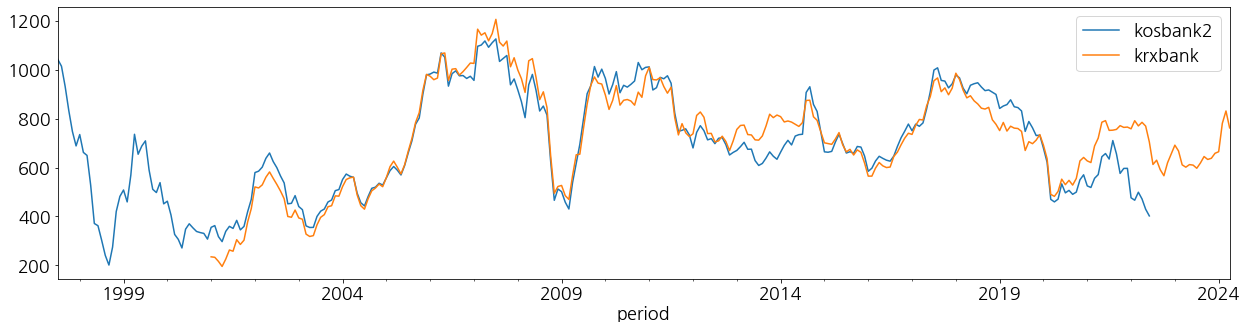

In [1176]:
data['kosbank2'] = 2.9 * data['kosbank'] # 가중치 보정
data[['kosbank2', 'krxbank']].plot()

<AxesSubplot:xlabel='period'>

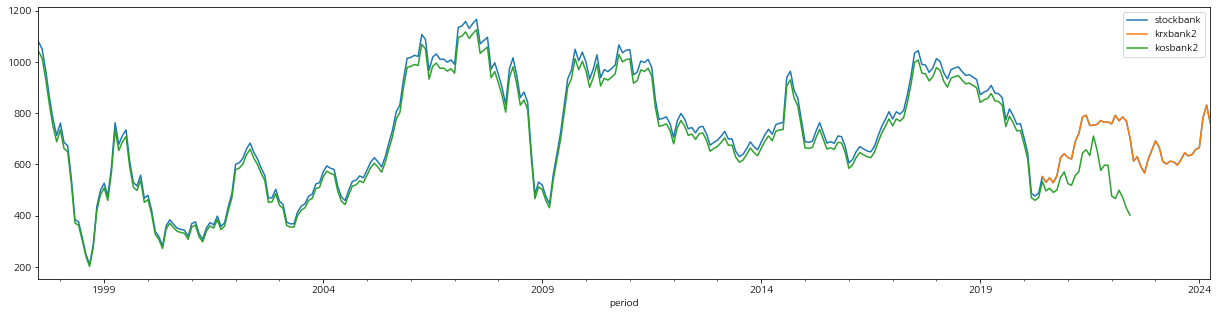

In [1022]:
data['krxbank2'] = data['krxbank']['2020-06':]
data['stockbank'] = data[['krxbank2', 'kosbank2']].transform(link)
data[['stockbank','krxbank2', 'kosbank2']].plot()

In [1023]:
# for Y(AEFSI)
data['bank_gv'] = data['stockbank'].transform(gvol)
data['cd_sp'] = data['cd91'] - data['ms91']
data['tp_sp_neg'] = -(data['kb3y'] - data['ms1y'])
data['cr_sp'] = data['cbaa3y'] - data['kb3y']
data['stock_ret'] = -data['kospi'].pct_change(12)
data['stock_gv'] = data['kospi'].transform(gvol)
data['er_gv'] = data['er'].transform(gvol)

update_meta('cd_sp', 0, 'CD spreads')
update_meta('tp_sp_neg', 0, 'negative yield slope')
update_meta('cr_sp', 0, 'credit spreads')

In [1024]:
# for X
data['kb_hp_pchg'] = data['kb_hp'].rolling(3).mean().pct_change()
data['cp_sp'] = data['cp91'] - data['call']
data['cp_sp_diff'] = data['cp_sp'].diff(12)
data['res_sdebt'] = data['reserve']/data['short_ex_debt']
data['res_sdebt_neg'] = -data['res_sdebt']
data['cc1975'] = data[['cc1975_lbond', 'cc1975_sbond', 'cc1975_loan', 'cc1975_gov']].dropna().sum(1)
data['cc2002'] = data[['cc2002_bond', 'cc2002_loan', 'cc2002_gov']].dropna().sum(1)
data['cc2008'] = data[['cc2008_bond', 'cc2008_loan', 'cc2008_gov']].dropna().sum(1)
data['cc'] = data[['cc2008','cc2002','cc1975']].transform(link)
data['cc_gdp'] = (data['cc']/data['gdp'].rolling(12).sum()*3).rolling(3).mean()
data['cc_gdp_diff'] = data['cc_gdp'].diff(12)
data['hc1975'] = data[['hc1975_lbond', 'hc1975_sbond', 'hc1975_loan', 'hc1975_gov']].dropna().sum(1)
data['hc2002'] = data[['hc2002_bond', 'hc2002_loan', 'hc2002_gov']].dropna().sum(1)
data['hc2008'] = data[['hc2008_bond', 'hc2008_loan', 'hc2008_gov']].dropna().sum(1)
data['hc2'] = data[['hc2008','hc2002','hc1975']].transform(link)
data['hc2_gdp'] = (data['hc2']/data['gdp'].rolling(12).sum()*3).rolling(3).mean()
data['hc_gdp_diff'] = data['hc2_gdp'].diff(12)
data['er_mv'] = data['er'].transform(mvol)
data['stock_cmax'] = data['kospi2'].transform(cmax)
data['bank_lev'] = data['bank_asset']/(data['bank_capital'])
data['bank_lev_diff'] = data['bank_lev'].diff(12)
data['bank_ldr'] = (data['bank_loan'] / data['bank_dep'])*100
data['bank_ldr_diff'] = data['bank_ldr'].diff(12)
data['bank_mv'] = data['stockbank'].transform(mvol)
data['gdp_growth_neg'] = -data['gdp_growth']
data['tp_sp_neg_diff'] = data['tp_sp_neg'].diff(12)
data['sr_sp'] = data['kb10y'] - data['ub10y']
data['sr_sp_diff'] = data['sr_sp'].diff(12)
data['cd_sp_diff'] = data['cd_sp'].diff(12)

update_meta('cp_sp', 0, 'CP spreads')
update_meta('cp_sp_diff', 0, 'CP spreads diff')
update_meta('res_sdebt_neg', 3, 'minus reserves over short-term foreign debt')
update_meta('cc_gdp_diff', 3, 'coporate credit over GDP diff')
update_meta('hc_gdp_diff', 3, 'household credit over GDP diff')
update_meta('kb_hp_pchg', 2, 'KB’s House Buyer’s Market Response Index')
update_meta('er_mv', 0, 'USD exchange rate volatility')
update_meta('stock_cmax', 0, 'KOSPI index - CMAX applied')
update_meta('bank_lev_diff', 3, 'bank leverage ratio diff')
update_meta('bank_ldr_diff', 0, 'bank loan to deposit ratio diff')
update_meta('bank_mv', 0, 'KOSPI bank sector volatility')
update_meta('gdp_growth_neg', 3, 'negative GDP growth rate')
update_meta('tp_sp_neg_diff', 0, 'negative term premium spreads diff')
update_meta('sr_sp', 0, 'sovereign spreads')
update_meta('sr_sp_diff', 0, 'sovereign spreads diff')
update_meta('cd_sp_diff', 0, 'CD spreads diff')

In [789]:
data.to_pickle('data/data.pkl')
meta.to_pickle('data/meta.pkl')

## 2.3. Exploratory Data Analysis

### Financial distress events

- **외환위기**(1998)
- **IT버블붕괴**(2001)
    - 2000년 당시의 코스닥 지수의 최고점은 2000년 3월 10일의 292.5였다. 이 최고점은 그 이후 현재까지 회복이 되지 않고 있으며 회복이 요원해 보인다
- **국가신용등급하향/LG카드사태**(2003)
    -  2003년 3월 20일, 금융감독위원회의 자료에 의하면 금융회사별 카드채권은 총 88.8조원으로 회사채, CP, 자산유동화채권(ABS)의 형태로 되어 있었다. 정부는 빠른 시간내에 특단의 대책을 통해 정면돌파를 실시하였다. 3월 17일 금융정책회의에서는 '신용카드사 종합대책'을 발표했다.
    - 무디스는 2003년 초 북핵 위기가 불거졌을 때 한국의 신용등급 전망을 '긍정적'에서 '부정적'으로 내린 적이 있다.
    - 2003년 3월 미국-이라크 전쟁 발발
- **GFC**(2008-2009)
- **유럽재정위기/저축은행사태**(2011-2012)
    - 2010년 초 그리스의 구제금융 신청으로 시작된 유럽 재정위기는 지난 3년간 각국의 강도 높은 긴축과 유로존의 공동대응에도 불구하고 확대됨.
    - 2011년 상호저축은행 영업정지 사건은 2011년 2월 부산저축은행 등의 여러 상호저축은행이 집단으로 영업정지된 사건이다. 이후 대주주의 비리와 마감 시간 후 VIP 고객들에 대한 사전 인출 등이 확인되어 논란이 되었다.

In [1025]:
for (bgn, end) in [('1995', '2009'), ('2010', '2024')]:
    gdp_growth = data.loc[bgn:end, ['gdp_growth', ]].resample('Q').mean().mean()
    print('%s ~ %s avg GDP growth: %f' % (bgn, end, gdp_growth))

1995 ~ 2009 avg GDP growth: 1.120000
2010 ~ 2024 avg GDP growth: 0.703571


In [706]:
# def render_gdp_drop(ax=None, freq='Q', hgrid=False, vgrid=True):
#     gdp_growth = data['gdp_growth'].resample('Q').mean()
#     # find local minima in the GDP growth data (과거 1년 평균보다 1표준편차 이상 떨어진 경우만)
#     loc_min = lambda x, t=0, q=4: x[(x.shift(1) > x) & (x.shift(-1) > x) & (t > x) & (x.rolling(q).mean() - x.std() > x)]
#     gdp_drops = gdp_growth.agg(loc_min).index

#     if ax is None:
#         ax = gdp_growth.resample(freq).ffill().plot()
#     if hgrid:
#         ax.axhline(y=0, linestyle=':')
#     if vgrid:
#         for date in gdp_drops.asfreq(freq):
#             ax.axvline(x=date, color='k', linestyle=':')

# render_gdp_drop(hgrid=True)

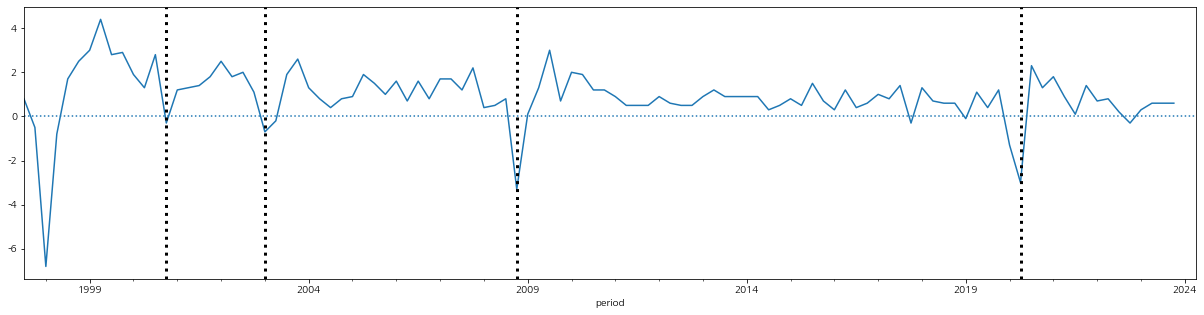

In [1026]:
def render_gdp_drop(ax=None, freq='Q', hgrid=False, vgrid=True):
    gdp_growth = data['gdp_growth'].resample('Q').mean()
    # find local minima in the GDP growth data (과거 1년 평균보다 1표준편차 이상 떨어진 경우만)
    loc_min = lambda x, t=0, q=4: x[(x.shift(1) > x) & (x.shift(-1) > x) & (t > x) & (x.rolling(q).mean() - x.std() > x)]
    gdp_drops = gdp_growth.agg(loc_min).index

    if ax is None:
        ax = gdp_growth.resample(freq).ffill().plot()
    if hgrid:
        ax.axhline(y=0, linestyle=':')
    if vgrid:
        for date in gdp_drops.asfreq(freq):
            #ax.axvline(x=date, color='k', linestyle=':')
            ax.axvline(x=date, color='k', linestyle=':', linewidth=3) 

render_gdp_drop(hgrid=True)


### 금융외환시장

In [1081]:
def compare_plots(*plot_list):
    _, axes = plt.subplots(1, len(plot_list), figsize=(24, 5))
    for i, plot in enumerate(plot_list):
        ax = axes[i] if isinstance(axes, np.ndarray) else axes
        for id, label in plot['data'].items():
            data[id].transform(scale).resample('Q').mean().plot(ax=ax, lw=3, alpha=0.5, label=label)
        render_gdp_drop(ax)
        ax.set_xlim(['1997Q1', '2024Q2'])
        ax.legend(ncol=2, loc=2, frameon=False, fontsize=14)
        ax.set_title(plot['title'], fontsize=18)
        
def compare_ids(*id_list):
    _, axes = plt.subplots(1, len(id_list))
    for i, ids in enumerate(id_list):
        ax = axes[i] if isinstance(axes, np.ndarray) else axes
        data[ids].transform(scale).resample('Q').mean().plot(ax=ax, lw=3, alpha=0.5)
        render_gdp_drop(ax)
        ax.set_xlim(['1997Q1', '2024Q2'])
        
def compare_ts_diff(ts, *diff_list):
    _, ax = plt.subplots()
    for diff in diff_list:
        if diff > 0:
            ts.diff(diff).transform(scale).resample('Q').mean().plot(ax=ax, label=('%s diff(%d)' % (ts.name, diff)), lw=3, alpha=0.5)
        else:
            ts.transform(scale).resample('Q').mean().plot(ax=ax, label=ts.name, lw=3, alpha=0.5)
    ax.set_xlim(['1997Q1', '2024Q2'])
    ax.legend()
    render_gdp_drop(ax)

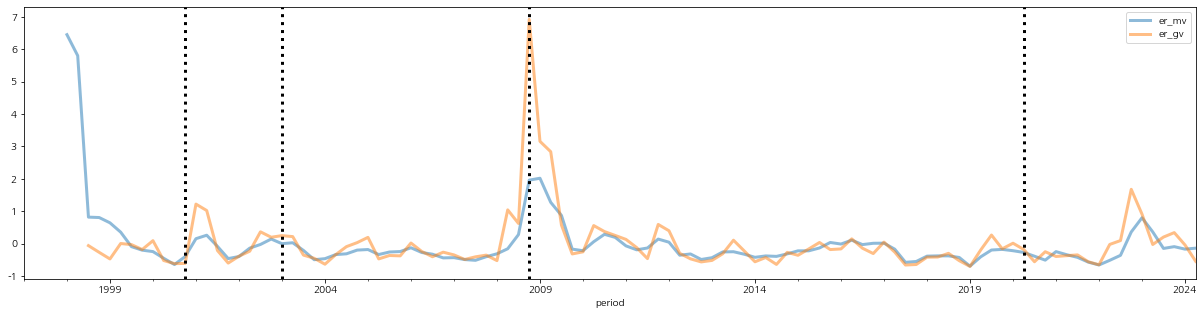

In [1082]:
data['er_mv'] = data['er'].transform(mvol)
data['er_gv'] = data['er'].transform(gvol)
# data['er_rgv'] = data['er'].transform(gvol, recursive=True)
# compare_ids(['er_mv','er_gv', 'er_rgv'])
compare_ids(['er_mv','er_gv'])

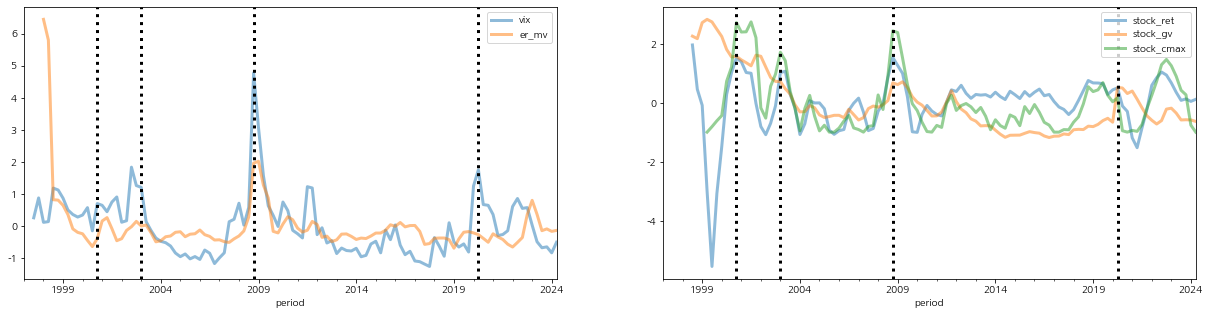

In [1083]:
data['stock_cmax'] = data['kospi2'].transform(cmax)
data['stock_ret'] = -data['kospi'].pct_change(12)
data['stock_gv'] = data['kospi'].transform(gvol)

compare_ids(['vix', 'er_mv'],
            ['stock_ret', 'stock_gv', 'stock_cmax'])

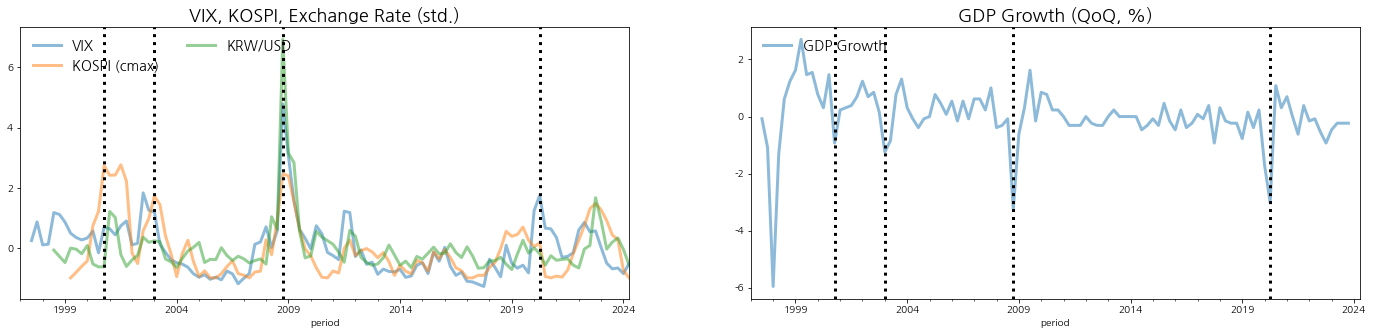

In [1084]:
compare_plots({'title':'VIX, KOSPI, Exchange Rate (std.)', 'data':{'vix': 'VIX','stock_cmax':'KOSPI (cmax)','er_gv':'KRW/USD'}},
              {'title':'GDP Growth (QoQ, %)', 'data':{'gdp_growth': 'GDP Growth'}})

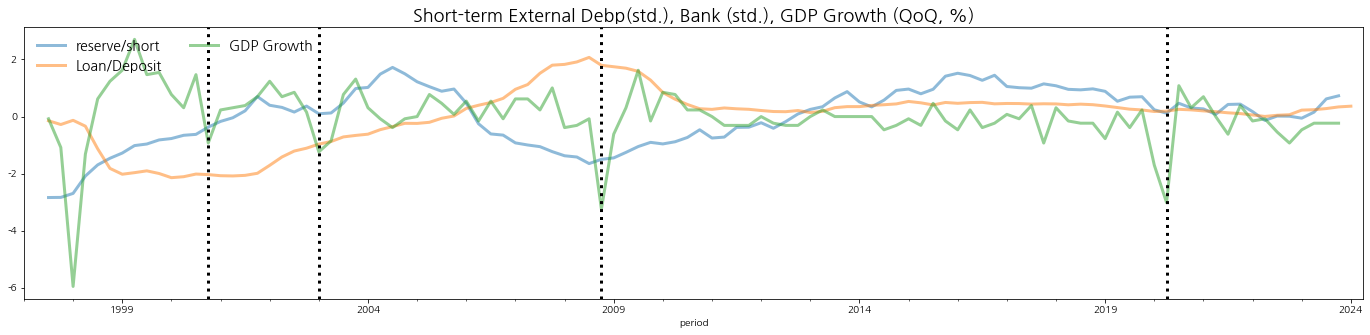

In [1085]:
compare_plots({'title':'Short-term External Debp(std.), Bank (std.), GDP Growth (QoQ, %)', 'data':{'res_sdebt' : 'reserve/short', 'bank_ldr':'Loan/Deposit','gdp_growth': 'GDP Growth'}})
             # {'title':'GDP Growth (QoQ, %)', 'data':{'gdp_growth': 'GDP Growth'}})

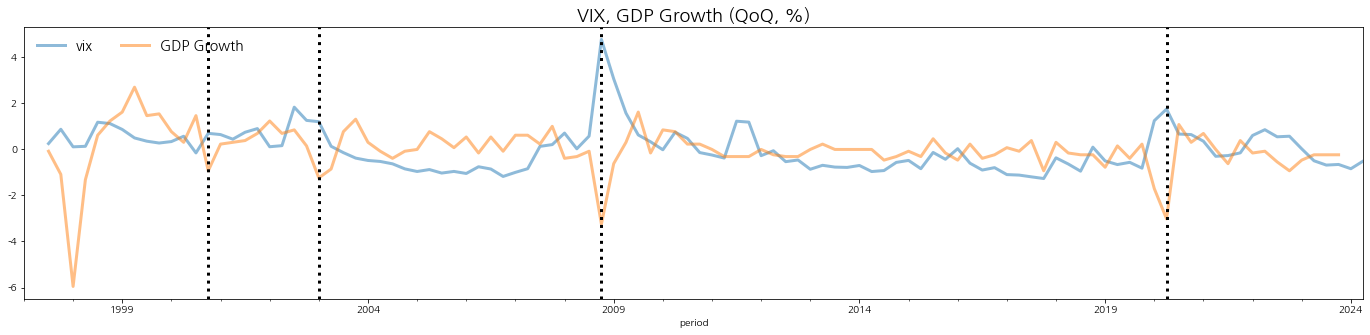

In [1086]:
#compare_plots({'title':'VIX, Exchange Rate (std.), GDP Growth (QoQ, %)', 'data':{'vix' : 'vix', 'er_gv':'KRW/USD','gdp_growth': 'GDP Growth'}})
compare_plots({'title':'VIX, GDP Growth (QoQ, %)', 'data':{'vix' : 'vix','gdp_growth': 'GDP Growth'}})
             # {'title':'GDP Growth (QoQ, %)', 'data':{'gdp_growth': 'GDP Growth'}})
             # {'title':'GDP Growth (QoQ, %)', 'data':{'gdp_growth': 'GDP Growth'}})

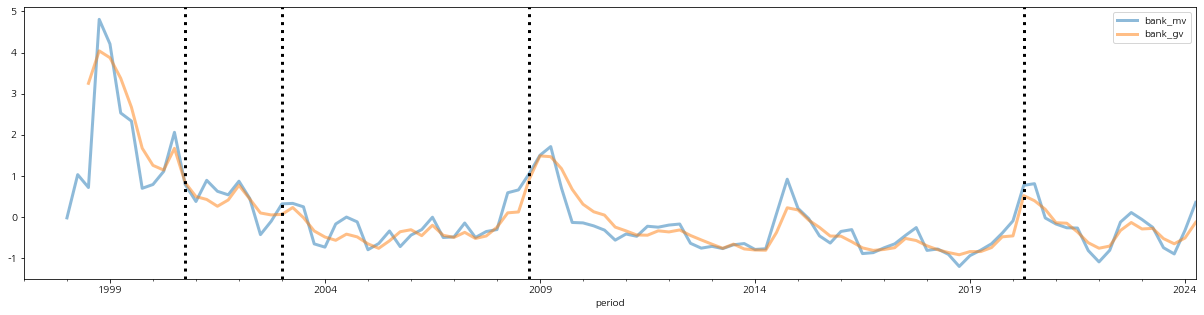

In [1087]:
data['bank_mv'] = data['stockbank'].transform(mvol)
data['bank_gv'] = data['stockbank'].transform(gvol)
# data['bank_rgv'] = data['stockbank'].transform(gvol, recursive=True)
# compare_ids(['bank_mv','bank_gv', 'bank_rgv'])
compare_ids(['bank_mv','bank_gv'])

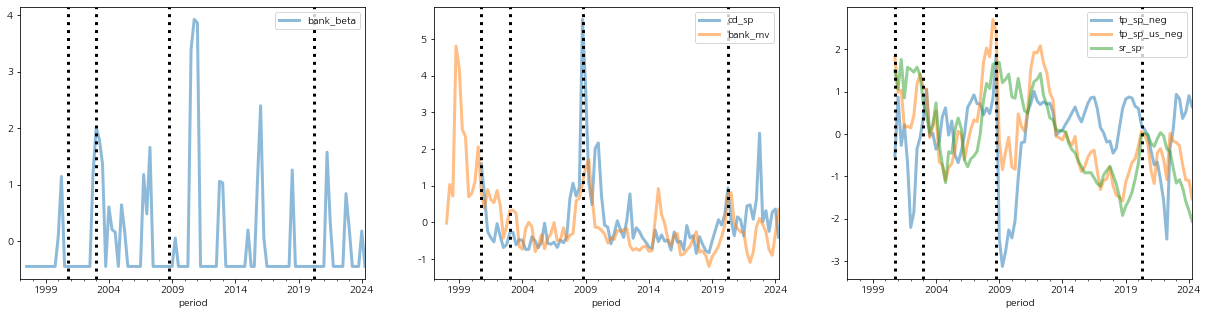

In [1088]:
data['gdp_growth_neg'] = -data['gdp_growth']
data['bank_beta'] = data[['stockbank', 'kospi']].transform(beta)
data['cd_sp'] = data['cd91'] - data['ms91']
data['tp_sp_neg'] = -(data['kb3y'] - data['ms1y'])
data['tp_sp_us_neg'] = -(data['ub10y'] - data['ms1y'])
data['sr_sp'] = data['kb10y'] - data['ub10y']

compare_ids(['bank_beta'],
            ['cd_sp', 'bank_mv'],
            ['tp_sp_neg', 'tp_sp_us_neg', 'sr_sp'])

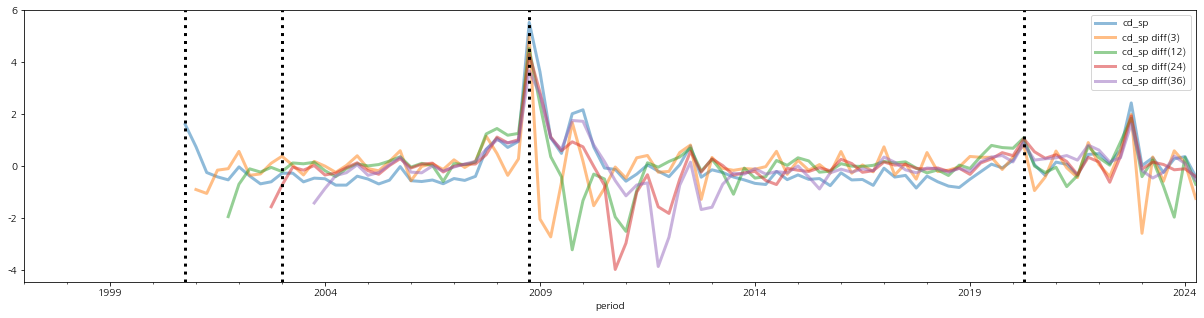

In [1089]:
compare_ts_diff(data['cd_sp'], 0, 3, 12, 24, 36)
data['cd_sp_diff'] = data['cd_sp'].diff(12)

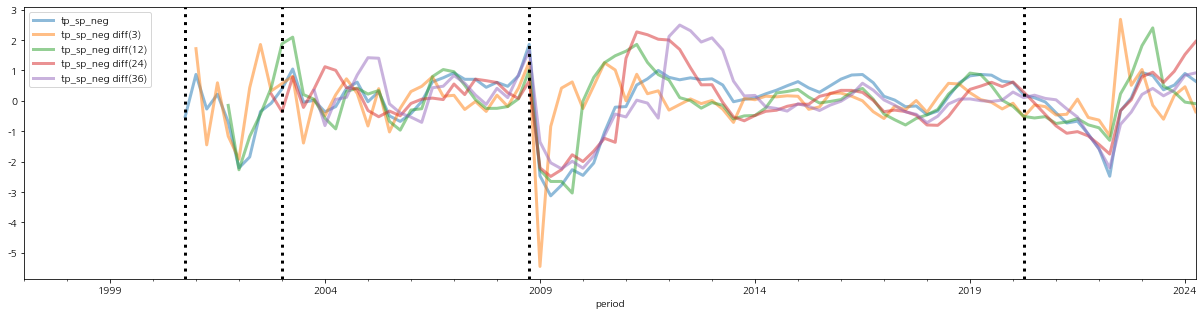

In [1090]:
compare_ts_diff(data['tp_sp_neg'], 0, 3, 12, 24, 36)
data['tp_sp_neg_diff'] = data['tp_sp_neg'].diff(12)

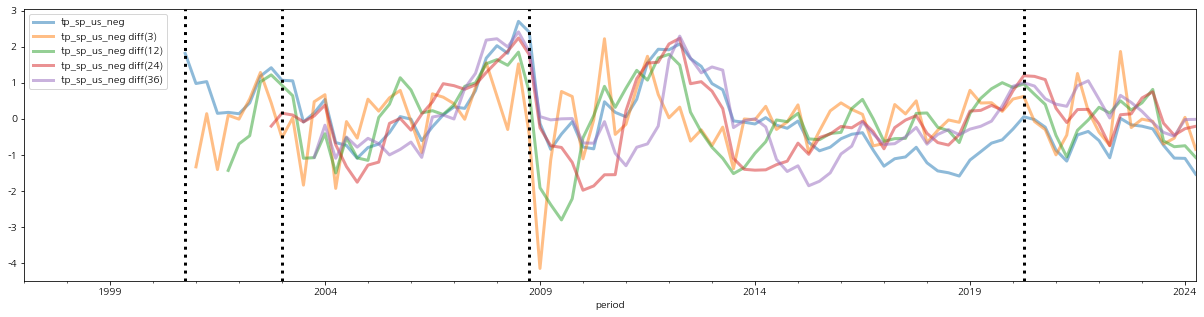

In [1091]:
compare_ts_diff(data['tp_sp_us_neg'], 0, 3, 12, 24, 36)
data['tp_sp_us_neg_diff'] = data['tp_sp_us_neg'].diff(12)

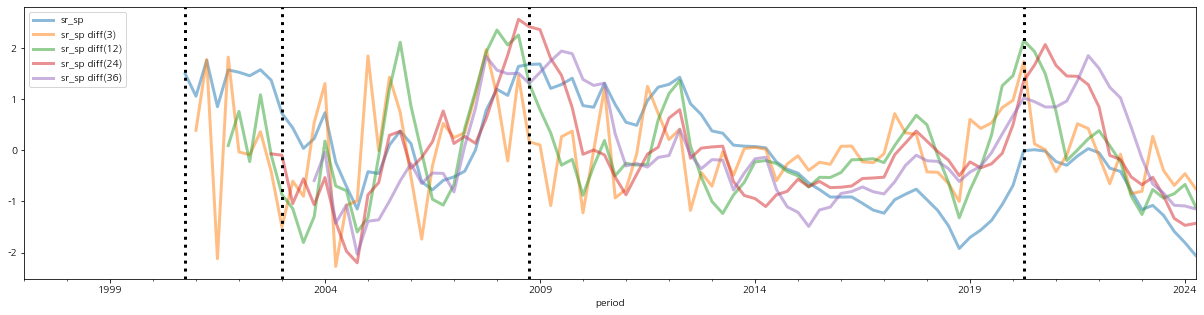

In [1092]:
compare_ts_diff(data['sr_sp'], 0, 3, 12, 24, 36)
data['sr_sp_diff'] = data['sr_sp'].diff(12)

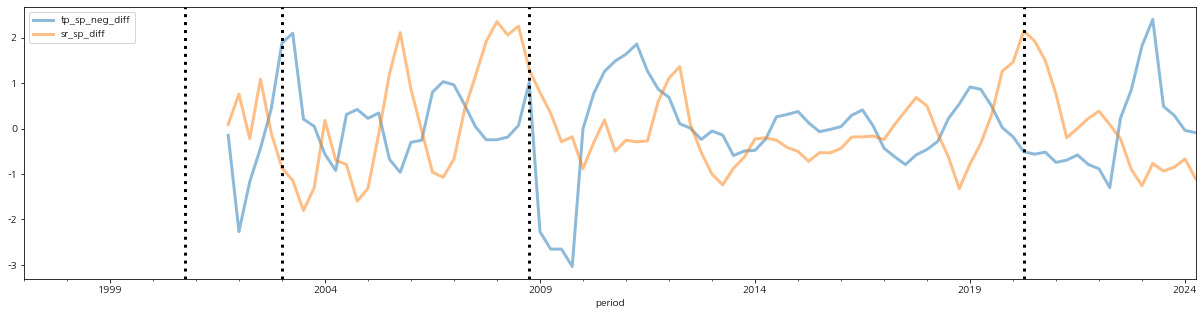

In [1093]:
compare_ids(['tp_sp_neg_diff', 'sr_sp_diff'])

# 3 - Crises dating

## Financial Stress Indices

**AE-FSI**(Cardarelli, Elekdag, and Lall (2009)) =  
*Banking*
- banking-sector stock price volatility
- TED(the spread between interbank rates and the yield on treasury bills)
- TP(the slope of the yield curve)
 
\+ *Securities*
- CR(corporate bond spreads)
- stock market returns
- stock return volatility

\+ *Exchange rate volatility*


In [1094]:
AEFSI = ['bank_gv', 'cd_sp', 'tp_sp_neg', 'cr_sp', 'stock_ret', 'stock_gv', 'er_gv']

<AxesSubplot:xlabel='period'>

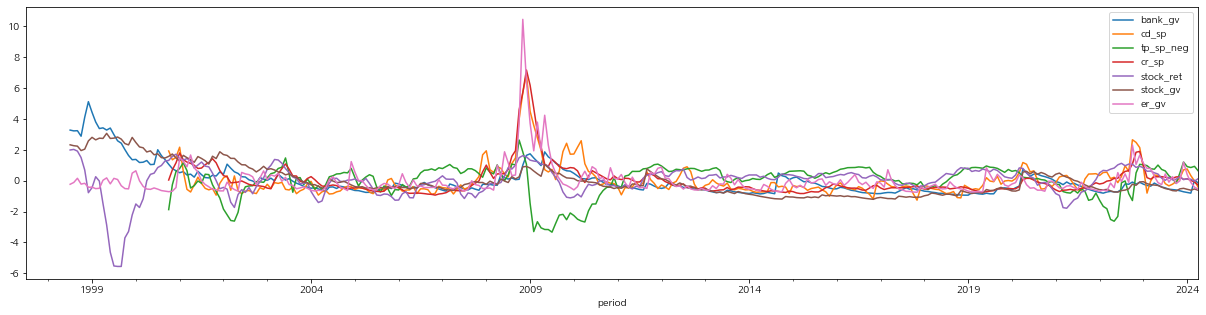

In [1095]:
data[AEFSI].transform(scale).plot()

<AxesSubplot:xlabel='period'>

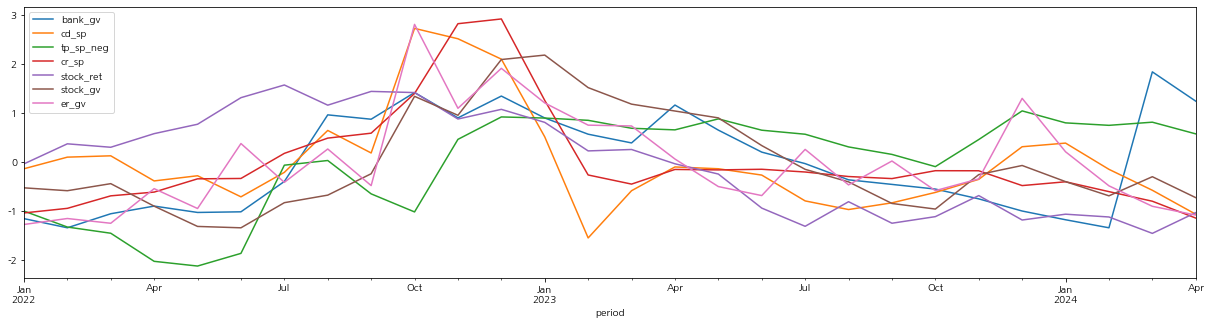

In [1096]:
data2[AEFSI].transform(scale).plot()

In [1179]:
data2  = data.loc['2008':]

<AxesSubplot:title={'center':'bank_gv'}, xlabel='period'>

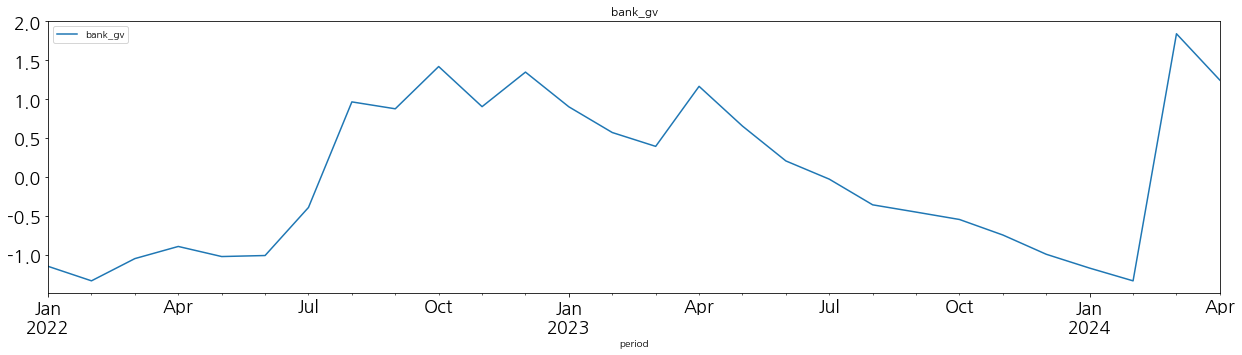

In [1065]:
data2['bank_gv'].transform(scale).plot(title='bank_gv', legend=True, fontsize=18)

<AxesSubplot:title={'center':'cd_sp'}, xlabel='period'>

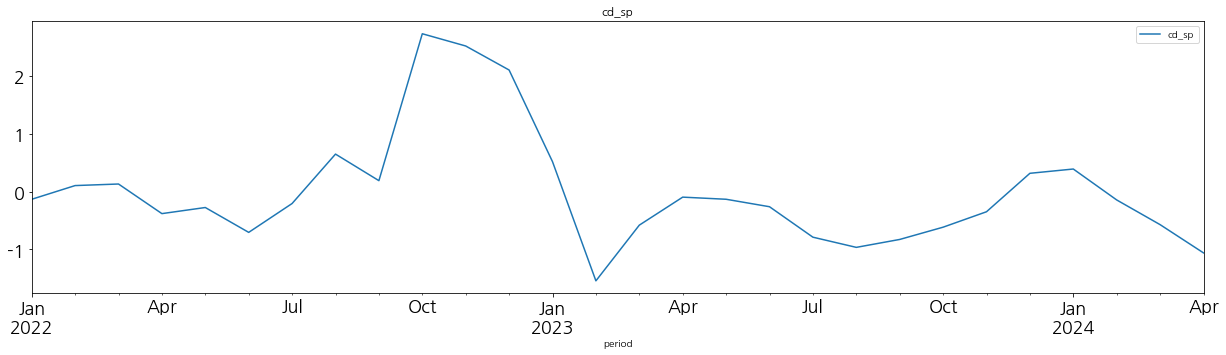

In [1074]:
data2['cd_sp'].transform(scale).plot(title='cd_sp', legend=True, fontsize=18)

<AxesSubplot:title={'center':'tp_sp_neg'}, xlabel='period'>

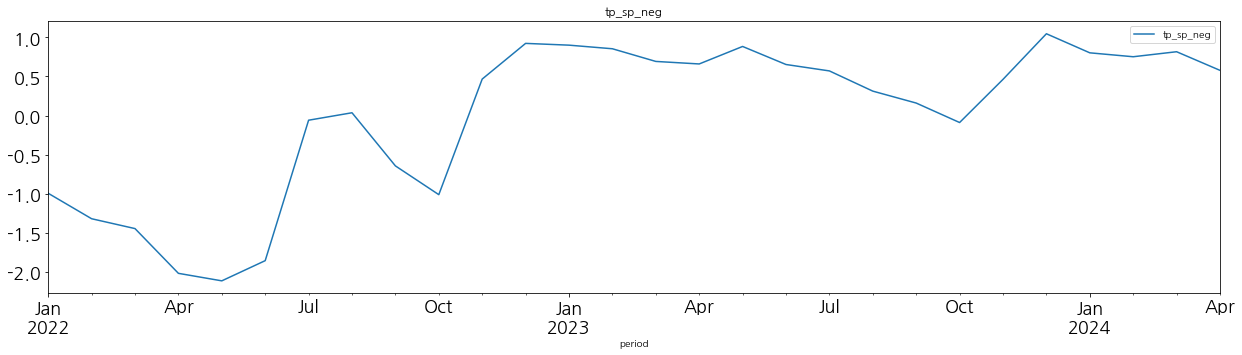

In [1075]:
data2['tp_sp_neg'].transform(scale).plot(title='tp_sp_neg', legend=True, fontsize=18)


<AxesSubplot:title={'center':'cr_sp'}, xlabel='period'>

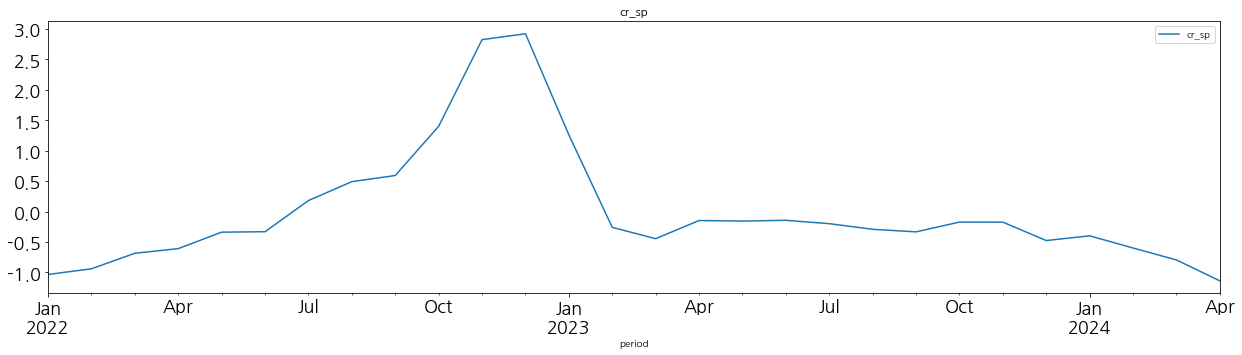

In [1076]:
data2['cr_sp'].transform(scale).plot(title='cr_sp', legend=True, fontsize=18)


<AxesSubplot:title={'center':'stock_ret'}, xlabel='period'>

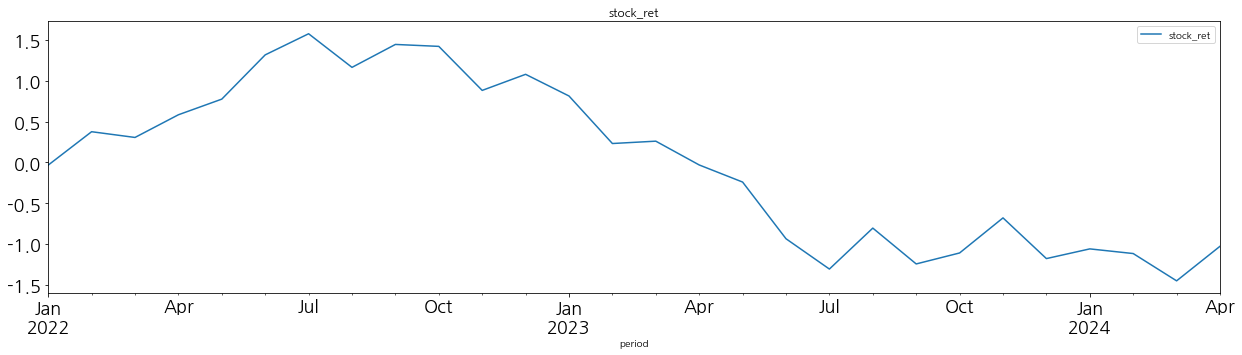

In [1077]:
data2['stock_ret'].transform(scale).plot(title='stock_ret', legend=True, fontsize=18)


<AxesSubplot:title={'center':'stock_gv'}, xlabel='period'>

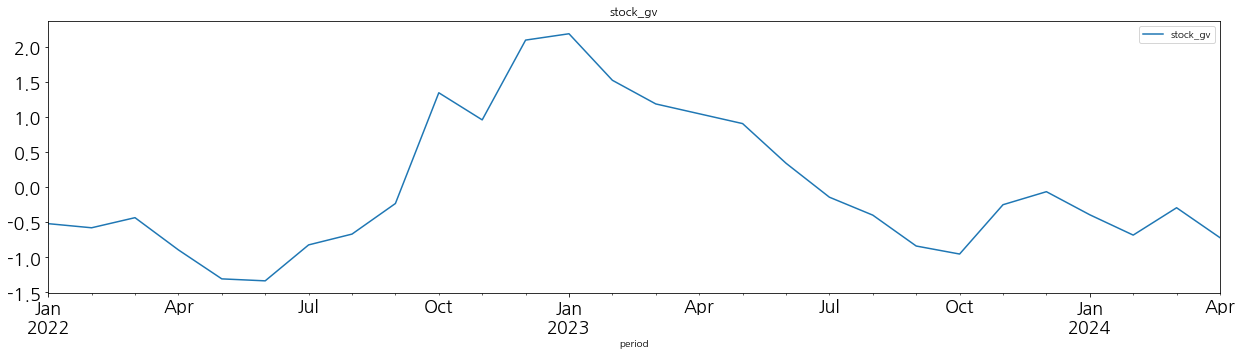

In [1078]:
data2['stock_gv'].transform(scale).plot(title='stock_gv', legend=True, fontsize=18)


<AxesSubplot:title={'center':'er_gv'}, xlabel='period'>

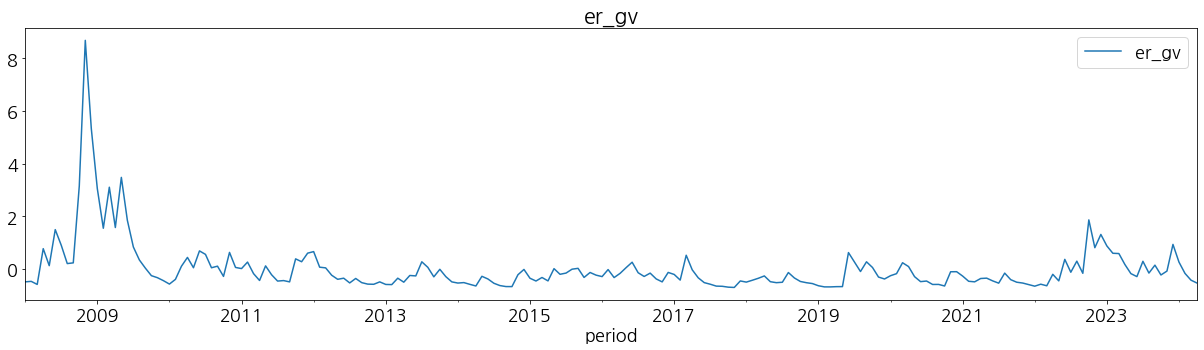

In [1180]:
data2['er_gv'].transform(scale).plot(title='er_gv', legend=True, fontsize=18)

<AxesSubplot:title={'center':'er'}, xlabel='period'>

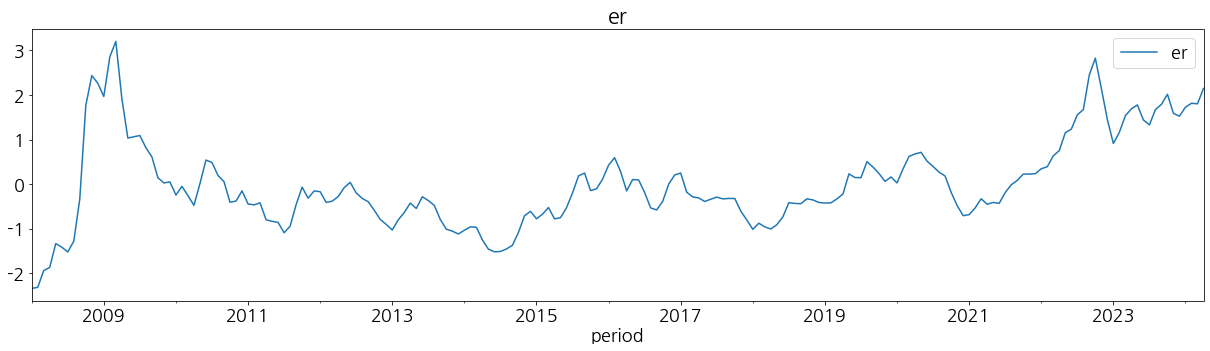

In [1181]:
data2['er'].transform(scale).plot(title='er', legend=True, fontsize=18)

<AxesSubplot:xlabel='period'>

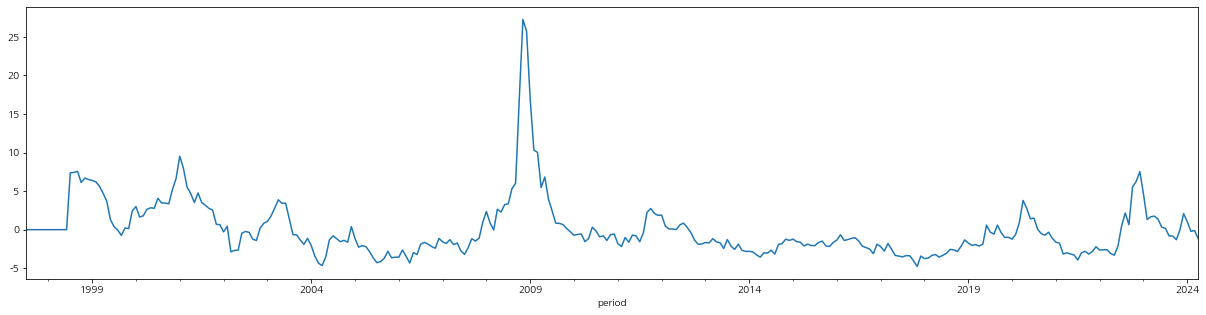

In [1072]:
data[AEFSI].transform(scale).sum(1).plot()

## Identifying crises

In [85]:
def date_crises(fsi, k=1, pre_term=6):
    crises = fsi.rename('fsi').to_frame()
    # set the term according to the threshold
    crises['term'] = (fsi > fsi.std()*k).astype(int)
    # set the previous N months as pre-crisis term
    crises['pre_term'] = crises['term'][::-1].rolling(pre_term+1, min_periods=1).max()[::-1].astype(int)
    # assign
    crises['groups'] = crises['pre_term'].rolling(2, min_periods=1).apply(lambda x: 0 if sum(x) == 2 else 1).cumsum()
    crises['post_term'] = crises.groupby('groups')['fsi'].apply(lambda x: (x.cummax() == x.max()) & (x.cummax() == x.cummax().shift(1)) & (x > fsi.std()*k)) * 1
    return crises

In [34]:
# def render_crises(crises, ax=None, fsi_plot=False, crises_plot=True):
#     fsi = crises.fsi
#     if fsi_plot:
#         if ax is None:
#             ax = fsi.plot()
#         else:
#             fsi.plot(ax=ax)
#         ax.axhline(y=crises[crises.term == 1].fsi.min(), linestyle=':')            
#     if ax is None:
#         _, ax = plt.subplots()

#     if crises_plot:
#         ymin, ymax = ax.get_ylim()
#         ax.set_ylim([ymin, ymax])        
#         ax.fill_between(fsi.index, ymin, ymax, color='red', where=crises.term, alpha=0.2)
#         ax.fill_between(fsi.index, ymin, ymax, color='red', where=crises.pre_term, alpha=0.1)
#         ax.fill_between(fsi.index, ymin, ymax, color='yellow', where=crises.post_term, alpha=0.1)

In [221]:
def render_crises(crises, ax=None, fsi_plot=False, crises_plot=True):
    fsi = crises.fsi
    if fsi_plot:
        if ax is None:
            _, ax = plt.subplots(figsize=(20, 8))
            ax = fsi.plot(ax=ax, color='black', linewidth=2)
        else:
            fsi.plot(ax=ax, color='black', linewidth=2)
        ax.axhline(y=crises[crises.term == 1].fsi.min(), linestyle=':', color='black', linewidth=2)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 8))

    if crises_plot:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim([ymin, ymax])
        
        combined_condition = np.logical_or(crises.term, crises.post_term)
        ax.fill_between(fsi.index, ymin, ymax, color='red', where=combined_condition, alpha=0.4)
        
        edges = np.diff(combined_condition.astype(int))
        starts = np.where(edges == 1)[0] + 1
        ends = np.where(edges == -1)[0]
        
        if len(ends) == 0 or (len(starts) > 0 and starts[0] > ends[0]):
            starts = np.insert(starts, 0, 0)
        if len(ends) > 0 and (len(starts) == 0 or ends[-1] < starts[-1]):
            ends = np.append(ends, len(combined_condition) - 1)
        
        for start in starts:
            start_date = fsi.index[start]
            if isinstance(fsi.index, pd.PeriodIndex):
                start_date = start_date.to_timestamp()
            
            # 여기서 바로 start_date를 사용
           # ax.axvline(x=start_date, color='red', linewidth=2, alpha=0.3)
        
        for end in ends:
            end_date = fsi.index[min(end, len(fsi.index)-1)]
            if isinstance(end_date, pd.PeriodIndex):
                end_date = end_date.to_timestamp()
            
            #ax.axvline(x=end_date, color='red', linewidth=2, alpha=0.3)

        ax.axhline(0, color='black', lw=2)


In [1164]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

def plot_fsi(fsi_cols, k, pre_term=6, xlim=['1997-07', '2024-04']):
    fsi = data[fsi_cols].transform(scale).sum(axis=1)
    crises = date_crises(fsi, k, pre_term)
    _, ax = plt.subplots(figsize=(20, 6))  # 여기에 figsize 추가
    render_crises(crises, ax, True)
    render_gdp_drop(ax, freq='M')
    
    # Set x and y axis label sizes and remove period labels
    ax.tick_params(axis='x', labelsize=15, which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', labelsize=15)
    
    # Create a twin of the original y-axis that shares the x-axis
    ax_right = ax.twinx()
    ax_right.tick_params(axis='y', labelsize=15)  # Set right y-axis label size
    
    # Set the same y-axis limits for the right axis as the left axis
    y_left_lim = ax.get_ylim()
    ax_right.set_ylim(y_left_lim)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    #ax.xaxis.set_major_locator(mdates.YearLocator(3))  # Every 3 years
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
    plt.savefig('/home/work/modelhub/EWS/svg/그림1.svg', format='svg')
    plt.show()
    

        

In [683]:
import os
os.getcwd()

'/home/work/modelhub/EWS'

In [36]:
fsi = data[AEFSI].transform(scale).sum(axis=1)
threshold = 1

fsi  term  pre_term  groups  post_term
period                                              
2023-11  0.027684     0         0   266.0          0
2023-12  2.090680     0         0   267.0          0
2024-01  1.037143     0         0   268.0          0

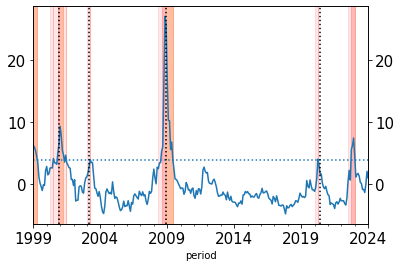

In [37]:
pre_term = 3
plot_fsi(AEFSI, threshold, pre_term)
crises3 = date_crises(fsi, threshold, pre_term=pre_term)
crises3.to_pickle('/home/work/modelhub/EWS/data/crises3.pkl')
display(crises3.tail(3))

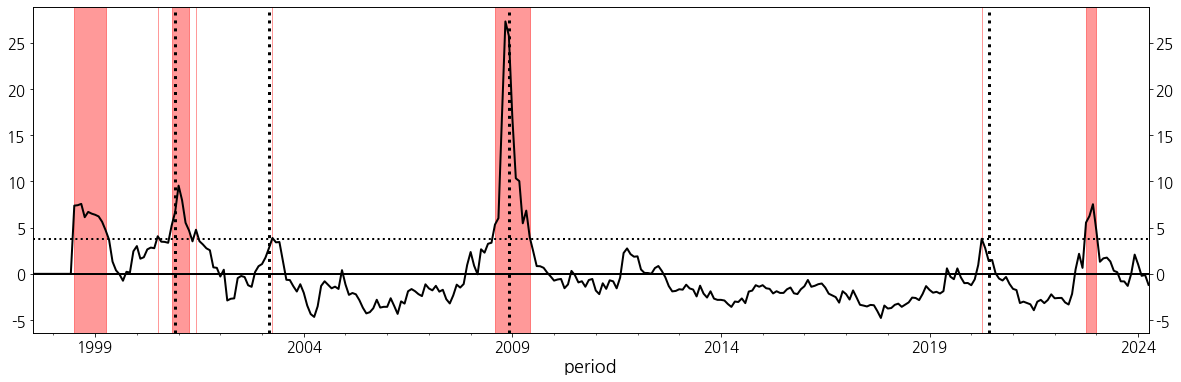

In [1165]:
pre_term = 6
plot_fsi(AEFSI, threshold, pre_term)

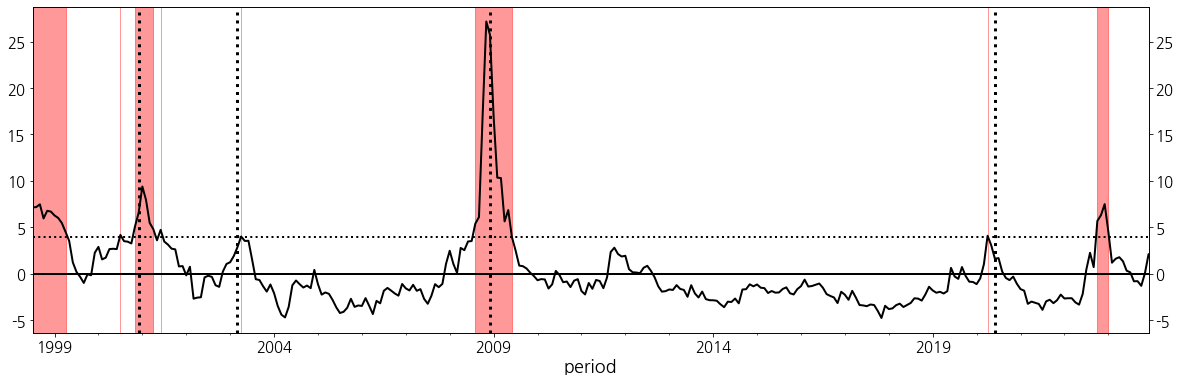

In [670]:
pre_term = 6
plot_fsi(AEFSI, threshold, pre_term)
crises6 = date_crises(fsi, threshold, pre_term=pre_term)
#crises6.to_pickle('/home/work/modelhub/EWS/data/crises6.pkl')

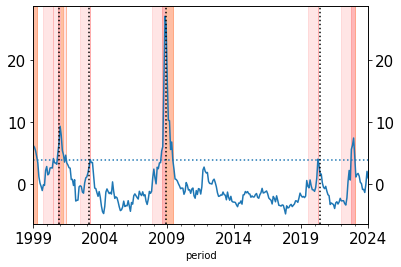

In [39]:
pre_term = 9
plot_fsi(AEFSI, threshold, pre_term)
crises12 = date_crises(fsi, threshold, pre_term=pre_term)
crises12.to_pickle('/home/work/modelhub/EWS/data/crises12.pkl')

In [40]:
def render_crises_issue(crises, ax=None, fsi_plot=False, crises_plot=True, xlim=['1998-07', None]):
    fsi = crises.fsi
    if fsi_plot:
        if ax is None:
            ax = fsi.plot()
        else:
            fsi.plot(ax=ax)
        # 여기에 0 기준선 추가
        ax.axhline(y=0, linestyle='-', color='black')  # 0 기준선을 실선으로 추가
        ax.axhline(y=crises[crises.term == 1].fsi.min(), linestyle=':', color='black')  # 최소 FSI 기준선을 점선으로 변경
    if ax is None:
        _, ax = plt.subplots()

    if crises_plot:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim([ymin, ymax])        
        ax.fill_between(fsi.index, ymin, ymax, color='red', where=crises.term, alpha=0.2)
        ax.fill_between(fsi.index, ymin, ymax, color='red', where=crises.pre_term, alpha=0.1)
        ax.fill_between(fsi.index, ymin, ymax, color='yellow', where=crises.post_term, alpha=0.1)

    if xlim is not None:
        ax.set_xlim(xlim)
        
# plot_fsi_issue 함수와 관련된 부분은 그대로 유지합니다.


        
def plot_fsi_issue(fsi_cols, k, pre_term=6, xlim=['1999-01', '2024-01']):
    fsi = data[fsi_cols].transform(scale).sum(axis=1)
    crises = date_crises(fsi, k, pre_term)
    _, ax = plt.subplots()
    render_crises_issue(crises, ax, True)
    render_gdp_drop(ax, freq='M')
    
    # FSI 데이터를 플로팅: 선 두께 4로 설정하고 색상을 검은색으로 지정
    ax.plot(fsi.index, fsi, lw=3, color='black')

    # Set x and y axis label sizes and remove period labels
    ax.tick_params(axis='x', labelsize=20, which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', labelsize=20)
    
    # Create a twin of the original y-axis that shares the x-axis
    ax_right = ax.twinx()
    ax_right.tick_params(axis='y', labelsize=20)  # Set right y-axis label size
    
    # Set the same y-axis limits for the right axis as the left axis
    y_left_lim = ax.get_ylim()
    ax_right.set_ylim(y_left_lim)

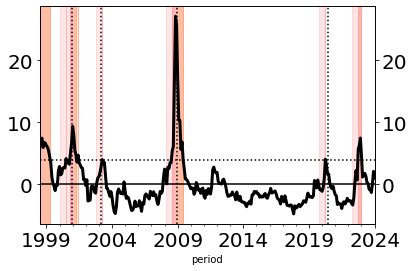

In [41]:
pre_term = 6
plot_fsi_issue(AEFSI, threshold, pre_term)

# 4 - Classifiers

In [42]:
def get_perf(Y, Y_pred, threshold=0.5, calc_auc=False):
    Actl = np.array(Y, dtype = 'bool')
    Pred = Y_pred >= threshold
    tp = np.logical_and( Actl,  Pred).sum()
    tn = np.logical_and(~Actl, ~Pred).sum()
    fp = np.logical_and(~Actl,  Pred).sum()
    fn = np.logical_and( Actl, ~Pred).sum()

    perf = {'tp':tp, 'tn':tn, 'fp':fp, 'fn':fn}
    perf['acc'] = float(tp + tn) / float(tp + tn + fp + fn) if ((tp + tn + fp + fn > 0))  else np.NaN
    perf['tpr'] = float(tp) / float(tp + fn)        if ((tp + fn > 0))  else np.NaN
    perf['fpr'] = 1 - float(tn) / float(tn + fp)    if (tn + fp > 0)    else np.NaN
    perf['nsr'] = perf['fpr'] / perf['tpr']         if ((perf['fpr'] > 0) & (perf['tpr'] > 0)) else np.NaN
    perf['f1']  = 2 * tp / (2 * tp + fp + fn)       if (tp + fp + fn > 0)    else np.NaN
    if calc_auc:
        perf['auc'] = roc_auc_score(Actl, Y_pred)   if ((tp + fn > 0) & (tn + fp > 0)) else np.NaN
    return perf

In [43]:
class SignalExtraction(BaseEstimator, ClassifierMixin):
    def __init__(self, significance=0.75):
        self.significance = significance

    def fit(self, X, y, **kwargs):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.cutoffs = []
        self.weights = []
        for col in range(X.shape[1]):
            thresholds = np.unique(X[:,col])
            nsrs = [get_perf(y, X[:,col], threshold)['nsr'] for threshold in thresholds]
            cutoff = np.nanargmin(nsrs)
            self.cutoffs.append(thresholds[cutoff])
            self.weights.append(1/nsrs[cutoff] if (nsrs[cutoff] < self.significance) else 0)
        norm = sum(self.weights)
        self.weights = [weight / norm for weight in self.weights]
        return self

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5) * 1
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        proba = ((X > self.cutoffs) * self.weights).sum(axis=1)
        return np.stack([1 - proba, proba], 1)

In [44]:
def build_NN(units, features, dropout_prob=0.5):
    model = Sequential()
    model.add(Dense(units=units, input_shape=(features,)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [45]:
model_classifiers = {
    'LR': LogisticRegression(max_iter=1000),
    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),  # Ridge 추가
    'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5),  # ElasticNet 추가
    'SE': SignalExtraction(),
    'RF': RandomForestClassifier(criterion='entropy'),
    'XGB': XGBClassifier(eval_metric='logloss'),
    'ET': ExtraTreesClassifier(),
    'NN': KerasClassifier(model=build_NN, units=10, features=15, verbose=0), # 10에서 featurs 15개로 수정
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True)
}

In [60]:
lasso_param_grid = {
    'C': [1, 5, 10]
    }

se_param_grid = {
    'significance': [0.7, 0.75, 0.8, 0.85, 0.9]
}

rf_param_grid = {
    'n_estimators': [1000],
    'max_features': [3, 5, 7, 10, 15],
    'max_depth': [5,7,10,12,15,17,20]
    }

xgb_param_grid = {
   'n_estimators': [1000],
   'max_depth':[3, 5],
   'gamma':[0.03, 0.1],
   'colsample_bytree':[0.4],
   'min_child_weight':[1.5, 3],
   'learning_rate':[0.1],
   'reg_alpha':[0.75],
   'reg_lambda':[0.45],
   'subsample':[0.95],
   'objective': ['binary:logistic']
   }

ext_param_grid = {

    'n_estimators': [1000],
    'max_features': [3, 5, 7, 10, 15],
    'max_depth': [15,20,30,40]
    }

    
svm_param_grid = {
    'C': [0.1, 1, 10],  # 규제 강도의 역수
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}


ridge_param_grid = {
    'C': [0.1, 1, 10, 20]  # 규제 강도
}


elasticnet_param_grid = {
    'C': [0.1, 1, 5, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}


nn_param_grid = {
   'units':[5, 10, 30, 50],
   'batch_size':[30]
   }


model_params = {
    'LR':{}, 
    'Lasso':lasso_param_grid, 
    'Ridge':ridge_param_grid, 
    'ElasticNet':elasticnet_param_grid, 
    'SVM' : svm_param_grid,
    'SE':se_param_grid, 
    'RF':rf_param_grid, 
    'XGB':xgb_param_grid,
    'ET':ext_param_grid,
    'NN':nn_param_grid
    }

In [47]:
def get_data(X_in, y_in, range_from, range_to, group_bgn_ext=0, group_end_ext=0):
    X = X_in.copy()
    Y = y_in.copy()

    # extend the group range by 2*N months (the previous and next)
    if group_bgn_ext + group_end_ext > 0:
        group_ext_range = Y[Y.pre_term == 1].groupby('groups')['pre_term'].agg([lambda x: min(x.index)-group_bgn_ext,
                                                                                lambda x: max(x.index)+group_end_ext])
        for grp, range in group_ext_range.iterrows():
            print('Group %3d: %s ~ %s' % (grp, range[0], range[1]))
            Y.loc[range[0]:range[1], 'groups'] = grp

    y = Y.pre_term
    groups = Y.groups
    post_crises = Y.post_term
    
    # apply delays
    pd.options.mode.chained_assignment = None
    meta = pd.read_pickle('/home/work/modelhub/EWS/data/meta.pkl')
    for id, delay in meta.loc[X.columns]['Delay'][(meta.loc[X.columns]['Delay'] >= 1)].iteritems():
        X[id] = X[id].shift(delay)
            
    # imputation
    X = X.fillna(X.median())
    X = X.loc[range_from:range_to]
    y = y.loc[range_from:range_to]
    groups = groups.loc[range_from:range_to]
    post_crises = post_crises.loc[range_from:range_to]
    
    return X, y, groups, post_crises

In [48]:
def load_cv(X, y, groups=None, excluds=None, n_splits=5, walk_forward=False, bootstrap=True):
    # define how to split train / test dataset
    if walk_forward > 0: # Walkfoward
        splitter = TimeSeriesSplit(n_splits=n_splits, test_size=1, gap=1)
    else: # Random CV (stratified & grouped)
        splitter = StratifiedGroupKFold(n_splits=n_splits)

    # bootstrap & standardization
    cv_index = []
    cv_data = []
    for f, (ix_train, ix_test) in enumerate(splitter.split(X, y, groups)):
        if excluds is not None:
            ix_train = np.array([ix for ix in ix_train if ix not in excluds])

        if bootstrap:
            ix_pos = ix_train[y[ix_train] == 1]
            ix_neg = ix_train[y[ix_train] == 0]
            major = ix_neg if len(ix_neg) > len(ix_pos) else ix_pos
            minor = ix_pos if len(ix_neg) > len(ix_pos) else ix_neg
            ix_train = np.concatenate((np.random.choice(major, size=len(major), replace=False),
                                       np.random.choice(minor, size=len(major), replace=True)))
        cv_index.append((ix_train, ix_test))

        data = {}
        scaler = StandardScaler()
        data['train_X'] = scaler.fit_transform(X.iloc[ix_train])
        data['test_X'] = scaler.transform(X.iloc[ix_test])
        data['train_y'] = y[ix_train]
        data['test_y'] = y[ix_test]
        data['train_groups'] = groups[ix_train]
        cv_data.append(data)

    return cv_index, cv_data

In [49]:
def train_and_test(cv_index, cv_data, models=[], shap_models=[], progress=True, params=None):
    result_preds = pd.DataFrame(index=np.arange(len(X)), columns=(['fold', 'actl'] + models))
    result_shap = {}
    for shap_model in shap_models:
        result_shap[shap_model] = pd.DataFrame(index=np.arange(len(X)), columns=(X.columns.to_list()))

    results = {'preds': result_preds, 'shap': result_shap}
    
    if progress:
        model_iterator = tqdm(models)
    else:
        model_iterator = models

    for f, (_, ix_test) in enumerate(cv_index):
        result_preds['fold'].iloc[ix_test] = f
        result_preds['actl'].iloc[ix_test] = cv_data[f]['test_y']
        
    for model in model_iterator:
        classifier = model_classifiers[model]
        
        if params is not None:
            param = params[model]
            classifier.set_params(**param)
            
        for f, (ix_train, ix_test) in enumerate(cv_index):    
            # fit to the trainset
            sample_weight = compute_sample_weight('balanced', cv_data[f]['train_y'])
            classifier.fit(cv_data[f]['train_X'], cv_data[f]['train_y'], sample_weight=sample_weight)

            # Predict probabilities
            prob = classifier.predict_proba(cv_data[f]['test_X'])
            results['preds'][model].iloc[ix_test] = prob[:, 1] if len(prob.shape) > 1 else [prob[1]]
            
            # calculate shap values for tree-based algorithm
            if model in shap_models:
                explainer = shap.TreeExplainer(classifier)
                shap_values = explainer.shap_values(cv_data[f]['test_X'])
                results['shap'][model].iloc[ix_test,:] = shap_values[1] if isinstance(shap_values, list) else shap_values
        
    return results

In [50]:
def test_summary(models=[], results=None):
    perfs = []
    
    for model in models:
        missing = results['preds'][model].isna()

        # record the performance metrics
        perf = get_perf(results['preds'][~missing]['actl'], results['preds'][~missing][model], calc_auc=True)
        perfs.append(perf)
    
    display(pd.DataFrame(perfs, index=models))

# 5 - Tuning, Training & Test

In [51]:
def grid_search(cv_index, cv_data, models, progress=True, scoring='roc_auc'):
    if progress:
        model_iterator = tqdm(models)
    else:
        model_iterator = models
    
    best_params = {}
    
    for model in model_iterator:
        best_param = {}
        best_score = 0
        classifier = model_classifiers[model]

        for f, (ix_train, ix_test) in enumerate(cv_index):
            # Hypertune with nested CV
            splitter = StratifiedGroupKFold(n_splits=4)
            cv_inner = splitter.split(cv_data[f]['train_X'], cv_data[f]['train_y'], cv_data[f]['train_groups'])

            grid = GridSearchCV(classifier, cv=cv_inner, param_grid=model_params[model], scoring=scoring, verbose=False)
            grid.fit(cv_data[f]['train_X'], cv_data[f]['train_y'])

            print('%s %d - Best Score: %f, Best Params: %s' % (model, f, grid.best_score_, grid.best_params_))
            # Display(grid.cv_results_)

            if grid.best_score_ > best_score:
                best_param = grid.best_params_
                best_score = grid.best_score_

        best_params[model] = best_param
            
    return best_params

## 5.1 Experiments with CV out-of-sample

#### Models & Hyperparameters

In [52]:
models = ['LR', 'Lasso', 'Ridge', 'ElasticNet', 'SVM', 'NN', 'SE'] #@param {type: 'raw'}
#models = ['LR', 'Lasso', 'Ridge', 'ElasticNet', 'SE', 'SVM']
shap_models = ['RF', 'XGB', 'ET'] #@param {type: 'raw'}
models = models + shap_models
scoring = 'roc_auc'  #@param ['accuracy', 'f1', 'roc_auc', 'neg_log_loss'] {type:'string'}
# params = {
#     'LR': {},
#     'Lasso': {'C': 1},
#     'Ridge': {'solver': 'saga', 'penalty': 'l2', 'C': 1},  # Ridge 모델 파라미터 추가
#     'ElasticNet': {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 1},  # ElasticNet 모델 파라미터 추가
#     'SE': {'significance': 0.75},
#     'NN': {'batch_size': 30, 'units': 50},
#     'RF': {'max_depth': 10, 'max_features': 4, 'n_estimators': 100},
#     'EXT': {'max_depth': 10, 'max_features': 4, 'n_estimators': 100},
#     'XGB': {
#         'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.1,
#         'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 50, 'subsample': 0.95,
#         'objective': 'binary:logistic', 'reg_alpha': 0.75, 'reg_lambda': 0.45
#     },
#     'SVM' : {
#     'C': 1.0,  # 정규화 매개변수
#     'kernel': 'rbf',  # 커널 타입 ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed')
#     'gamma': 'scale'  # 커널 계수 ('scale', 'auto' 또는 float 값)
#     }
# }

In [53]:
range_from = '1997-07-01'  #@param {type: 'date'}
range_to = '2024-01-31'  #@param {type: 'date'}
group_bgn_ext = 3  #@param {type: 'integer'}
group_end_ext = 3  #@param {type: 'integer'}
exclude_post_crises = True #@param {type: 'boolean'}

x_cols = ['er_mv', 'vix', 'cp_sp_diff', 'sr_sp_diff', 'gdp_growth_neg', 'res_sdebt_neg',
          'bank_lev_diff', 'bank_mv', 'bank_ldr_diff', 'cd_sp_diff', 'tp_sp_neg_diff',
          'kb_hp_pchg', 'stock_cmax', 'hc_gdp_diff', 'cc_gdp_diff']

if 'NN' in models:
    _ = model_classifiers['NN'].set_params(features=len(x_cols))

data = pd.read_pickle('/home/work/modelhub/EWS/data/data.pkl')

#### Cross-validation

In [54]:
n_iter = 1  #@param {type: 'integer'}
sub_progress = False #@param {type: 'boolean'}
hypertune = True #@param {type: 'boolean'}
summary = False #@param {type: 'boolean'}

In [55]:
def run_cv(crises, n_iter=1, sub_progress=False, hypertune=True, summary=False):
    preds = []
    shaps= {shap_model: [] for shap_model in shap_models}

    X, y, groups, post_crises = get_data(data[x_cols], crises, range_from, range_to, group_bgn_ext, group_end_ext)
    excluds = post_crises if exclude_post_crises else None

    for iter in tqdm(range(n_iter)):
        if sub_progress:
            print('iteration', iter+1)

        cv_index, cv_data = load_cv(X, y, groups, excluds)
        #models  = ['LR', 'Lasso', 'Ridge', 'ElasticNet', 'SVM', 'NN', 'SE', 'RF', 'XGB', 'EXT']
        if hypertune:
            params = grid_search(cv_index, cv_data, models, progress=sub_progress,scoring=scoring)
            print('best_params = ', params)

        result = train_and_test(cv_index, cv_data, models, shap_models, progress=sub_progress, params=params)

        if summary:
            test_summary(models, result)

        preds.append(result['preds'])
        for shap_model in shap_models:
            shaps[shap_model].append(result['shap'][shap_model])
    return params, preds, shaps

In [56]:
models

['LR', 'Lasso', 'Ridge', 'ElasticNet', 'SVM', 'NN', 'SE', 'RF', 'XGB', 'ET']

In [57]:
crises3 = pd.read_pickle('/home/work/modelhub/EWS/data/crises3.pkl')
crises = crises3
X, y, groups, post_crises = get_data(data[x_cols], crises, range_from, range_to, group_bgn_ext, group_end_ext)

Group  10: 1998-01 ~ 1999-07
Group  22: 2000-01 ~ 2001-09
Group  41: 2002-10 ~ 2003-07
Group 102: 2008-02 ~ 2009-09
Group 229: 2019-10 ~ 2020-07
Group 256: 2022-04 ~ 2023-04


In [61]:
#crises3 = pd.read_pickle('/home/work/modelhub/EWS/data/crises3.pkl')
params3, preds3, shaps3 = run_cv(crises3)

Group  10: 1998-01 ~ 1999-07
Group  22: 2000-01 ~ 2001-09
Group  41: 2002-10 ~ 2003-07
Group 102: 2008-02 ~ 2009-09
Group 229: 2019-10 ~ 2020-07
Group 256: 2022-04 ~ 2023-04


  0%|          | 0/1 [00:00<?, ?it/s]

LR 0 - Best Score: 0.847348, Best Params: {}
LR 1 - Best Score: 0.838685, Best Params: {}
LR 2 - Best Score: 0.867023, Best Params: {}
LR 3 - Best Score: 0.916836, Best Params: {}
LR 4 - Best Score: 0.835629, Best Params: {}
Lasso 0 - Best Score: 0.866791, Best Params: {'C': 1}
Lasso 1 - Best Score: 0.832538, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.864843, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.928774, Best Params: {'C': 1}
Lasso 4 - Best Score: 0.886946, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.901840, Best Params: {'C': 0.1}
Ridge 1 - Best Score: 0.902336, Best Params: {'C': 0.1}
Ridge 2 - Best Score: 0.927313, Best Params: {'C': 0.1}
Ridge 3 - Best Score: 0.958202, Best Params: {'C': 0.1}
Ridge 4 - Best Score: 0.930305, Best Params: {'C': 0.1}
ElasticNet 0 - Best Score: 0.904015, Best Params: {'C': 0.1, 'l1_ratio': 0.5}
ElasticNet 1 - Best Score: 0.925628, Best Params: {'C': 0.1, 'l1_ratio': 0.9}
ElasticNet 2 - Best Score: 0.926873, Best Params: {'C': 0.1, 'l1_rati

In [62]:
with open('/home/work/modelhub/EWS/data/preds3.pkl', 'wb') as file:
    pickle.dump(preds3, file)
    
with open('/home/work/modelhub/EWS/data/shaps3.pkl', 'wb') as file:
    pickle.dump(shaps3, file)
    
with open('/home/work/modelhub/EWS/data/params3.pkl', 'wb') as file:
    pickle.dump(params3, file)

In [63]:
range_from = '1997-07-01'  #@param {type: 'date'}
range_to = '2024-01-31'  #@param {type: 'date'}
group_bgn_ext = 3  #@param {type: 'integer'}
group_end_ext = 3  #@param {type: 'integer'}
exclude_post_crises = True #@param {type: 'boolean'}

x_cols = ['er_mv', 'vix', 'cp_sp_diff', 'sr_sp_diff', 'gdp_growth_neg', 'res_sdebt_neg',
          'bank_lev_diff', 'bank_mv', 'bank_ldr_diff', 'cd_sp_diff', 'tp_sp_neg_diff',
          'kb_hp_pchg', 'stock_cmax', 'hc_gdp_diff', 'cc_gdp_diff']

if 'NN' in models:
    _ = model_classifiers['NN'].set_params(features=len(x_cols))

#data = pd.read_pickle('/home/work/modelhub/EWS/data/data.pkl')

In [64]:
#crises6 = pd.read_pickle('/home/work/modelhub/EWS/data/crises6.pkl')
crises = crises6
X, y, groups, post_crises = get_data(data[x_cols], crises, range_from, range_to, group_bgn_ext, group_end_ext)

Group   7: 1997-10 ~ 1999-07
Group  16: 1999-10 ~ 2001-09
Group  32: 2002-07 ~ 2003-07
Group  90: 2007-11 ~ 2009-09
Group 214: 2019-07 ~ 2020-07
Group 238: 2022-01 ~ 2023-04


In [65]:
params6, preds6, shaps6 = run_cv(crises6)

Group   7: 1997-10 ~ 1999-07
Group  16: 1999-10 ~ 2001-09
Group  32: 2002-07 ~ 2003-07
Group  90: 2007-11 ~ 2009-09
Group 214: 2019-07 ~ 2020-07
Group 238: 2022-01 ~ 2023-04


  0%|          | 0/1 [00:00<?, ?it/s]

LR 0 - Best Score: 0.688459, Best Params: {}
LR 1 - Best Score: 0.574110, Best Params: {}
LR 2 - Best Score: 0.744769, Best Params: {}
LR 3 - Best Score: 0.798104, Best Params: {}
LR 4 - Best Score: 0.879412, Best Params: {}
Lasso 0 - Best Score: 0.705476, Best Params: {'C': 1}
Lasso 1 - Best Score: 0.540956, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.760526, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.801563, Best Params: {'C': 1}
Lasso 4 - Best Score: 0.862716, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.793436, Best Params: {'C': 0.1}
Ridge 1 - Best Score: 0.693781, Best Params: {'C': 0.1}
Ridge 2 - Best Score: 0.832985, Best Params: {'C': 0.1}
Ridge 3 - Best Score: 0.859724, Best Params: {'C': 0.1}
Ridge 4 - Best Score: 0.952868, Best Params: {'C': 0.1}
ElasticNet 0 - Best Score: 0.842025, Best Params: {'C': 0.1, 'l1_ratio': 0.5}
ElasticNet 1 - Best Score: 0.740496, Best Params: {'C': 0.1, 'l1_ratio': 0.5}
ElasticNet 2 - Best Score: 0.889842, Best Params: {'C': 0.1, 'l1_rati

In [66]:
with open('/home/work/modelhub/EWS/data/preds6.pkl', 'wb') as file:
    pickle.dump(preds6, file)
    
with open('/home/work/modelhub/EWS/data/shaps6.pkl', 'wb') as file:
    pickle.dump(shaps6, file)
    
with open('/home/work/modelhub/EWS/data/params6.pkl', 'wb') as file:
    pickle.dump(params6, file)

In [67]:
range_from = '1997-07-01'  #@param {type: 'date'}
range_to = '2024-01-31'  #@param {type: 'date'}
group_bgn_ext = 3  #@param {type: 'integer'}
group_end_ext = 3  #@param {type: 'integer'}
exclude_post_crises = True #@param {type: 'boolean'}

x_cols = ['er_mv', 'vix', 'cp_sp_diff', 'sr_sp_diff', 'gdp_growth_neg', 'res_sdebt_neg',
          'bank_lev_diff', 'bank_mv', 'bank_ldr_diff', 'cd_sp_diff', 'tp_sp_neg_diff',
          'kb_hp_pchg', 'stock_cmax', 'hc_gdp_diff', 'cc_gdp_diff']

if 'NN' in models:
    _ = model_classifiers['NN'].set_params(features=len(x_cols))

In [68]:
crises12 = pd.read_pickle('/home/work/modelhub/EWS/data/crises12.pkl')
crises = crises12
X, y, groups, post_crises = get_data(data[x_cols], crises, range_from, range_to, group_bgn_ext, group_end_ext)

Group   4: 1997-07 ~ 1999-07
Group  10: 1999-07 ~ 2001-09
Group  23: 2002-04 ~ 2003-07
Group  78: 2007-08 ~ 2009-09
Group 199: 2019-04 ~ 2020-07
Group 220: 2021-10 ~ 2023-04


In [69]:
crises12 = pd.read_pickle('/home/work/modelhub/EWS/data/crises12.pkl')
params12, preds12, shaps12 = run_cv(crises12)

Group   4: 1997-07 ~ 1999-07
Group  10: 1999-07 ~ 2001-09
Group  23: 2002-04 ~ 2003-07
Group  78: 2007-08 ~ 2009-09
Group 199: 2019-04 ~ 2020-07
Group 220: 2021-10 ~ 2023-04


  0%|          | 0/1 [00:00<?, ?it/s]

LR 0 - Best Score: 0.721970, Best Params: {}
LR 1 - Best Score: 0.882000, Best Params: {}
LR 2 - Best Score: 0.751853, Best Params: {}
LR 3 - Best Score: 0.892862, Best Params: {}
LR 4 - Best Score: 0.747847, Best Params: {}
Lasso 0 - Best Score: 0.746169, Best Params: {'C': 1}
Lasso 1 - Best Score: 0.921003, Best Params: {'C': 1}
Lasso 2 - Best Score: 0.778010, Best Params: {'C': 1}
Lasso 3 - Best Score: 0.864850, Best Params: {'C': 5}
Lasso 4 - Best Score: 0.742600, Best Params: {'C': 1}
Ridge 0 - Best Score: 0.830520, Best Params: {'C': 0.1}
Ridge 1 - Best Score: 0.902984, Best Params: {'C': 0.1}
Ridge 2 - Best Score: 0.865174, Best Params: {'C': 0.1}
Ridge 3 - Best Score: 0.916839, Best Params: {'C': 0.1}
Ridge 4 - Best Score: 0.900946, Best Params: {'C': 0.1}
ElasticNet 0 - Best Score: 0.832226, Best Params: {'C': 0.1, 'l1_ratio': 0.9}
ElasticNet 1 - Best Score: 0.922864, Best Params: {'C': 0.1, 'l1_ratio': 0.9}
ElasticNet 2 - Best Score: 0.870211, Best Params: {'C': 0.1, 'l1_rati

In [70]:
with open('/home/work/modelhub/EWS/data/preds12.pkl', 'wb') as file:
    pickle.dump(preds12, file)
    
with open('/home/work/modelhub/EWS/data/shaps12.pkl', 'wb') as file:
    pickle.dump(shaps12, file)
    
with open('/home/work/modelhub/EWS/data/params12.pkl', 'wb') as file:
    pickle.dump(params12, file)

In [71]:
preds3 = pd.DataFrame()
preds6 = pd.DataFrame()
preds12 = pd.DataFrame()

In [72]:
with open('/home/work/modelhub/EWS/data/preds3.pkl', 'rb') as file:
    preds3 = pickle.load(file)
with open('/home/work/modelhub/EWS/data/preds6.pkl', 'rb') as file:
    preds6 = pickle.load(file)
with open('/home/work/modelhub/EWS/data/preds12.pkl', 'rb') as file:
    preds12 = pickle.load(file)

## 5.2 Model Assessment

In [73]:
models = ['LR', 'Lasso', 'Ridge', 'ElasticNet', 'SVM', 'NN', 'SE' ,'RF', 'XGB', 'ET']

In [74]:
agg_auc = lambda x: pd.DataFrame([roc_auc_score(list(x.actl), x[model]) for model in models], index=models).T

### 3개월

In [76]:
agg_perf = pd.DataFrame([pred.groupby('fold').apply(agg_auc).mean() for pred in preds3]).agg([np.mean]) # 
#agg_perf.loc['std'] =  agg_perf.loc['std'] / np.sqrt(n_iter)
display(agg_perf)
agg_pred = pd.concat([pred[models] for pred in preds3]).groupby(level=0).mean().set_index(X.index)

LR     Lasso     Ridge  ElasticNet       SVM        NN        SE  \
mean  0.851033  0.852329  0.908822    0.930667  0.935429  0.865249  0.845039   

            RF       XGB        ET  
mean  0.953452  0.892176  0.964651

In [78]:
# to see if the AUCs of two models are statistically significantly different
delong_roc_test(y, agg_pred['ET'], agg_pred['SE'])

Z score: 4.70, p-value: 0.00000


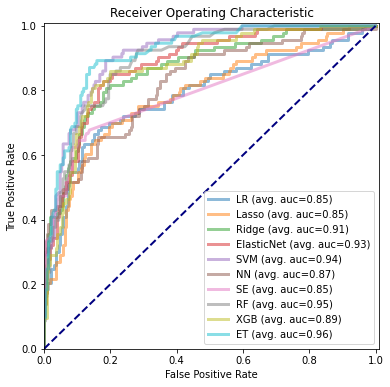

In [79]:
plt.figure(figsize=(6, 6))
for model in models:
    fpr, tpr, _ = roc_curve(y, agg_pred[model])
    plt.plot(fpr, tpr, lw=3, alpha=0.5, label='%s (avg. auc=%0.2f)' % (model, agg_perf.loc['mean',model]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

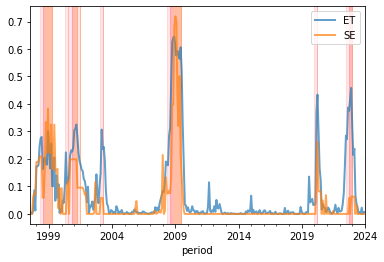

<Figure size 1728x432 with 0 Axes>

In [82]:
COMP_MODELS = ['ET', 'SE']
ax = agg_pred[COMP_MODELS].plot(lw=2, alpha=0.7)
render_crises(crises3, ax)

In [81]:
# preds 리스트에서 각 모델의 평균 예측값을 계산
model_avg_preds = {}
for model in models:
    model_avg_preds[model] = np.mean([pred[model] for pred in preds3], axis=0)

# 실제값은 모든 preds 요소에서 동일하므로 첫 번째 요소에서 가져옵니다.
actual = preds3[0]['actl']
actual = actual.astype(int)

# 각 모델에 대한 ROC AUC 점수를 계산하고 저장
individual_auc_scores = {model: roc_auc_score(actual, model_avg_preds[model]) for model in models}

# 모든 가능한 3개 모델 조합에 대한 ROC AUC 점수 계산
auc_scores = {}
for combination in combinations(models, 3):  # 여기를 수정함
    ensemble_pred = np.mean([model_avg_preds[model] for model in combination], axis=0)
    auc_score = roc_auc_score(actual, ensemble_pred)
    auc_scores[tuple(sorted(combination))] = auc_score  # 키를 정렬된 튜플로 저장

# 개별 모델 점수와 결합하여 모든 점수를 포함하도록 auc_scores 업데이트
auc_scores.update({(model,): score for model, score in individual_auc_scores.items()})

# ROC AUC 점수가 가장 높은 상위 5개 조합을 선택
top_5_com_c3 = sorted(auc_scores, key=auc_scores.get, reverse=True)[:5]
top_5_com_c3 += [('SE',),]
top_5_com_c3

[('ET',),
 ('ET', 'RF', 'SE'),
 ('ET', 'ElasticNet', 'RF'),
 ('ET', 'SE', 'XGB'),
 ('ET', 'RF', 'SVM'),
 ('SE',)]

### 6개월

In [311]:
models = ['LR', 'Lasso', 'Ridge', 'ElasticNet', 'SVM', 'NN', 'SE' ,'RF', 'XGB', 'ET']

In [312]:
with open('/home/work/modelhub/EWS/data/preds6.pkl', 'rb') as file:
    preds6 = pickle.load(file)    

In [313]:
#agg_perf = pd.DataFrame([pred.groupby('fold').apply(agg_auc).mean() for pred in preds6]).agg([np.mean, np.std])
#agg_perf.loc['std'] =  agg_perf.loc['std'] / np.sqrt(n_iter)
agg_perf = pd.DataFrame([pred.groupby('fold').apply(agg_auc).mean() for pred in preds6]).agg([np.mean]) # 
#agg_perf.loc['std'] =  agg_perf.loc['std'] / np.sqrt(n_iter)
display(agg_perf)
agg_pred = pd.concat([pred[models] for pred in preds6]).groupby(level=0).mean().set_index(X.index)

LR    Lasso     Ridge  ElasticNet       SVM        NN        SE  \
mean  0.764538  0.75192  0.860464    0.866889  0.915642  0.895871  0.841896   

            RF       XGB        ET  
mean  0.927374  0.907722  0.953194

In [314]:
# to see if the AUCs of two models are statistically significantly different
delong_roc_test(y, agg_pred['ET'], agg_pred['SE'])

Z score: 4.80, p-value: 0.00000


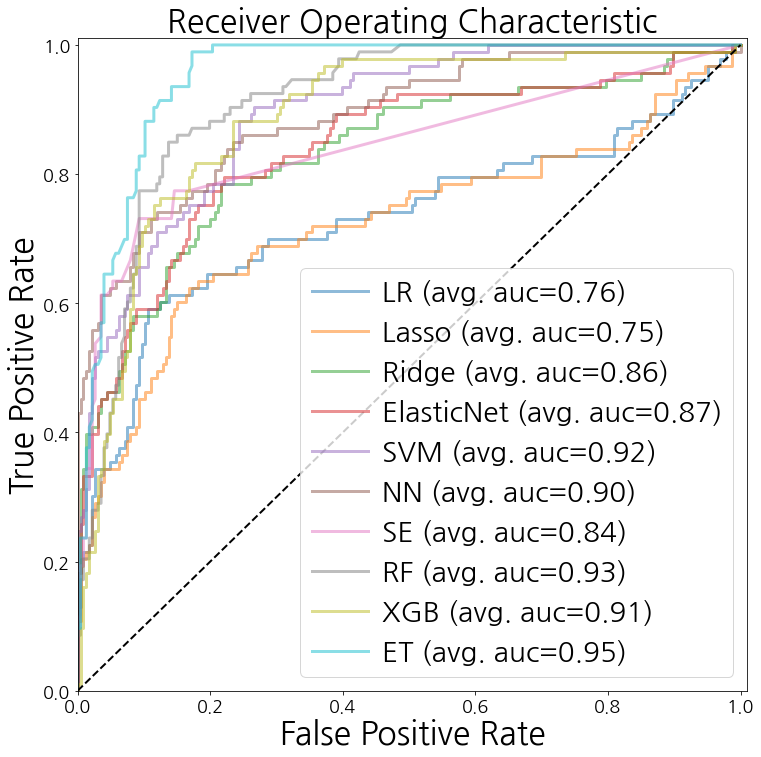

In [747]:
plt.figure(figsize=(12, 12))
for model in models:
    fpr, tpr, _ = roc_curve(y, agg_pred[model])
    plt.plot(fpr, tpr, lw=3, alpha=0.5, label='%s (avg. auc=%0.2f)' % (model, agg_perf.loc['mean',model]))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=32) 
plt.ylabel('True Positive Rate', fontsize=32) 
plt.title('Receiver Operating Characteristic', fontsize=32) 
plt.legend(loc='lower right', fontsize='small', prop={'size': 28}, handlelength=2, handletextpad=0.5, labelspacing=0.5)
plt.savefig('/home/work/modelhub/EWS/svg/그림7.svg', format='svg')
plt.show()

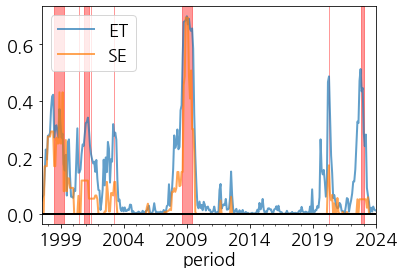

In [531]:
COMP_MODELS = ['ET', 'SE']
ax = agg_pred[COMP_MODELS].plot(lw=2, alpha=0.7)
render_crises(crises6, ax)

In [83]:
# preds 리스트에서 각 모델의 평균 예측값을 계산
model_avg_preds = {}
for model in models:
    model_avg_preds[model] = np.mean([pred[model] for pred in preds6], axis=0)

# 실제값은 모든 preds 요소에서 동일하므로 첫 번째 요소에서 가져옵니다.
actual = preds6[0]['actl']
actual = actual.astype(int)

# 각 모델에 대한 ROC AUC 점수를 계산하고 저장
individual_auc_scores = {model: roc_auc_score(actual, model_avg_preds[model]) for model in models}

# 모든 가능한 3개 모델 조합에 대한 ROC AUC 점수 계산
auc_scores = {}
for combination in combinations(models, 3):  # 여기를 수정함
    ensemble_pred = np.mean([model_avg_preds[model] for model in combination], axis=0)
    auc_score = roc_auc_score(actual, ensemble_pred)
    auc_scores[tuple(sorted(combination))] = auc_score  # 키를 정렬된 튜플로 저장

# 개별 모델 점수와 결합하여 모든 점수를 포함하도록 auc_scores 업데이트
auc_scores.update({(model,): score for model, score in individual_auc_scores.items()})

# ROC AUC 점수가 가장 높은 상위 5개 조합을 선택
top_5_com_c6 = sorted(auc_scores, key=auc_scores.get, reverse=True)[:5]
top_5_com_c6 +=[('SE',)]
top_5_com_c6

[('EXT',),
 ('EXT', 'RF', 'SE'),
 ('EXT', 'SE', 'XGB'),
 ('EXT', 'RF', 'SVM'),
 ('EXT', 'SVM', 'XGB'),
 ('SE',)]

### 9개월

In [85]:
with open('/home/work/modelhub/EWS/data/preds12.pkl', 'rb') as file:
    preds12 = pickle.load(file)    

In [86]:
agg_perf = pd.DataFrame([pred.groupby('fold').apply(agg_auc).mean() for pred in preds12]).agg([np.mean])#, np.std])
#agg_perf.loc['std'] =  agg_perf.loc['std'] / np.sqrt(n_iter)
display(agg_perf)
agg_pred = pd.concat([pred[models] for pred in preds12]).groupby(level=0).mean().set_index(X.index)

LR     Lasso     Ridge  ElasticNet       SVM        NN        SE  \
mean  0.805032  0.792843  0.866451    0.866571  0.947673  0.861716  0.848386   

            RF       XGB       EXT  
mean  0.929086  0.877671  0.963272

In [87]:
# to see if the AUCs of two models are statistically significantly different
delong_roc_test(y, agg_pred['EXT'], agg_pred['SE'])

Z score: 4.63, p-value: 0.00000


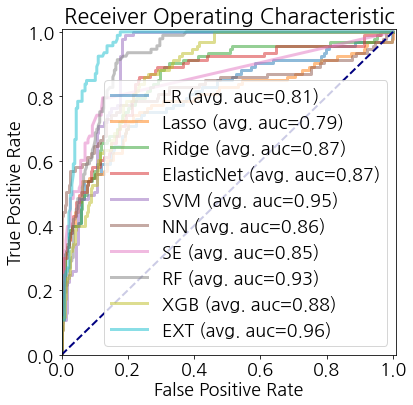

In [88]:
plt.figure(figsize=(6, 6))
for model in models:
    fpr, tpr, _ = roc_curve(y, agg_pred[model])
    plt.plot(fpr, tpr, lw=3, alpha=0.5, label='%s (avg. auc=%0.2f)' % (model, agg_perf.loc['mean',model]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

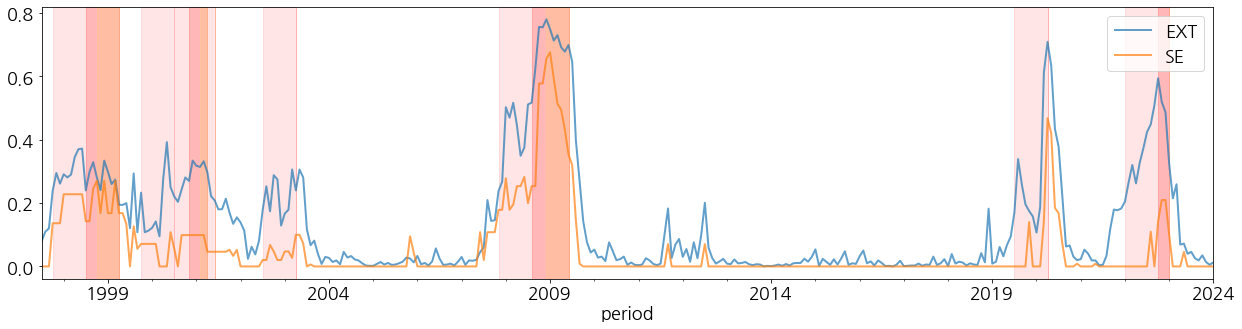

In [89]:
COMP_MODELS = ['EXT', 'SE']
ax = agg_pred[COMP_MODELS].plot(lw=2, alpha=0.7)
render_crises(crises12, ax)

In [90]:
# preds 리스트에서 각 모델의 평균 예측값을 계산
model_avg_preds = {}
for model in models:
    model_avg_preds[model] = np.mean([pred[model] for pred in preds12], axis=0)

# 실제값은 모든 preds 요소에서 동일하므로 첫 번째 요소에서 가져옵니다.
actual = preds12[0]['actl']
actual = actual.astype(int)

# 각 모델에 대한 ROC AUC 점수를 계산하고 저장
individual_auc_scores = {model: roc_auc_score(actual, model_avg_preds[model]) for model in models}

# 모든 가능한 3개 모델 조합에 대한 ROC AUC 점수 계산
auc_scores = {}
for combination in combinations(models, 3):  # 여기를 수정함
    ensemble_pred = np.mean([model_avg_preds[model] for model in combination], axis=0)
    auc_score = roc_auc_score(actual, ensemble_pred)
    auc_scores[tuple(sorted(combination))] = auc_score  # 키를 정렬된 튜플로 저장

# 개별 모델 점수와 결합하여 모든 점수를 포함하도록 auc_scores 업데이트
auc_scores.update({(model,): score for model, score in individual_auc_scores.items()})

# ROC AUC 점수가 가장 높은 상위 5개 조합을 선택
top_5_com_c12 = sorted(auc_scores, key=auc_scores.get, reverse=True)[:5]
top_5_com_c12 +=[ ('SE',)]
top_5_com_c12

[('EXT', 'SE', 'SVM'),
 ('EXT',),
 ('EXT', 'RF', 'SVM'),
 ('EXT', 'RF', 'SE'),
 ('RF', 'SE', 'SVM'),
 ('SE',)]

# 6-1 글로벌 금융위기

In [91]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')

"""
# 변수별 색상 및 이름 지정
variable_colors = {
    'res_sdebt_neg': 'darkred',
    'bank_lev_diff': 'red', #
    'bank_ldr_diff': 'salmon', #salmon
    'hc_gdp_diff': 'deeppink',
    'cc_gdp_diff': 'hotpink',
    'cd_sp_diff': 'navy',
    'cp_sp_diff': 'blue',
    'sr_sp_diff': 'royalblue',
    'tp_sp_neg_diff': 'steelblue',
    'stock_cmax': 'darkgreen',
    'bank_mv': 'green',
    'vix': 'mediumseagreen',
    'er_mv': 'limegreen',
    'kb_hp_pchg': 'palegreen',
    'gdp_growth_neg': 'turquoise' #'cyan',
}

variable_names = {
    'res_sdebt_neg': "외환보유액/단기외채",
    'bank_lev_diff': "은행 레버리지", 
    'bank_ldr_diff': "은행 예대율", 
    'hc_gdp_diff': "가계신용/GDP", 
    'cc_gdp_diff': "기업신용/GDP",
    'cd_sp_diff': "CD 스프레드",
    'cp_sp_diff': "CP 스프레드",
    'sr_sp_diff': "국가신용 스프레드",
    'tp_sp_neg_diff': "기간 프리미엄 스프레드",
    'stock_cmax': "KOSPI 지수 변동성(CMAX)",
    'bank_mv': "KOSPI 은행부문 변동성(GARCH)", 
    'vix': 'VIX',
    'er_mv': "환율 변동성",
    'kb_hp_pchg': "KB 주택매매가격지수",
    'gdp_growth_neg': "GDP 성장률"
}

ordered_vars = ['res_sdebt_neg', 'bank_lev_diff', 'bank_ldr_diff', 
                'hc_gdp_diff', 'cc_gdp_diff', 'cd_sp_diff', 'cp_sp_diff', 'sr_sp_diff', 
                'tp_sp_neg_diff', 'stock_cmax', 'bank_mv',  'vix','er_mv', 'kb_hp_pchg', 'gdp_growth_neg']
                """

In [748]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')


# 변수별 색상 및 이름 지정
variable_colors = {
    'res_sdebt_neg': 'darkred',
    'bank_lev_diff': 'darkred', #
    'bank_ldr_diff': 'darkred', #salmon
    'hc_gdp_diff': 'red',
    'cc_gdp_diff': 'red',
    'kb_hp_pchg': 'orange',
    'cd_sp_diff': 'navy',
    'cp_sp_diff': 'navy',
    'sr_sp_diff': 'navy',
    'tp_sp_neg_diff': 'navy',
    'stock_cmax': 'royalblue',
    'bank_mv': 'royalblue',
    'vix': 'royalblue',
    'er_mv': 'royalblue',
    'gdp_growth_neg': 'darkgreen' #'cyan',
}

variable_names = {
    'res_sdebt_neg': "자금조달",
    'bank_lev_diff': "자금조달", 
    'bank_ldr_diff': "자금조달", 
    'hc_gdp_diff': "레버리지", 
    'cc_gdp_diff': "레버리지",
    'kb_hp_pchg': "자산가격",
    'cd_sp_diff': "금리",
    'cp_sp_diff': "금리",
    'sr_sp_diff': "금리",
    'tp_sp_neg_diff': "금리",
    'stock_cmax': "변동성",
    'bank_mv': "변동성", 
    'vix': '변동성',
    'er_mv': "변동성",
    'gdp_growth_neg': "경기"
}

ordered_vars = ['res_sdebt_neg', 'bank_lev_diff', 'bank_ldr_diff', 
                'hc_gdp_diff', 'cc_gdp_diff', 'kb_hp_pchg', 'cd_sp_diff', 'cp_sp_diff', 'sr_sp_diff', 
                'tp_sp_neg_diff', 'stock_cmax', 'bank_mv',  'vix','er_mv', 'gdp_growth_neg']
                

In [749]:
def train_models(nameset, classifiers, params, X, y):
    # train individual models
    for name in set([name for names in nameset for name in names]):
        model = classifiers[name]
        model.set_params(**params[name])
        model.fit(X, y)
    # list up model combinations
    models = {}
    for names in nameset:
        if len(names) == 1:
            name = names[0]
            model = classifiers[name]
        else:
            estimators = [(name, classifiers[name]) for name in names]
            name = ' + '.join(names)
            model = VotingClassifier(estimators=estimators, voting='soft')
            model.estimators_ = [classifiers[name] for name in names]
        models[name] = model
    return models

In [750]:
def predict_single(model, X, scaler, decompose=False):
    results = []
    contributions = []
    X_scaled = scaler.transform(X)
    for time_idx, time in enumerate(X.index):
        X_origin = X_scaled[time_idx, :].reshape(1, -1)
        original_prob = model.predict_proba(X_origin)[:, 1][0]
        results.append({
            'time_period': time.strftime('%Y-%m-%d'),
            'predicted_probability': original_prob
        })
        if decompose and time_idx > 0:
            for col_idx, col in enumerate(X.columns):
                X_modified = np.copy(X_origin)
                X_modified[0, col_idx] = X_scaled[time_idx-1, col_idx]
                modified_prob = model.predict_proba(X_modified)[:, 1][0]
                impact = original_prob - modified_prob
                contributions.append({
                    'time_period': time.strftime('%Y-%m-%d'),
                    'variable': col,
                    'original_prob_value': original_prob,
                    'modified_prob_value': modified_prob,
                    'impact': impact
                })
    return results, contributions

In [159]:
"""
def plot_predicted(ax, results_df, crises, title='', ylabel=''):
    colors = plt.cm.tab10.colors  
    
    for idx, model_name in enumerate(results_df['model'].unique()):
        model_df = results_df[results_df['model'] == model_name]
        ax.plot(pd.to_datetime(model_df['time_period']), model_df['predicted_probability'], 
                label=model_name, color=colors[idx % len(colors)], linewidth=2)

    ax.set_ylim(0, 1)
    render_crises(crises, ax=ax, fsi_plot=False, crises_plot=True)
    ax.set_xlim([pd.to_datetime(results_df['time_period'].min()), 
                 pd.to_datetime(results_df['time_period'].max())])
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.legend(title='Models')
    if title != '':
        ax.set_title(title)
    if ylabel != '':
        ax.set_ylabel('Predicted Probability')
        """

"\ndef plot_predicted(ax, results_df, crises, title='', ylabel=''):\n    colors = plt.cm.tab10.colors  \n    \n    for idx, model_name in enumerate(results_df['model'].unique()):\n        model_df = results_df[results_df['model'] == model_name]\n        ax.plot(pd.to_datetime(model_df['time_period']), model_df['predicted_probability'], \n                label=model_name, color=colors[idx % len(colors)], linewidth=2)\n\n    ax.set_ylim(0, 1)\n    render_crises(crises, ax=ax, fsi_plot=False, crises_plot=True)\n    ax.set_xlim([pd.to_datetime(results_df['time_period'].min()), \n                 pd.to_datetime(results_df['time_period'].max())])\n    ax.xaxis.set_major_locator(mdates.MonthLocator())\n    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))\n    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)\n    ax.legend(title='Models')\n    if title != '':\n        ax.set_title(title)\n    if ylabel != '':\n        ax.set_ylabel('Predicted Probability')\n        "

In [751]:
## 수정함
def plot_predicted(ax, results_df, crises, title='', ylabel=''):
    # EXT 모델에 대한 색상을 직접 지정
    model_colors = {'ET': 'black'}
    model_colors = {'SE': 'black'}
    default_colors = plt.cm.tab10.colors  # 기본 색상 배열
    
    for idx, model_name in enumerate(results_df['model'].unique()):
        model_df = results_df[results_df['model'] == model_name]
        # EXT 모델에 대해서는 검정색을 사용, 그 외에는 기본 색상 배열에서 선택
        color = model_colors.get(model_name, default_colors[idx % len(default_colors)])
        ax.plot(pd.to_datetime(model_df['time_period']), model_df['predicted_probability'], 
                label=model_name, color=color, linewidth=2)

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.2)) 
    render_crises(crises, ax=ax, fsi_plot=False, crises_plot=True)
    ax.set_xlim([pd.to_datetime(results_df['time_period'].min()), 
                 pd.to_datetime(results_df['time_period'].max())])
    
    # 연도의 마지막 두 자리와 분기별 월(3, 6, 9, 12)만 나타나도록 설정
    #ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3, 6, 9, 12)))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))  # 연도의 마지막 두 자리
    #plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.set_xticklabels([])
    ax.legend(loc='upper left', frameon=False)
    if title != '':
        ax.set_title(title)
    if ylabel != '':
        ax.set_ylabel('Predicted Probability')


In [1004]:
mean_value = agg_pred['ET'].mean()
median_value = agg_pred['ET'].median()
perc70 = agg_pred['ET'].quantile(0.7)
perc90 = agg_pred['ET'].quantile(0.9)
perc50 = agg_pred['ET'].quantile(0.5)

print("Mean:", mean_value)
print("Median:", median_value)
print("70th Percentile:", perc70)
print("90th Percentile:", perc90)

Mean: 0.1120062695924765
Median: 0.029
70th Percentile: 0.14299999999999996
90th Percentile: 0.3144


In [1097]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_predicted(ax, results_df, crises, title='', ylabel=''):
    # 모델에 대한 색상 및 선 스타일을 직접 지정
    model_styles = {
        'ET': {'color': 'black', 'linestyle': '-'},
        'SE': {'color': 'black', 'linestyle': '--'}  # 검정색 점선으로 설정
    }
    default_colors = plt.cm.tab10.colors  # 기본 색상 배열
    
    for idx, model_name in enumerate(results_df['model'].unique()):
        model_df = results_df[results_df['model'] == model_name]
        # 각 모델에 대한 색상 및 선 스타일을 가져오거나 기본값을 사용
        style = model_styles.get(model_name, {'color': default_colors[idx % len(default_colors)], 'linestyle': '-'})
        ax.plot(pd.to_datetime(model_df['time_period']), model_df['predicted_probability'], 
                label=model_name, color=style['color'], linestyle=style['linestyle'], linewidth=2)

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.2)) 
    render_crises(crises, ax=ax, fsi_plot=False, crises_plot=True)
    ax.set_xlim([pd.to_datetime(results_df['time_period'].min()), 
                 pd.to_datetime(results_df['time_period'].max())])
    ax.axhline(perc70, color='dimgrey', linestyle='--', lw=1.5 )#, label='70th')
    ax.axhline(perc90, color='dimgrey',  linestyle=':',  lw=1.5 )#, label='90th')
    
    ax.set_xticklabels([])
    ax.legend(loc='upper left', frameon=False)
    if title != '':
        ax.set_title(title)
    if ylabel != '':
        ax.set_ylabel('Predicted Probability')

# 예시 사용을 위해 필요한 다른 함수 및 데이터 정의가 필요할 수 있음


In [1005]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_predicted(ax, results_df, crises, title='', ylabel=''):
    # 모델에 대한 색상 및 선 스타일을 직접 지정
    model_styles = {
        'ET': {'color': 'black', 'linestyle': '-'},
        'SE': {'color': 'black', 'linestyle': '--'}  # 검정색 점선으로 설정
    }
    default_colors = plt.cm.tab10.colors  # 기본 색상 배열
    
    for idx, model_name in enumerate(results_df['model'].unique()):
        model_df = results_df[results_df['model'] == model_name]
        # 각 모델에 대한 색상 및 선 스타일을 가져오거나 기본값을 사용
        style = model_styles.get(model_name, {'color': default_colors[idx % len(default_colors)], 'linestyle': '-'})
        ax.plot(pd.to_datetime(model_df['time_period']), model_df['predicted_probability'], 
                label=model_name, color=style['color'], linestyle=style['linestyle'], linewidth=2)

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.2)) 
    ax.tick_params(axis='both', labelsize=18)
    render_crises(crises, ax=ax, fsi_plot=False, crises_plot=True)
    ax.set_xlim([pd.to_datetime(results_df['time_period'].min()), 
                 pd.to_datetime(results_df['time_period'].max())])
    
    ax.set_xticklabels([])
    ax.axhline(perc70, color='dimgrey', linestyle='--', lw=1.5 )#, label='70th')
    ax.axhline(perc90, color='dimgrey',  linestyle=':',  lw=1.5 )#, label='90th')
    #ax.axhline(perc50, color='dimgrey',  linestyle='-',  lw=1.5 )#, label='90th')
    
    #ax.axhline(perc95, color='black',  linestyle=':',  lw=1.5 )#, label='90th')
    #ax.axhline(perc99, color='black',  linestyle=':',  lw=1.5 )#, label='90th')
    #ax.legend(loc='upper left', frameon=False)
    ax.legend(loc='upper left', frameon=False, fontsize=18)
    if title != '':
        ax.set_title(title)
    if ylabel != '':
        ax.set_ylabel('Predicted Probability')

# 예시 사용을 위해 필요한 다른 함수 및 데이터 정의가 필요할 수 있음


In [1132]:
# 최종

def plot_predicted(ax, results_df, crises, title='', ylabel=''):
    # 모델에 대한 색상 및 선 스타일을 직접 지정
    model_styles = {
        'ET': {'color': 'black', 'linestyle': '-'},
        'SE': {'color': 'black', 'linestyle': '--'}  # 검정색 점선으로 설정
    }
    default_colors = plt.cm.tab10.colors  # 기본 색상 배열
    
    for idx, model_name in enumerate(results_df['model'].unique()):
        model_df = results_df[results_df['model'] == model_name]
        # 각 모델에 대한 색상 및 선 스타일을 가져오거나 기본값을 사용
        style = model_styles.get(model_name, {'color': default_colors[idx % len(default_colors)], 'linestyle': '-'})
        ax.plot(pd.to_datetime(model_df['time_period']), model_df['predicted_probability'], 
                label=model_name, color=style['color'], linestyle=style['linestyle'], linewidth=2)

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    render_crises(crises, ax=ax, fsi_plot=False, crises_plot=True)
    ax.set_xlim([pd.to_datetime(results_df['time_period'].min()), 
                 pd.to_datetime(results_df['time_period'].max())])
    ax.axhline(perc70, color='dimgrey', linestyle='--', lw=1.5)
    ax.axhline(perc90, color='dimgrey', linestyle=':', lw=1.5)

    # X축 틱 설정 - 매달 틱을 표시
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # 매달 틱을 표시
    ax.set_xticklabels([])  # X축 틱 레이블 제거

    # 주요 분기별 틱 (3, 6, 9, 12월)을 진하게 설정
    #ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(3, 6, 9, 12)))
    #ax.tick_params(axis='x', which='minor', width=4)  # 진한 틱 설정
    ax.tick_params(axis='y', labelsize=20)
    # 모든 틱 위치를 오른쪽으로 약간 이동
    new_tick_locations = [date + timedelta(days=20) for date in mdates.num2date(ax.get_xticks())]
    ax.set_xticks(new_tick_locations)

    ax.legend(loc='upper left', frameon=False, fontsize=18)
    if title != '':
        ax.set_title(title, fontsize=20)
    if ylabel != '':
        ax.set_ylabel(ylabel, fontsize=20)

# 주의: 'render_crises', 'perc70', 'perc90' 등은 코드 상에서 정의되거나 데이터가 제공


In [161]:
"""
def plot_decomposed(ax, contributions_df, y_bottom=-1, y_top=1, title=''):
    contributions_df['time_period'] = pd.to_datetime(contributions_df['time_period'])
    sorted_df = contributions_df.sort_values(by=['time_period', 'variable'])

    time_periods = sorted_df['time_period'].dt.to_pydatetime()
    unique_time_periods = sorted_df['time_period'].unique()

    for date_idx, date in enumerate(unique_time_periods):
        bottom_pos = 0  # 양의 기여도 누적값
        bottom_neg = 0  # 음의 기여도 누적값
        for var in ordered_vars:
            contribution = sorted_df[(sorted_df['time_period'] == date) & (sorted_df['variable'] == var)]['impact'].values[0]
            if contribution > 0:
                ax.bar(date_idx, contribution, bottom=bottom_pos, color=variable_colors[var], width=0.4)
                bottom_pos += contribution
            else:
                ax.bar(date_idx, contribution, bottom=bottom_neg, color=variable_colors[var], width=0.4)
                bottom_neg += contribution

    ax.set_ylim(max(y_bottom*1.2, -1), min(y_top*1.2, 1))
    ax.axhline(0, color='black', linewidth=1)
    ax.set_xlabel('기간')
    ax.set_ylabel('기여도')
    if title != '':
        ax.set_title(f'기간별 요인분해: {title}')
    ax.set_xticks(range(len(unique_time_periods)))
    #ax.set_xticklabels([pd.to_datetime(date).strftime('%Y-%m') for date in unique_time_periods], rotation=45)
    ax.set_xticklabels([pd.to_datetime(date).strftime('%Y') for date in unique_time_periods], rotation=45)
    """

"\ndef plot_decomposed(ax, contributions_df, y_bottom=-1, y_top=1, title=''):\n    contributions_df['time_period'] = pd.to_datetime(contributions_df['time_period'])\n    sorted_df = contributions_df.sort_values(by=['time_period', 'variable'])\n\n    time_periods = sorted_df['time_period'].dt.to_pydatetime()\n    unique_time_periods = sorted_df['time_period'].unique()\n\n    for date_idx, date in enumerate(unique_time_periods):\n        bottom_pos = 0  # 양의 기여도 누적값\n        bottom_neg = 0  # 음의 기여도 누적값\n        for var in ordered_vars:\n            contribution = sorted_df[(sorted_df['time_period'] == date) & (sorted_df['variable'] == var)]['impact'].values[0]\n            if contribution > 0:\n                ax.bar(date_idx, contribution, bottom=bottom_pos, color=variable_colors[var], width=0.4)\n                bottom_pos += contribution\n            else:\n                ax.bar(date_idx, contribution, bottom=bottom_neg, color=variable_colors[var], width=0.4)\n                bottom

In [753]:
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
from pandas.tseries.offsets import DateOffset 

def plot_decomposed(ax, contributions_df, y_bottom=-1, y_top=1, title=''):
    contributions_df['time_period'] = pd.to_datetime(contributions_df['time_period'])
    sorted_df = contributions_df.sort_values(by=['time_period', 'variable'])
    unique_time_periods = sorted_df['time_period'].unique()

    legend_handles = []
    legend_labels = []
    xticklabels = []

    bar_width = 0.4  # 막대 너비

    for date_idx, date in enumerate(unique_time_periods):
        date_idx = date_idx + 0.5  # 막대 중심을 위치시키기
        bottom_pos = 0
        bottom_neg = 0
        for var in ordered_vars:
            contribution = sorted_df[(sorted_df['time_period'] == date) & (sorted_df['variable'] == var)]['impact'].values[0]
            if contribution > 0:
                ax.bar(date_idx, contribution, bottom=bottom_pos, color=variable_colors[var], width=bar_width)
                bottom_pos += contribution
            else:
                ax.bar(date_idx, contribution, bottom=bottom_neg, color=variable_colors[var], width=bar_width)
                bottom_neg += contribution
            if var not in legend_labels:
                legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=variable_colors[var]))
                legend_labels.append(variable_names[var])

    ax.set_ylim([max(y_bottom*1.2, -1), min(y_top*1.2, 1)])
    ax.axhline(0, color='black', linewidth=1)
    #ax.set_xlim([0, len(unique_time_periods)])
    #ax.set_xticks([i + 0.5 for i in range(len(unique_time_periods))])  # 눈금을 막대 중심에 맞춤    
    ax.set_xlim([0 - bar_width / 2, len(unique_time_periods) - bar_width / 2])

    #ax.set_xticks([i for i in range(len(unique_time_periods))])
    ax.set_xticks([i + 0.5 for i in range(len(unique_time_periods))]) 

    for date in unique_time_periods:
        timestamp = pd.Timestamp(date)
        xticklabels.append(timestamp.strftime('%b\n%y') if timestamp.month in [3, 6, 9, 12] else '')
    ax.set_xticklabels(xticklabels, rotation=0, fontsize=20)
    ax.tick_params(axis='y', labelsize=20)

    # 범례 설정
    specific_indices = [0, 6, 4, 10, 5, 14]
    specific_indices = [i for i in specific_indices if i < len(legend_handles)]
    legend_handles_specific = [legend_handles[i] for i in specific_indices]
    legend_labels_specific = [legend_labels[i] for i in specific_indices]
    ax.legend(legend_handles_specific, legend_labels_specific, loc='lower center', bbox_to_anchor=(0.5, -0.8), fontsize=18, ncol=3, frameon=False, columnspacing=0.5)


In [754]:
classifiers3 = {
    'ET': ExtraTreesClassifier(),
    'SE': SignalExtraction()
    #'RF': RandomForestClassifier(criterion='entropy'),
    #'XGB': XGBClassifier(eval_metric='logloss'),
    #'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True),
    #    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    #'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),  # Ridge 추가
    #'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5)
    #'NN': KerasClassifier(model=build_NN, units=10, features=15, verbose=0), 
}

classifiers6 = {
    'ET': ExtraTreesClassifier(),
    'SE': SignalExtraction()
    #'RF': RandomForestClassifier(criterion='entropy'),
    #'XGB': XGBClassifier(eval_metric='logloss'),
    #'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True),
    #    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    #'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),  # Ridge 추가
    #'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5)
  #  'NN': KerasClassifier(model=build_NN, units=10, features=15, verbose=0),
}

classifiers12 = {
    'ET': ExtraTreesClassifier(),
    'SE': SignalExtraction()
    #'RF': RandomForestClassifier(criterion='entropy'),
    #'XGB': XGBClassifier(eval_metric='logloss'),
    #'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True),
    #    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    #'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),  # Ridge 추가
    #'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5)
   # 'NN': KerasClassifier(model=build_NN, units=10, features=15, verbose=0),
}

In [755]:
top_5_com_c3 = [('ET',), ('SE',)]
top_5_com_c6 = [('ET',), ('SE',)]
top_5_com_c12 = [('ET',), ('SE',)]


In [756]:
model_nameset = [top_5_com_c3, top_5_com_c6, top_5_com_c12]
classifier_set = [classifiers3, classifiers6, classifiers12]
params_set = [params3, params6, params12]
crises_set = [crises3, crises6, crises12]

In [757]:
def batch_train(train_from, train_to, predict_from, predict_to):
    model_set = []
    scaler_set = []
    for crises, model_names, classifiers, params in zip(crises_set, model_nameset, classifier_set, params_set):
        X_train, y_train, _, excluded = get_data(data[x_cols], crises, train_from, train_to)
        excluded[predict_from:predict_to] = 1
        X_train = X_train[excluded == 0]
        y_train = y_train[excluded == 0]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        models = train_models(model_names, classifiers, params, X_train_scaled, y_train)    

        model_set.append(models)
        scaler_set.append(scaler)
    return model_set, scaler_set

In [1140]:
def batch_predict(predict_from, predict_to):
    result_set = []
    for models, scaler, crises in tqdm(zip(model_set, scaler_set, crises_set)):
        X_test, y_test, _, _ = get_data(data[x_cols], crises, predict_from, predict_to)
        results_df = pd.DataFrame()
        for model in models.items():
            print(model[0])
            result, _ = predict_single(model[1], X_test, scaler)
            result_df = pd.DataFrame(result)
            result_df['model'] = model[0]
            results_df = results_df.append(result_df)
        result_set.append(results_df)
        
    _, axes = plt.subplots(1, len(result_set), figsize=(20, 4) )#, sharey=True)
    for ax, results_df, crises in zip(axes, result_set, crises_set):
        plot_predicted(ax, results_df, crises)
    plt.tight_layout()
    plt.savefig('/home/work/modelhub/EWS/svg/그림10-1.svg', format='svg')
    plt.show()
    
    return result_set



In [765]:
# import matplotlib.pyplot as plt
# import pandas as pd

# def batch_decompose(decompose_model, predict_from, predict_to):
#     contribution_set = []
#     for models, scaler, crises in zip(model_set, scaler_set, crises_set):    
#         X_test, _, _, _ = get_data(data[x_cols], crises, predict_from, predict_to)
#         _, contributions = predict_single(models[decompose_model], X_test, scaler, decompose=True)
#         contributions_df = pd.DataFrame(contributions)
#         contribution_set.append(contributions_df)

#     max_top = max((df[df['impact'] >= 0].groupby('time_period').sum()['impact'].max() for df in contribution_set), default=0)
#     min_bottom = min((df[df['impact'] < 0].groupby('time_period').sum()['impact'].min() for df in contribution_set), default=0)

#     fig, axes = plt.subplots(1, len(contribution_set), figsize=(28, 4))
#     #plt.subplots_adjust(bottom=0.4)  # 더 많은 하단 여백을 제공합니다.
        
#     #plt.subplots_adjust(bottom=0.3, wspace=0.25)   # 하단 여백 증가
#     plt.subplots_adjust(bottom=0.3)

#     for ax, contributions_df in zip(axes, contribution_set):
#         plot_decomposed(ax, contributions_df, min_bottom, max_top)

#     handles, labels = axes[-1].get_legend_handles_labels()
#     #fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=14, ncol=3, frameon=False)

#     #plt.tight_layout()
#     plt.savefig('/home/work/modelhub/EWS/svg/그림8-2.svg', format='svg', bbox_extra_artists=(legend,), bbox_inches='tight')
#     plt.show()
#     return contribution_set


In [1139]:
import matplotlib.pyplot as plt
import pandas as pd

def batch_decompose(decompose_model, predict_from, predict_to):
    contribution_set = []
    for models, scaler, crises in zip(model_set, scaler_set, crises_set):    
        X_test, _, _, _ = get_data(data[x_cols], crises, predict_from, predict_to)
        _, contributions = predict_single(models[decompose_model], X_test, scaler, decompose=True)
        contributions_df = pd.DataFrame(contributions)
        contribution_set.append(contributions_df)

    max_top = max((df[df['impact'] >= 0].groupby('time_period').sum()['impact'].max() for df in contribution_set), default=0)
    min_bottom = min((df[df['impact'] < 0].groupby('time_period').sum()['impact'].min() for df in contribution_set), default=0)

    fig, axes = plt.subplots(1, len(contribution_set), figsize=(28, 4), dpi=300)
    plt.subplots_adjust(bottom=0.2)  # Adjust the bottom

    for ax, contributions_df in zip(axes, contribution_set):
        plot_decomposed(ax, contributions_df, min_bottom, max_top)

    handles, labels = axes[-1].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), fontsize=14, ncol=3, frameon=False)

    # Adjust layout to make room for the legend:
    plt.subplots_adjust(bottom=0.3)  # Adjust the bottom to make room for the legend

    # Save the figure
    #fig.savefig('/home/work/modelhub/EWS/svg/그림8-2.svg', format='svg', bbox_inches='tight')
    fig.savefig('/home/work/modelhub/EWS/svg/그림10-2.pdf', format='pdf', bbox_inches='tight')

    plt.show()
    return contribution_set


#### 위기발생 가능성 그래프

In [1129]:
train_from = '1997-07-01'
train_to = '2006-12-31'
predict_from = '2007-01-01'
predict_to = '2008-12-31'

model_set, scaler_set = batch_train(train_from, train_to, predict_from, predict_to)

0it [00:00, ?it/s]

ET
SE
ET
SE
ET
SE


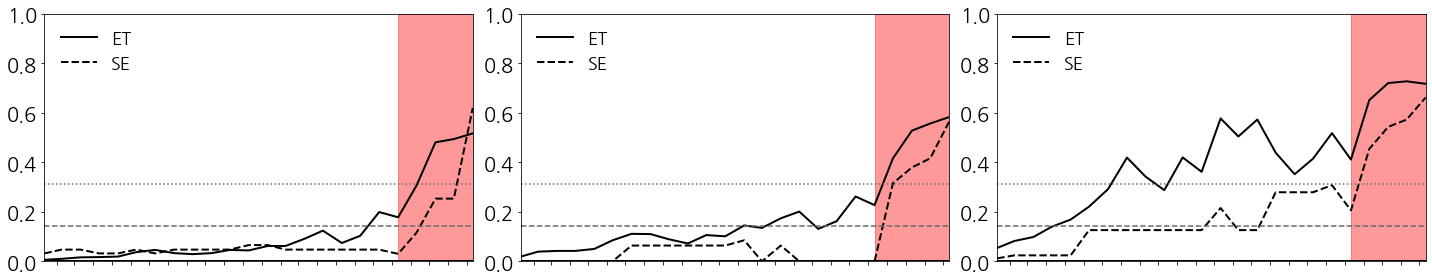

In [1133]:
predicted_set = batch_predict(predict_from, predict_to)
#decompose_model = 'EXT'
#decomposed_set = batch_decompose(decompose_model, predict_from, predict_to)

#### 요인분해 그래프

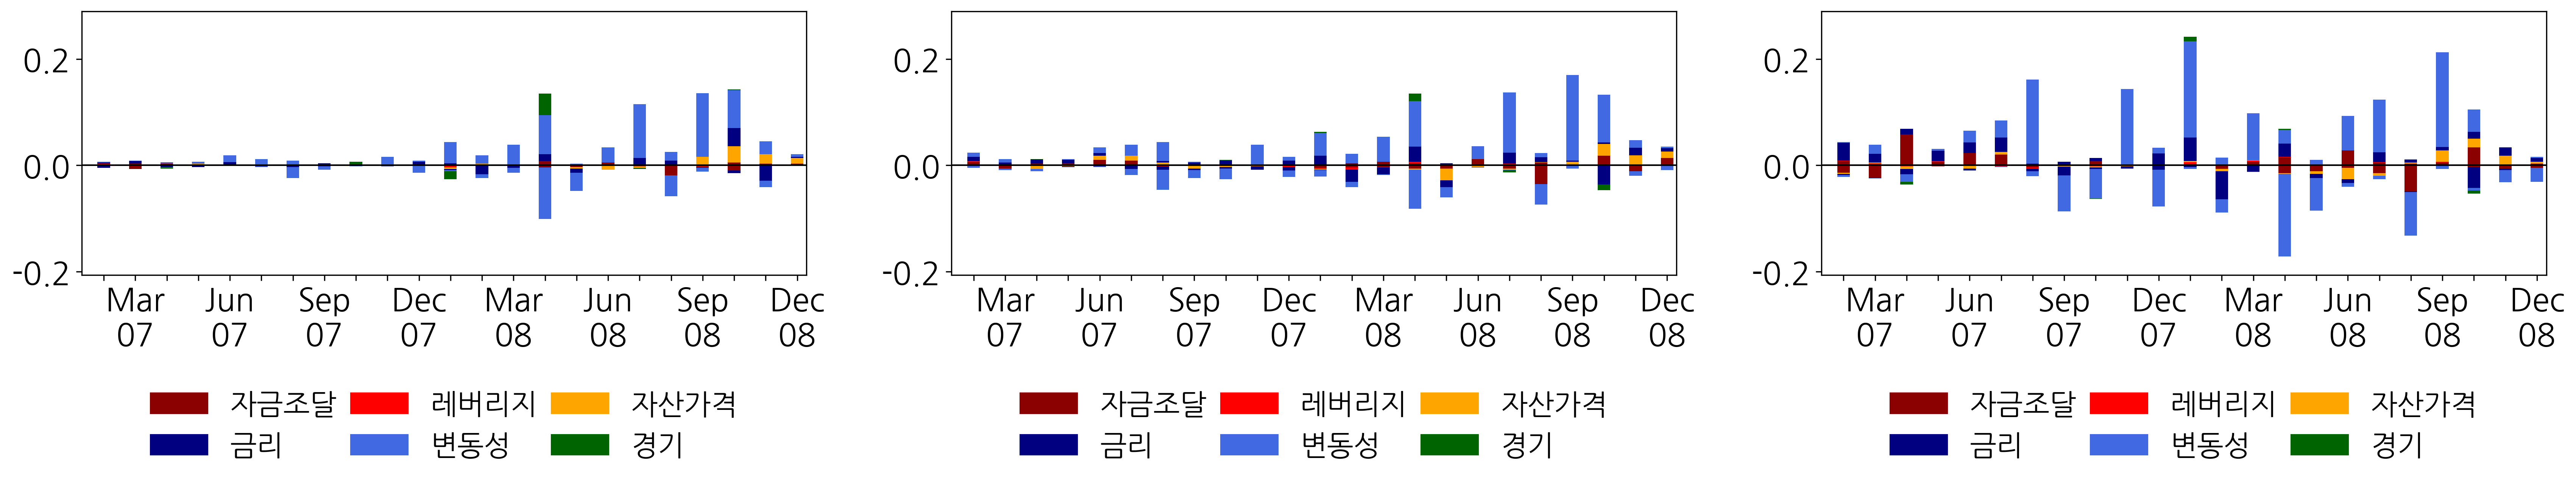

In [1131]:
decompose_model = 'ET'
decomposed_set = batch_decompose(decompose_model, predict_from, predict_to)

# 6.2 - Forecasting

### 코로나 19 - Walk forward prediction

In [1136]:
train_from = '1997-07-01'
train_to = '2018-09-30'
predict_from = '2018-10-01'
predict_to = '2020-05-31'

model_set, scaler_set = batch_train(train_from, train_to, predict_from, predict_to)

#### 위기발생 가능성 그래프

0it [00:00, ?it/s]

ET
SE
ET
SE
ET
SE


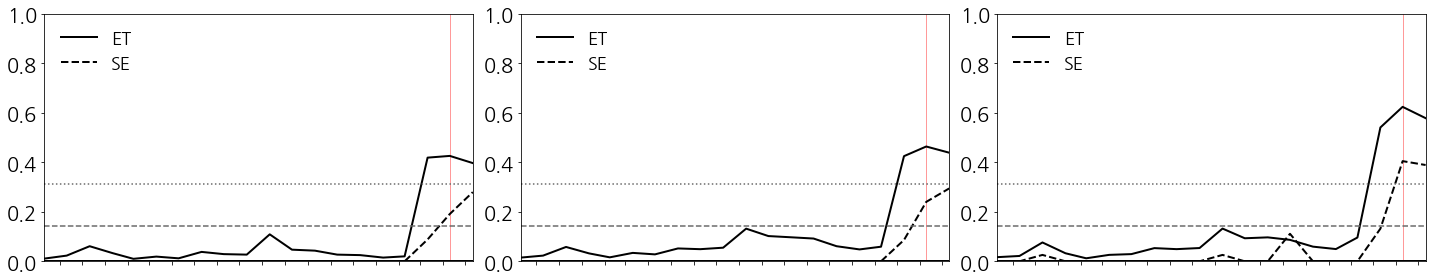

In [1137]:
predicted_set = batch_predict(predict_from, predict_to)

#### 요인분해 그래프

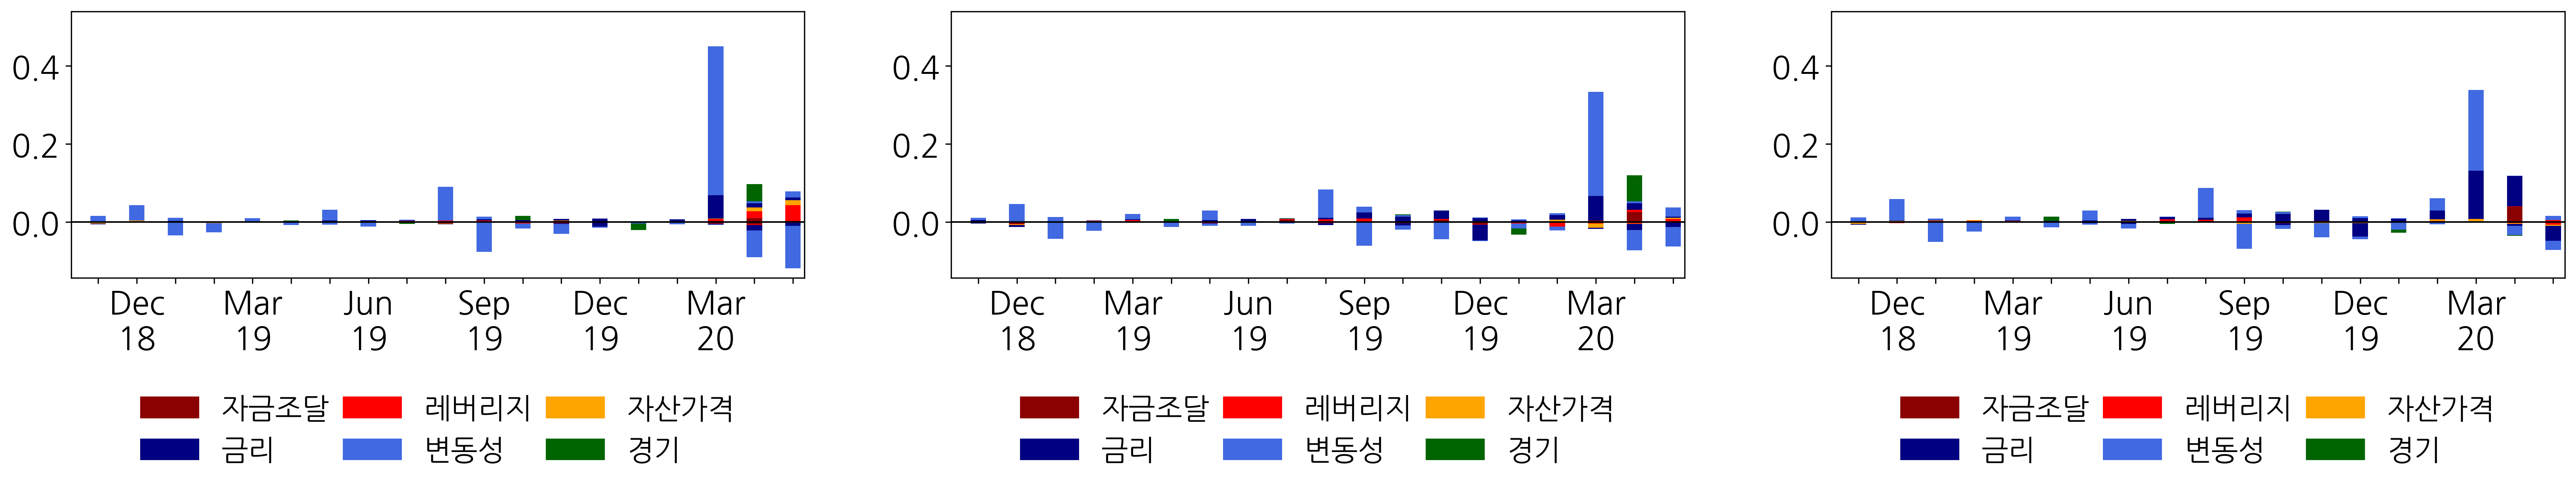

In [1138]:
decompose_model = 'ET'
decomposed_set = batch_decompose(decompose_model, predict_from, predict_to)

### 레고랜드 - Walk forward prediction

In [1141]:
train_from = '1997-07-01'
train_to = '2021-06-30'
predict_from = '2021-07-01'
predict_to = '2023-01-31'

model_set, scaler_set = batch_train(train_from, train_to, predict_from, predict_to)

#### 위기발생 가능성 그래프

0it [00:00, ?it/s]

ET
SE
ET
SE
ET
SE


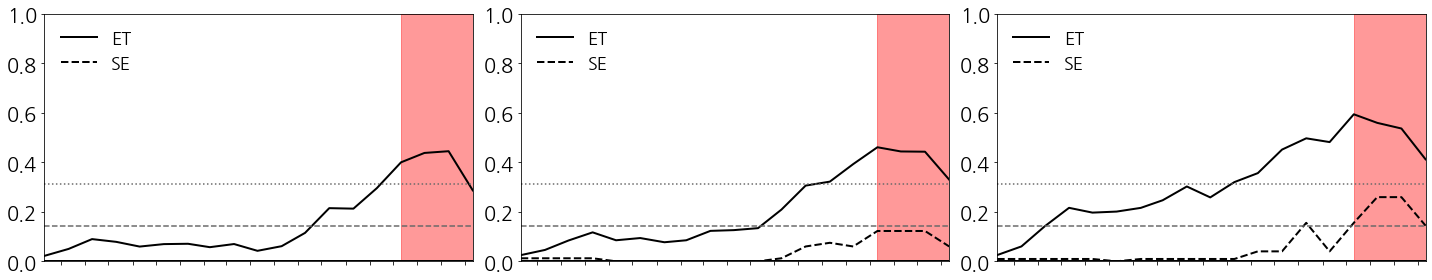

In [1142]:
predicted_set = batch_predict(predict_from, predict_to)

#### 요인분해 그래프

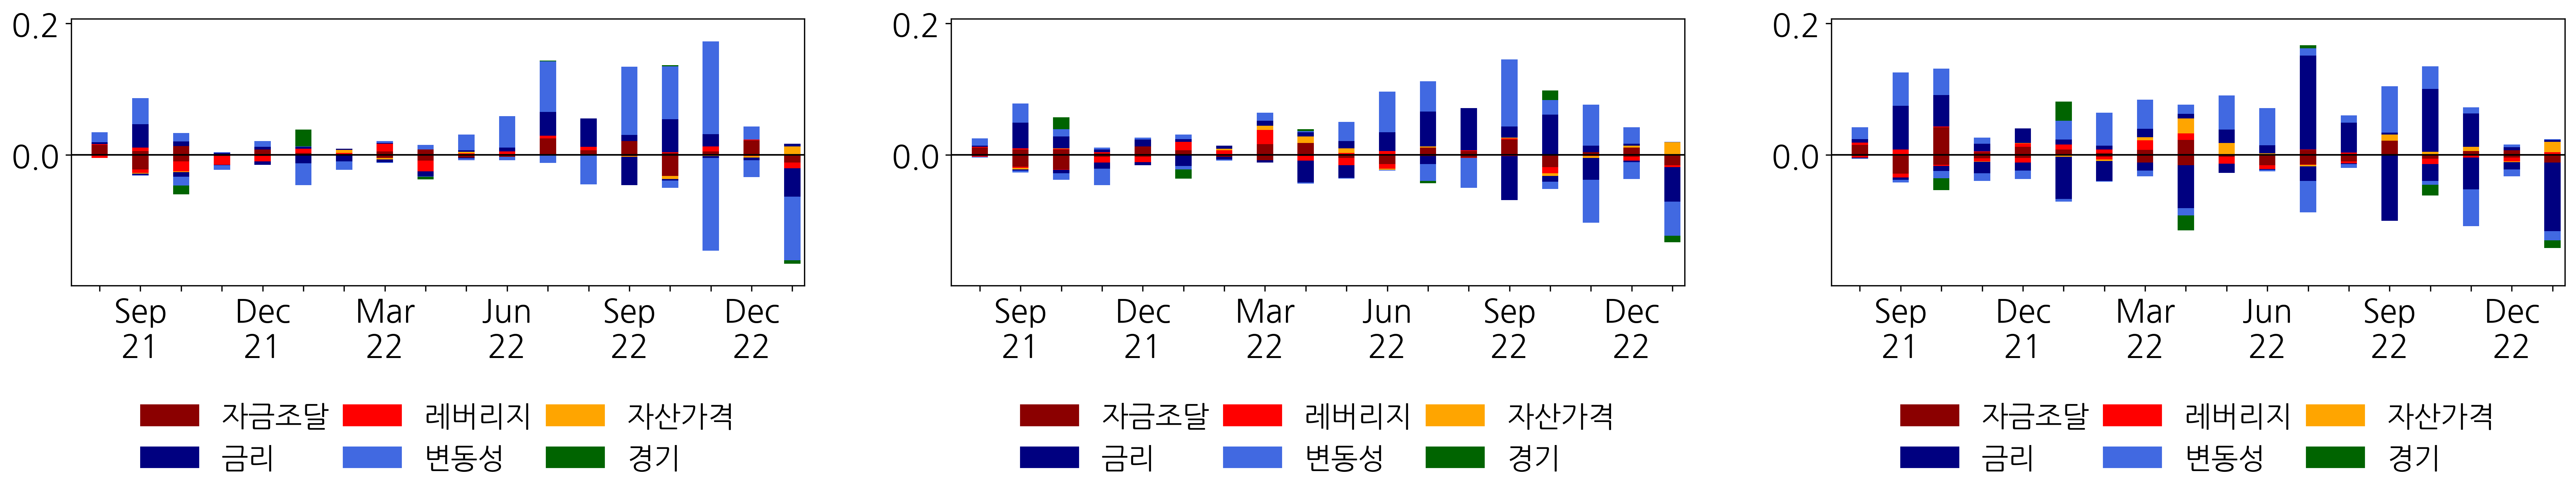

In [1143]:
decompose_model = 'ET'
decomposed_set = batch_decompose(decompose_model, predict_from, predict_to)

### 현재

In [1155]:
train_from = '1997-07-01'
train_to = '2023-03-30'
predict_from = '2023-04-01'
predict_to = '2024-04-21'

model_set, scaler_set = batch_train(train_from, train_to, predict_from, predict_to)

0it [00:00, ?it/s]

ET
SE
ET
SE
ET
SE


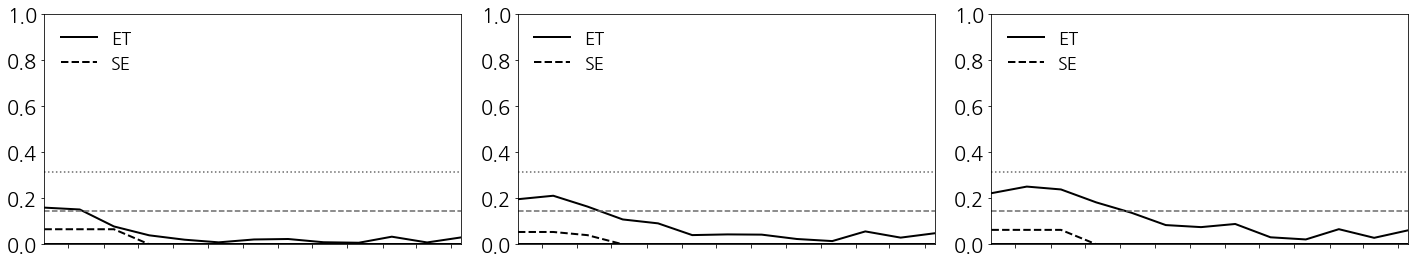

In [1156]:
predicted_set = batch_predict(predict_from, predict_to)

In [1186]:
predicted_set

[   time_period  predicted_probability model
 0   2023-04-30               0.159353    ET
 1   2023-05-31               0.151300    ET
 2   2023-06-30               0.077586    ET
 3   2023-07-31               0.039000    ET
 4   2023-08-31               0.020000    ET
 5   2023-09-30               0.008500    ET
 6   2023-10-31               0.021000    ET
 7   2023-11-30               0.023000    ET
 8   2023-12-31               0.009000    ET
 9   2024-01-31               0.006754    ET
 10  2024-02-29               0.033050    ET
 11  2024-03-31               0.008050    ET
 12  2024-04-30               0.030050    ET
 0   2023-04-30               0.065454    SE
 1   2023-05-31               0.065454    SE
 2   2023-06-30               0.065454    SE
 3   2023-07-31               0.000000    SE
 4   2023-08-31               0.000000    SE
 5   2023-09-30               0.000000    SE
 6   2023-10-31               0.000000    SE
 7   2023-11-30               0.000000    SE
 8   2023-

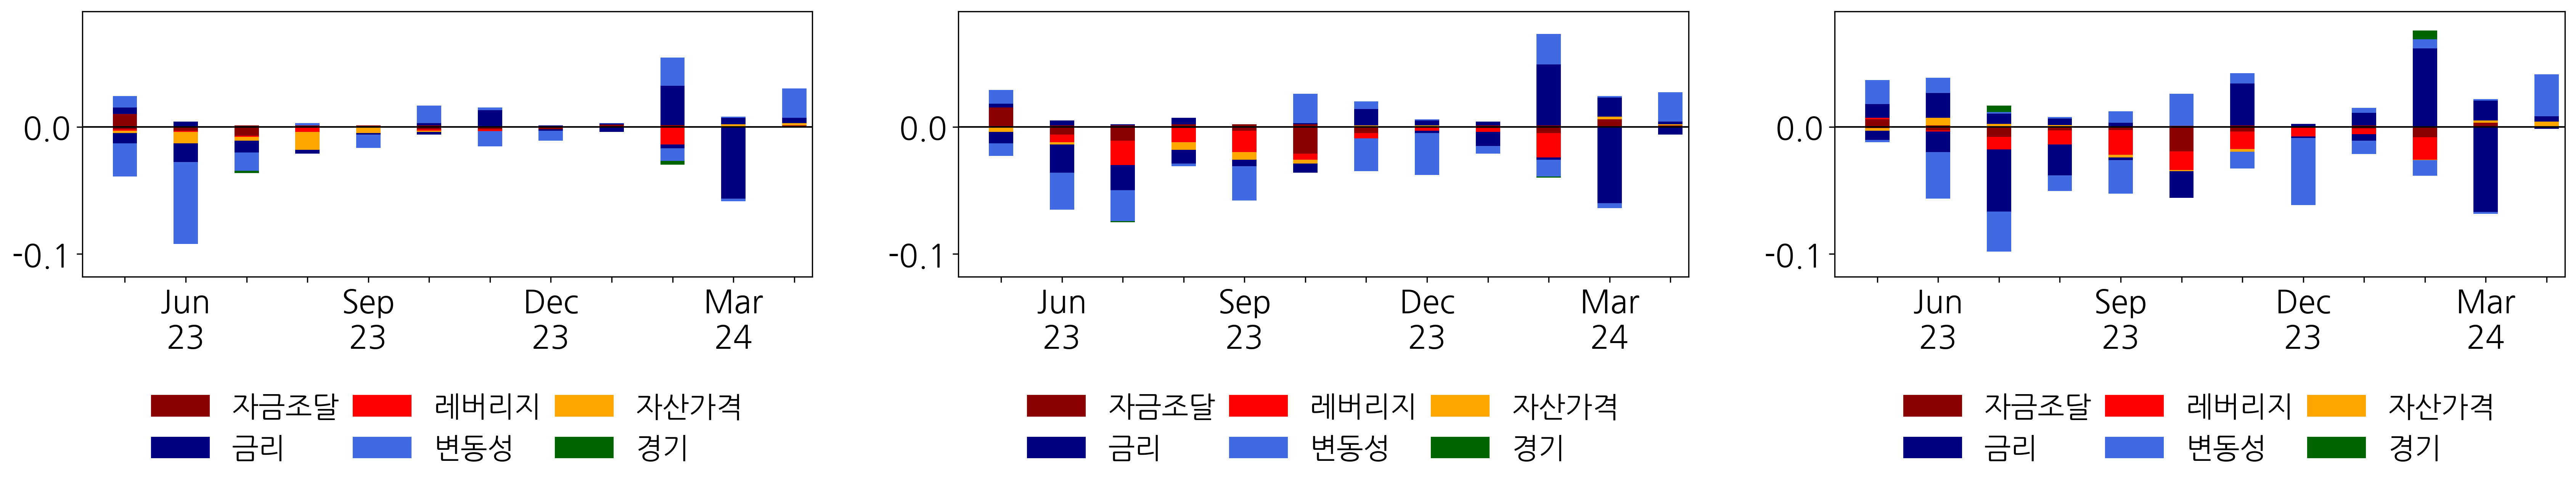

In [1157]:
decompose_model = 'ET'
decomposed_set = batch_decompose(decompose_model, predict_from, predict_to)

## 6.3 - PDP

### one-way

In [741]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
model = model_classifiers['ET']  # 실제 모델 인스턴스화 및 설정 필요
model.set_params(**params6['ET'])
range_from = '1997-07-01'  #@param {type: 'date'}
range_to = '2024-01-31'  #@param {type: 'date'}
group_bgn_ext = 3  #@param {type: 'integer'}
group_end_ext = 3  #@param {type: 'integer'}
exclude_post_crises = True #@param {type: 'boolean'}
x_cols = ['er_mv', 'vix', 'cp_sp_diff', 'sr_sp_diff', 'gdp_growth_neg', 'res_sdebt_neg',
          'bank_lev_diff', 'bank_mv', 'bank_ldr_diff', 'cd_sp_diff', 'tp_sp_neg_diff',
          'kb_hp_pchg', 'stock_cmax', 'hc_gdp_diff', 'cc_gdp_diff']

if 'NN' in models:
    _ = model_classifiers['NN'].set_params(features=len(x_cols))

data = pd.read_pickle('/home/work/modelhub/EWS/data/data.pkl')
X, y, groups, post_crises = get_data(data[x_cols], crises, range_from, range_to, group_bgn_ext, group_end_ext)
X_scaled = scaler.fit_transform(X)
model.fit(X_scaled, y)

Group   4: 1997-07 ~ 1999-07
Group  10: 1999-07 ~ 2001-09
Group  23: 2002-04 ~ 2003-07
Group  78: 2007-08 ~ 2009-09
Group 199: 2019-04 ~ 2020-07
Group 220: 2021-10 ~ 2023-04


ExtraTreesClassifier(max_depth=30, max_features=3, n_estimators=1000)

In [742]:
variable_names = {
    'res_sdebt_neg': "단기외채 비율",
    'bank_lev_diff': "은행 레버리지", 
    'bank_ldr_diff': "은행 예대율", 
    'hc_gdp_diff': "가계신용/GDP", 
    'cc_gdp_diff': "기업신용/GDP",
    'cd_sp_diff': "CD 스프레드",
    'cp_sp_diff': "CP 스프레드",
    'sr_sp_diff': "국가신용 스프레드",
    'tp_sp_neg_diff': "기간 프리미엄 스프레드",
    'stock_cmax': "KOSPI 변동성",
    'bank_mv': "은행지수 변동성", 
    'vix': 'VIX',
    'er_mv': "환율 변동성",
    'kb_hp_pchg': "주택가격",
    'gdp_growth_neg': "GDP 성장률"
}

In [743]:
# 특성 중요도를 기반으로 상위 15개 특성 추출
feature_importances = model.feature_importances_
top_15_feature_indices = np.argsort(feature_importances)[-15:]
top_15_features = [x_cols[i] for i in top_15_feature_indices]

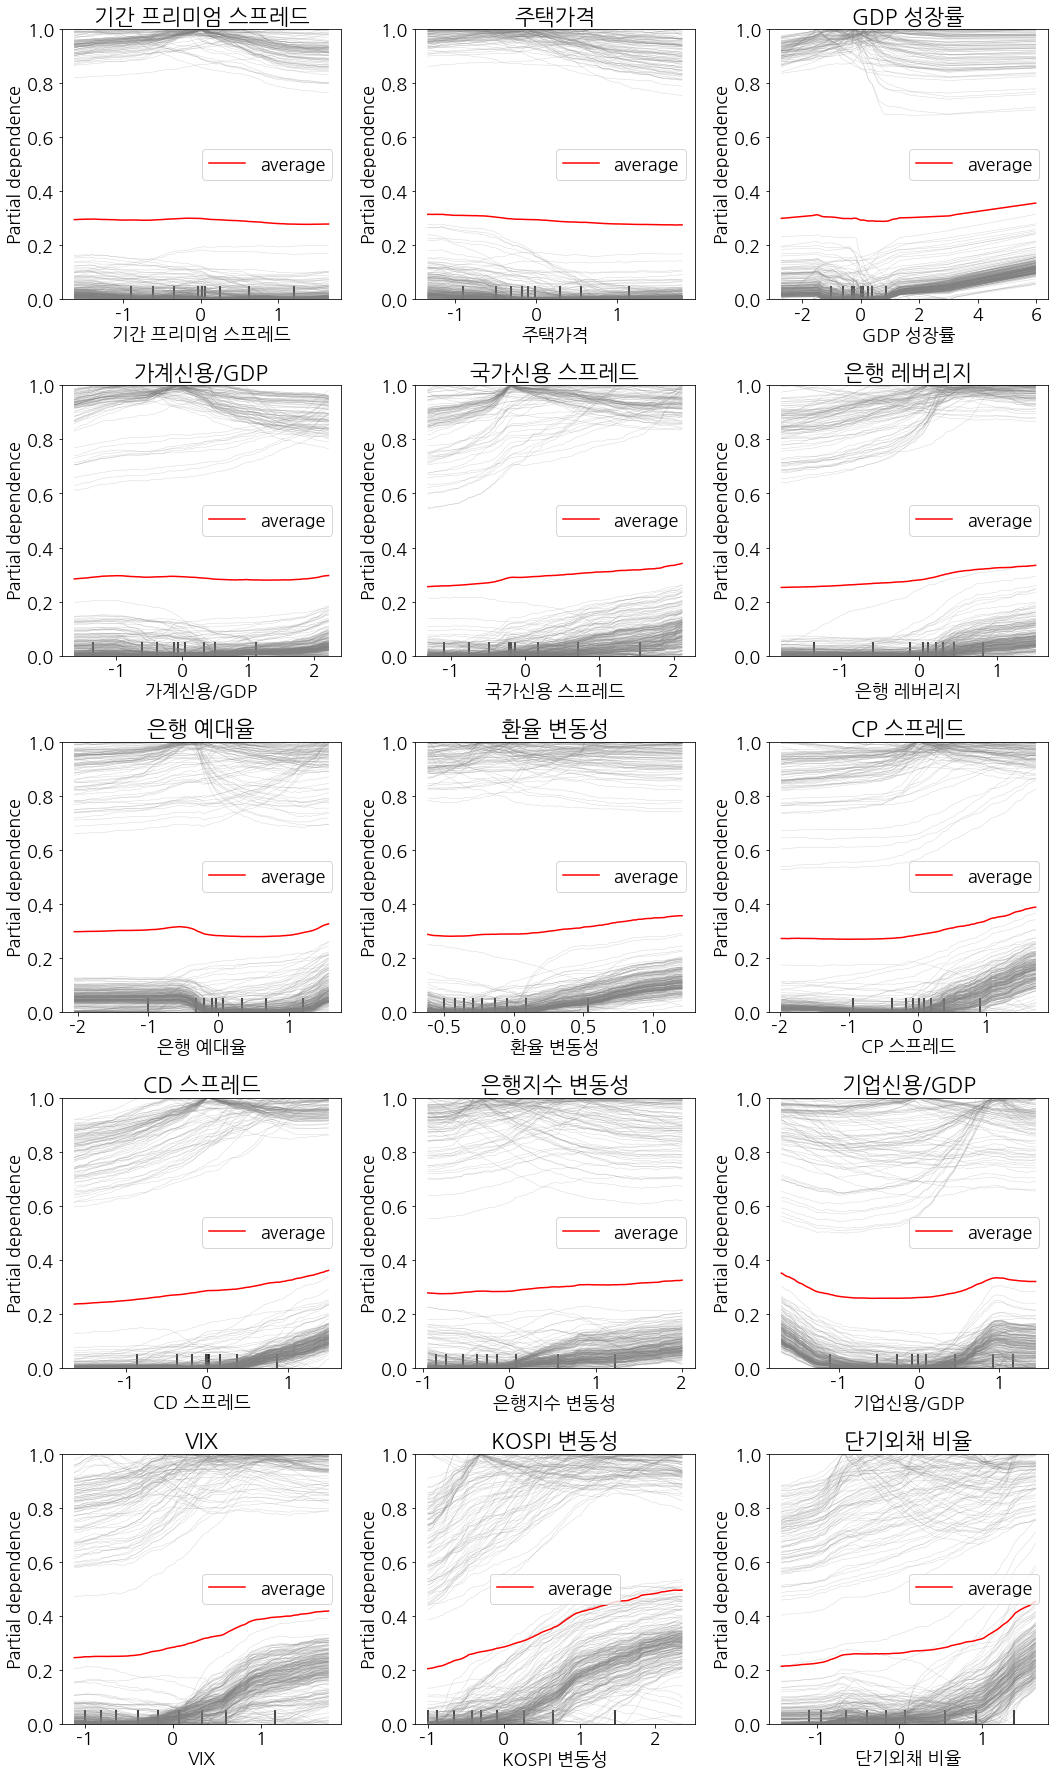

In [744]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# 영문 변수명 목록(x_cols)을 한글 변수명 목록으로 변환
x_cols_kr = [variable_names.get(col, col) for col in x_cols]

# PDP 그리기
fig, axs = plt.subplots(5, 3, figsize=(15, 25))  # 5행 3열 구조로 축 배열 생성
axs = axs.flatten()

for i, feature in enumerate(top_15_features):
    feature_kr = variable_names.get(feature, feature)  # 한글 변수명으로 변환
    feature_index = x_cols.index(feature)  # 영문 변수명을 기반으로 인덱스 검색

    pdp_display = PartialDependenceDisplay.from_estimator(
        model,
        X_scaled,
        features=[feature_index],  # 특성의 인덱스를 사용
        feature_names=x_cols_kr,  # 한글 변수명 목록 사용
        kind="both",
        ice_lines_kw={"color": "gray", "alpha": 0.3},
        pd_line_kw={"color": "red"},
        ax=axs[i]
    )
    axs[i].set_title(feature_kr)  # 플롯 제목을 한글 변수명으로 설정
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
    legend = axs[i].get_legend()
    if legend:
        legend.remove()
    if legend:
        legend.set_visible(False)
        
plt.tight_layout()
plt.savefig('/home/work/modelhub/EWS/svg/부록4.svg', format='svg')
plt.show()


### two-way

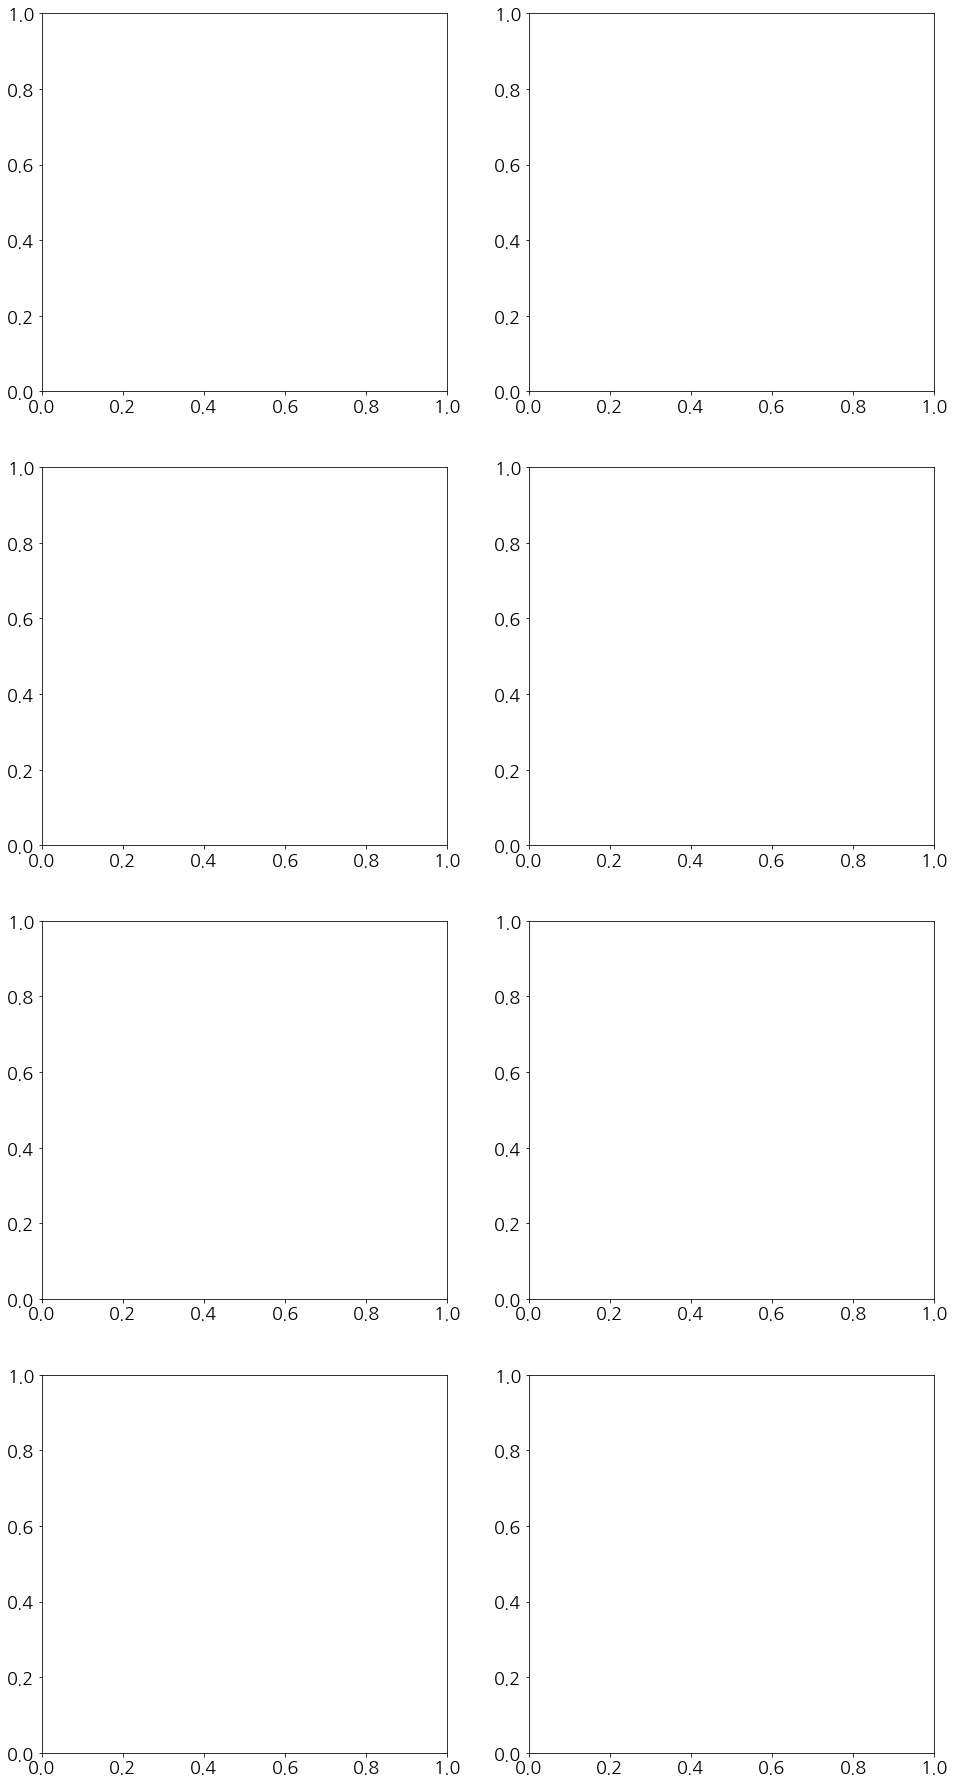

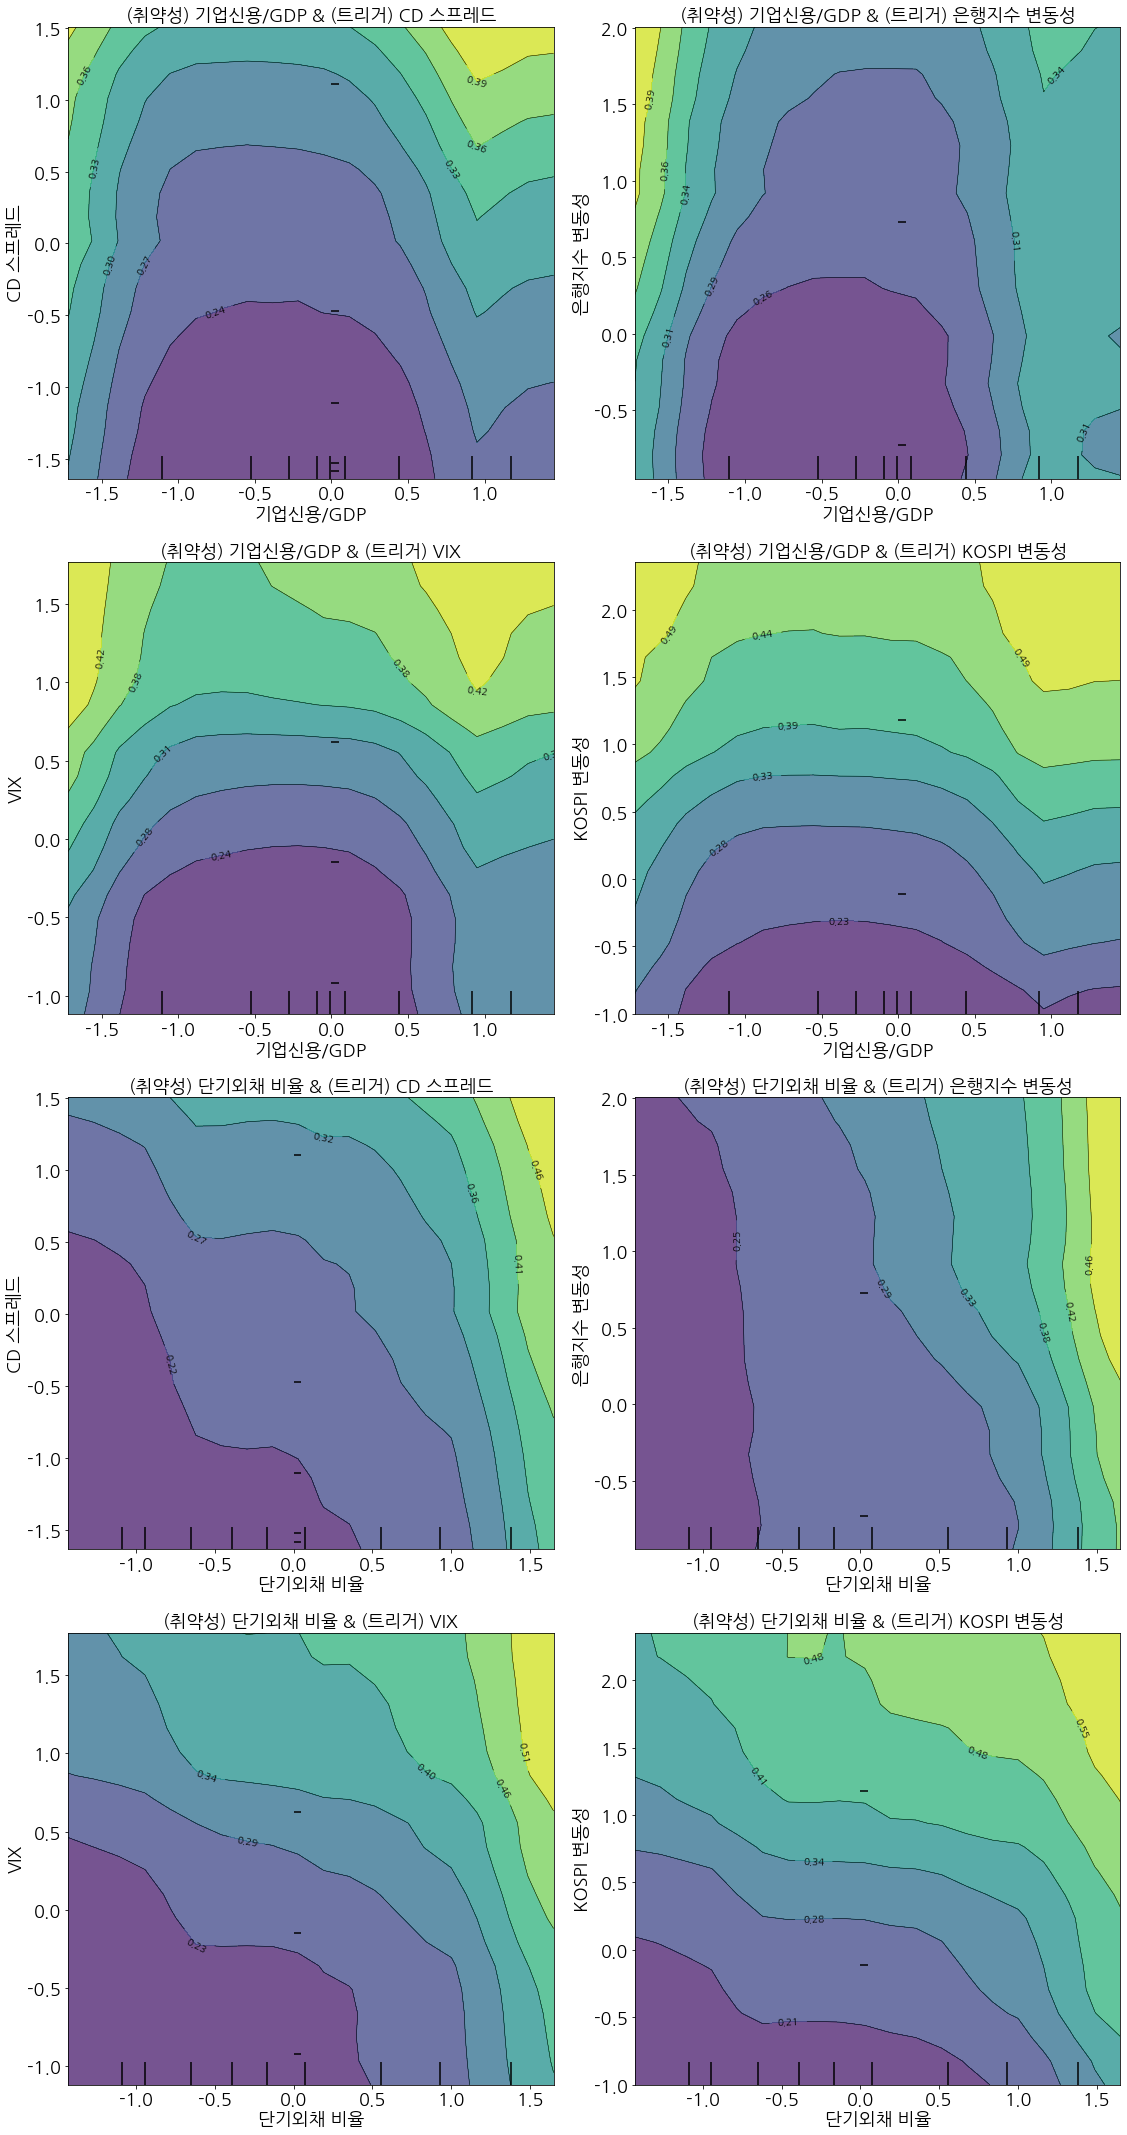

In [746]:
# 필요한 라이브러리 임포트
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')

# 취약성과 트리거 분류
vulnerability = {
    'res_sdebt_neg': "단기외채 비율",
    'bank_lev_diff': "은행 레버리지",
    'bank_ldr_diff': "은행 예대율",
    'hc_gdp_diff': "가계신용/GDP",
    'cc_gdp_diff': "기업신용/GDP",
        'kb_hp_pchg': "주택가격"
}

trigger = {
    #'kb_hp_pchg': "주택가격",
    'stock_cmax': "KOSPI 변동성",
    'bank_mv': "은행지수 변동성",
    'cp_sp_diff': "CP 스프레드",
    'sr_sp_diff': "국가 신용 스프레드",
    'tp_sp_neg_diff': "기간 프리미엄 스프레드",
    'cd_sp_diff': "CD 스프레드",
    'er_mv': "환율 변동성",
    'vix': "VIX",
    'gdp_growth_neg': "GDP 성장률"
}

top_features = [x_cols[i] for i in np.argsort(feature_importances)[-6:]]  # 먼저 상위 6개 특성 선정
top_vulnerability_features = [feat for feat in top_features if feat in vulnerability.keys()]
top_trigger_features = [feat for feat in top_features if feat in trigger.keys()]

# 취약성과 트리거 조합 생성
top_feature_combinations = [(vul, trg) for vul in top_vulnerability_features for trg in top_trigger_features]
top_feature_combinations_kr = [(vulnerability[vul], trigger[trg]) for vul, trg in top_feature_combinations]


# 영문명에서 한글명으로의 매핑 생성
all_features_kr = {**vulnerability, **trigger}  # 취약성과 트리거 모두 포함
x_cols_kr = [all_features_kr.get(col, col) for col in x_cols]

# 필요한 행의 수 계산 및 플롯 초기화
rows = np.ceil(len(top_feature_combinations) / 2).astype(int)
fig, axs = plt.subplots(rows, 2, figsize=(16, 32)) 

top_feature_combinations_indices = [(
    x_cols.index(vul),  # 취약성 특성의 인덱스
    x_cols.index(trg)   # 트리거 특성의 인덱스
) for vul, trg in top_feature_combinations]

top_feature_combinations_kr = [(
    all_features_kr[vul],  # 취약성 특성의 한글명 재설정
    all_features_kr[trg]   # 트리거 특성의 한글명 재설정
) for vul, trg in top_feature_combinations]

# 필요한 행의 수 계산 및 플롯 초기화
rows = np.ceil(len(top_feature_combinations_indices) / 2).astype(int)
fig, axs = plt.subplots(rows, 2, figsize=(16, 30))
for i, ((vul_idx, trg_idx), (vul_kr, trg_kr)) in enumerate(zip(top_feature_combinations_indices, top_feature_combinations_kr)):
    row = i // 2
    col = i % 2
    ax = axs[row, col] if rows > 1 else axs[col]
    
    # Two-way PDP 그리기, 인덱스 사용
    plot_partial_dependence(
        model,
        X_scaled, 
        features=[(vul_idx, trg_idx)],  # 인덱스 조합 사용
        ax=ax,
        grid_resolution=20,
        kind='average',
        feature_names=x_cols_kr,  # 한글 변수명 목록 사용
    )
    ax.set_title(f'(취약성) {vul_kr} & (트리거) {trg_kr}', fontsize=18)

plt.tight_layout()
plt.savefig('/home/work/modelhub/EWS/svg/부록5.svg', format='svg')
plt.show()

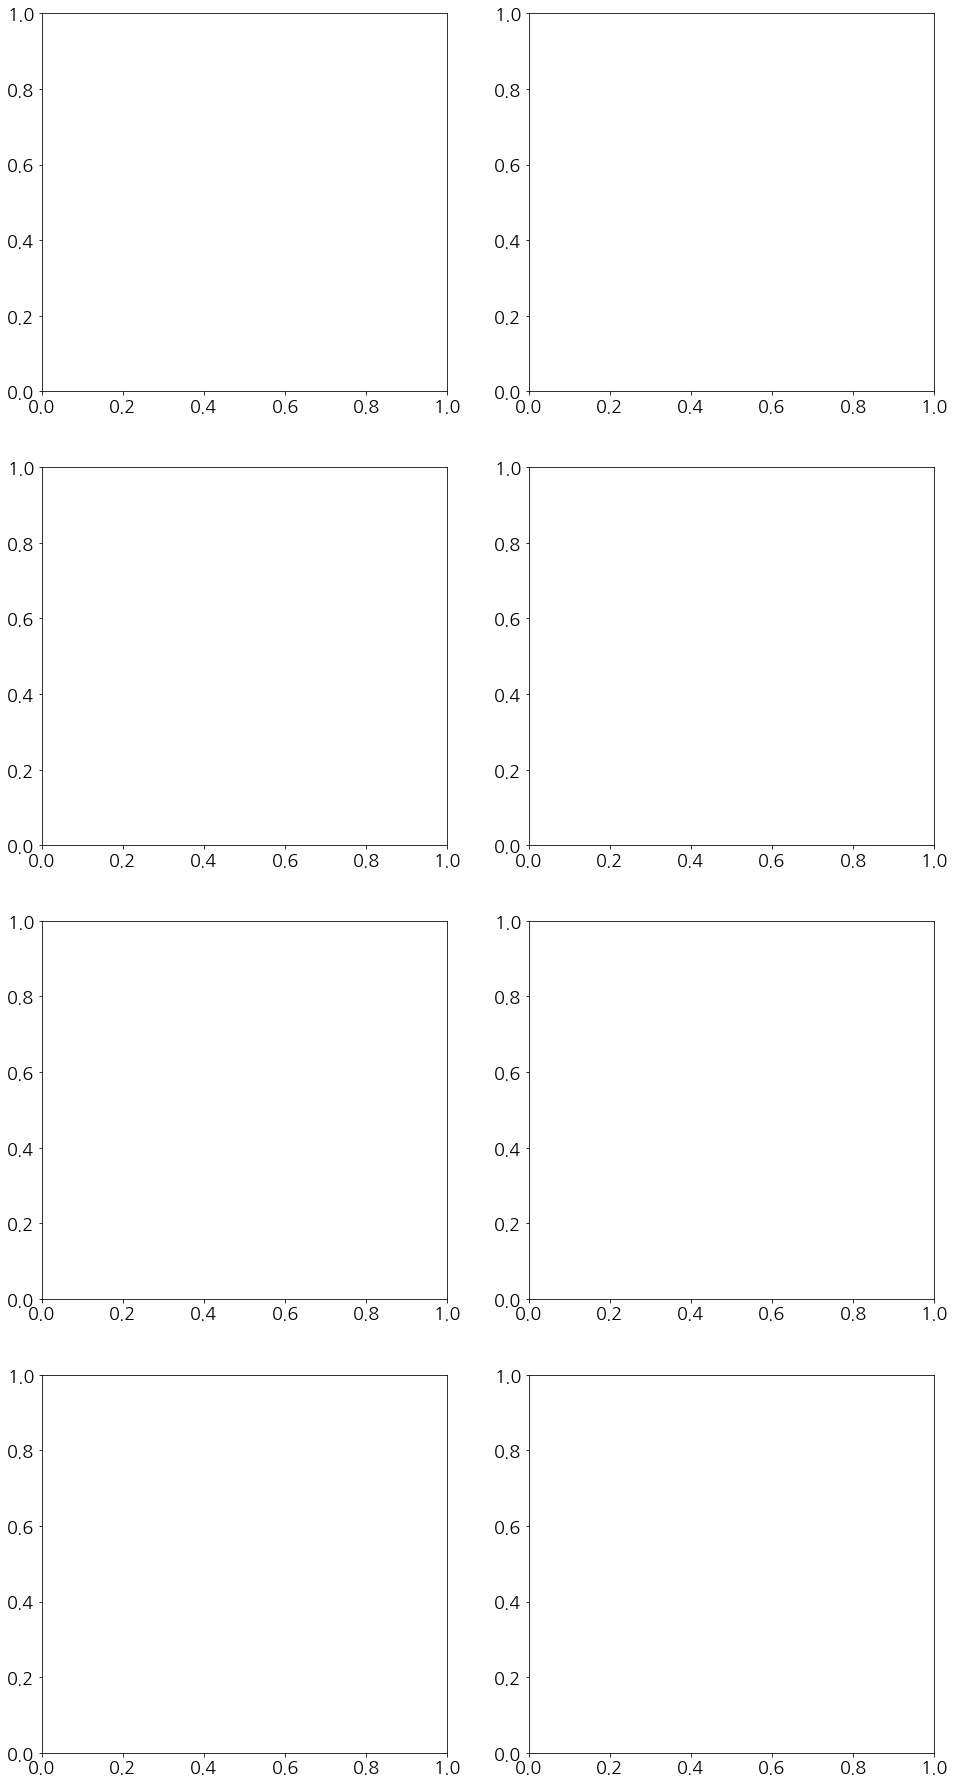

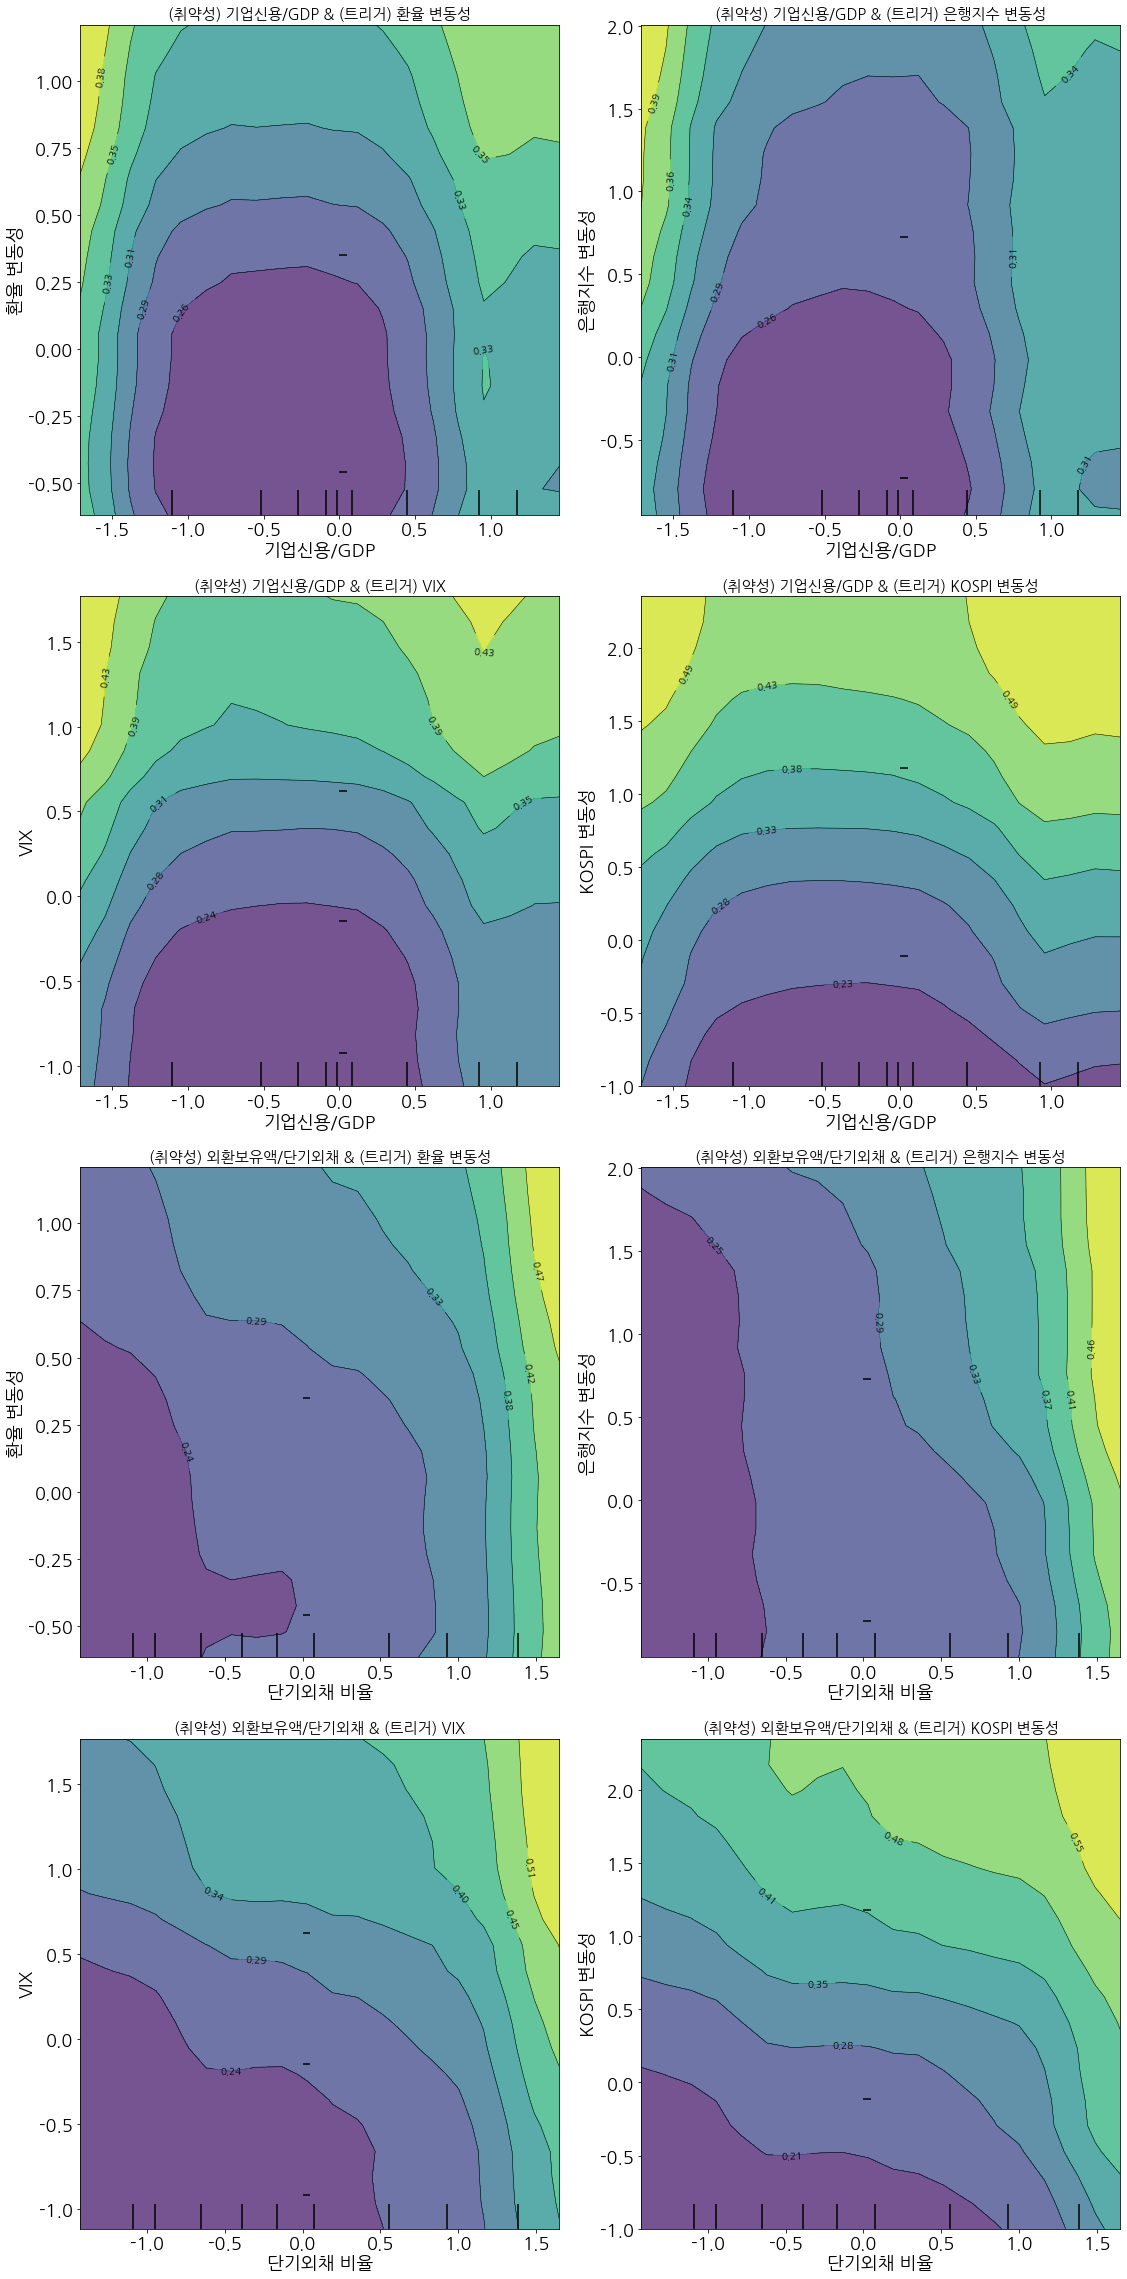

In [279]:
# 필요한 라이브러리 임포트
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')

# 취약성과 트리거 분류
vulnerability = {
    'res_sdebt_neg': "단기외채 비율",
    'bank_lev_diff': "은행 레버리지",
    'bank_ldr_diff': "은행 예대율",
    'hc_gdp_diff': "가계신용/GDP",
    'cc_gdp_diff': "기업신용/GDP"
}

trigger = {
    'kb_hp_pchg': "주택가격",
    'stock_cmax': "KOSPI 변동성",
    'bank_mv': "은행지수 변동성",
    'cp_sp_diff': "CP 스프레드",
    'sr_sp_diff': "국가 신용 스프레드",
    'tp_sp_neg_diff': "기간 프리미엄 스프레드",
    'cd_sp_diff': "CD 스프레드",
    'er_mv': "환율 변동성",
    'vix': "VIX",
    'gdp_growth_neg': "GDP 성장률"
}

# 영문명에서 한글명으로의 매핑 생성
all_features_kr = {**vulnerability, **trigger}  # 취약성과 트리거 모두 포함
x_cols_kr = [all_features_kr.get(col, col) for col in x_cols]

# 필요한 행의 수 계산 및 플롯 초기화
rows = np.ceil(len(top_feature_combinations) / 2).astype(int)
fig, axs = plt.subplots(rows, 2, figsize=(16, 32)) 

top_feature_combinations_indices = [(
    x_cols.index(vul),  # 취약성 특성의 인덱스
    x_cols.index(trg)   # 트리거 특성의 인덱스
) for vul, trg in top_feature_combinations]

# 필요한 행의 수 계산 및 플롯 초기화
rows = np.ceil(len(top_feature_combinations_indices) / 2).astype(int)
fig, axs = plt.subplots(rows, 2, figsize=(16, 28))

for i, ((vul_idx, trg_idx), (vul_kr, trg_kr)) in enumerate(zip(top_feature_combinations_indices, top_feature_combinations_kr)):
    row = i // 2
    col = i % 2
    ax = axs[row, col] if rows > 1 else axs[col]
    
    # Two-way PDP 그리기, 인덱스 사용
    plot_partial_dependence(
        model,
        scaled_X, 
        features=[(vul_idx, trg_idx)],  # 인덱스 조합 사용
        ax=ax,
        grid_resolution=20,
        kind='average',
        feature_names=x_cols_kr,  # 한글 변수명 목록 사용
    )
    ax.set_title(f'(취약성) {vul_kr} & (트리거) {trg_kr}', fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
"""
SHAP는 개별 예측에 대해 "이 변수가 이 예측에 0.1의 기여를 했다"와 같이 구체적인 기여도를 제공
PDP는 "이 변수가 변경될 때, 모델의 평균 예측값은 어떻게 변화하는가"를 보여줌 
    # 단 PDP의 일반적 한계점 : 기본적인 PDP는 한 번에 하나의 변수만 고려하여 그 변수의 평균적인 영향을 보여줌. 이 경우, 다른 변수들의 가능한 모든 조합을 고려하지 않기 때문에 복잡한 상호작용을 포착하지 못할 수 있다는 일반적인 한계가 있음
    # 그래서 two-way 한다!!! 
LIME은 주어진 데이터 포인트에서 "이 변수가 예측에 미치는 로컬(지역적) 영향은 이러하다"를 설명 가능 ! 

"""

## 6.4 이슈노트 추가 그림

In [1162]:
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 깨지지 않도록 설정
plt.rc('font', family='NanumGothic', size=18)  # 한글 폰트 설정 및 기본 폰트 사이즈 조정

def compare_plots_issue(*plot_list):
    _, axes = plt.subplots(1, len(plot_list), figsize=(20, 8))
    
    # 실선과 점선 설정
    line_styles = ['-', '--']
    # 색상 설정: 첫 번째와 두 번째 변수는 검정색, 세 번째와 네 번째 변수는 파란색
    colors = ['black', 'black', 'dimgrey', 'dimgrey'] # dimgrey
    
    for i, plot in enumerate(plot_list):
        ax = axes[i] if isinstance(axes, np.ndarray) else axes
        
        # 데이터 플로팅
        for j, (id, label) in enumerate(plot['data'].items()):
            # 변수 별로 다른 스타일과 색상 적용
            linestyle = line_styles[j % len(line_styles)]
            color = colors[j % len(colors)]
            #data[id].transform(scale).resample('Q').mean().plot(ax=ax, lw=4, alpha=0.75, label=label, color=color, linestyle=linestyle)
            data[id].transform(scale).resample('M').mean().plot(ax=ax, lw=4, alpha=0.75, label=label, color=color, linestyle=linestyle)
        # 기존 설정 유지
        ax.tick_params(axis='x', labelsize=35)
        ax.tick_params(axis='y', labelsize=35, direction='in', length=6)
        ax_right = ax.twinx()
        ax_right.tick_params(axis='y', labelsize=35, direction='in', length=6)
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin * 0.95, ymax * 1.00)
        ax_right.set_ylim(ymin * 0.95, ymax * 1.00)
        
        combined_condition = np.logical_or(crises.term, crises.post_term)
        ax.fill_between(fsi.index, ymin, ymax, color='red', where=combined_condition, alpha=0.4)

        
        # 백그라운드로 crises6 사용하여 위기 시기 표시
        edges = np.diff(combined_condition.astype(int))
        starts = np.where(edges == 1)[0] + 1  # True가 시작하는 지점
        ends = np.where(edges == -1)[0]  # True가 끝나는 지점

        # 시작점과 끝점을 조정합니다.
        if len(ends) == 0 or (len(starts) > 0 and starts[0] > ends[0]):
            starts = np.insert(starts, 0, 0)
        if len(ends) > 0 and (len(starts) == 0 or ends[-1] < starts[-1]):
            ends = np.append(ends, len(combined_condition) - 1)

        # ax.set_xlim 수정
        ax.set_xlim(pd.Timestamp('1998-07-01'), pd.Timestamp('2024-04-21'))

        # 세로선 그리기 부분에서 Period를 Timestamp로 변환
        for start in starts:
            start_date = fsi.index[start]
            if isinstance(start_date, pd.Period):
                start_date = start_date.to_timestamp()
            ax.axvline(x=start_date, color='red', linewidth=2, alpha=0.3)

        for end in ends:
            end_date = fsi.index[min(end, len(fsi.index)-1)]
            if isinstance(end_date, pd.Period):
                end_date = end_date.to_timestamp()
            ax.axvline(x=end_date, color='red', linewidth=2, alpha=0.3)


        ax.axhline(0, color='black', lw=2)
        
        #render_gdp_drop(ax)
        render_gdp_drop(ax, freq='M')
        ax.set_xlim(['2021Q1', '2024Q2'])
        ax.legend(ncol=3, loc=2, frameon=False, fontsize=32)
        #ax.set_title(plot['title'], fontsize=18)
        
    plt.tight_layout()
    plt.savefig('/home/work/modelhub/EWS/svg/그림5-2.svg', format='svg')
    plt.show()


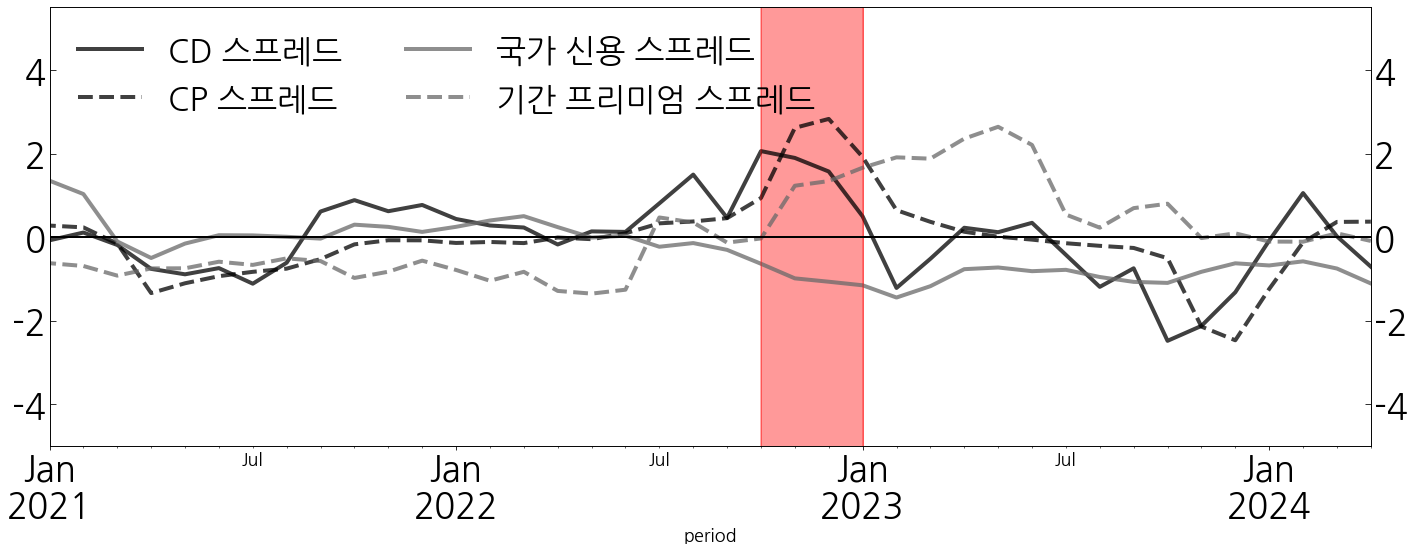

In [1159]:
compare_plots_issue({'title':'CD, CP, 국가 신용, 기간 프리미엄 스프레드', 'data':{'cd_sp_diff' : 'CD 스프레드','cp_sp_diff': 'CP 스프레드','sr_sp_diff': '국가 신용 스프레드','tp_sp_neg_diff': '기간 프리미엄 스프레드'}})
#compare_plots_issue({'title':'CD, CP, 국가 신용, 기간 프리미엄 스프레드', 'data':{'cd_sp_diff' : 'CD 스프레드','cp_sp_diff': 'CP 스프레드','sr_sp_diff': '국가 신용 스프레드'}})


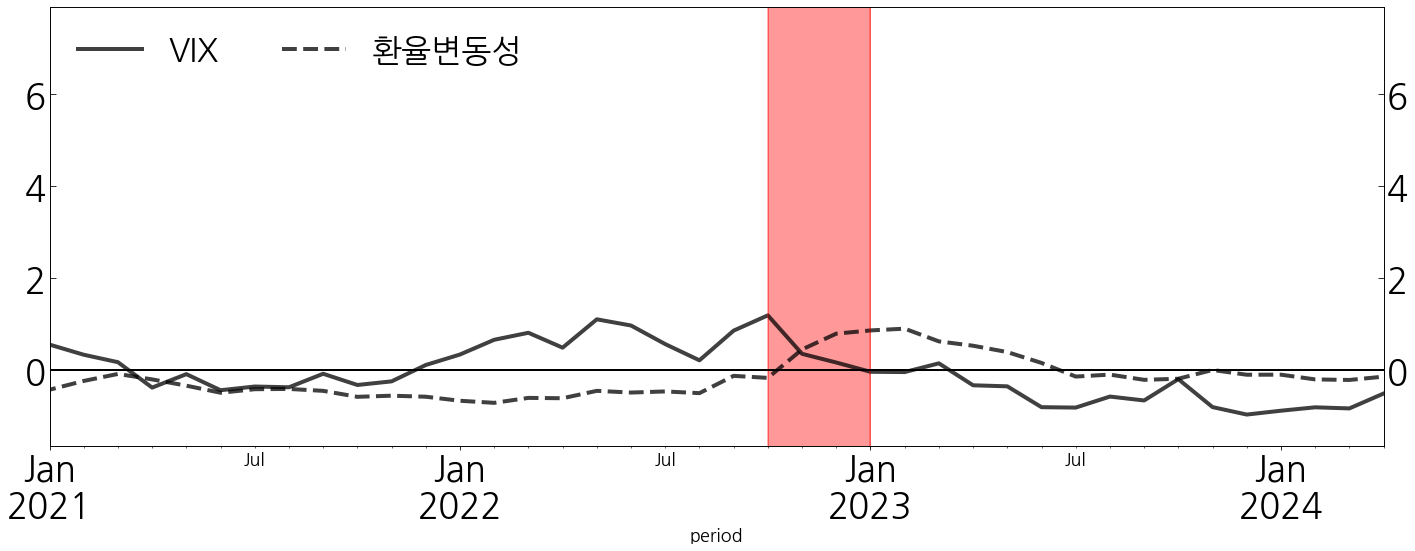

In [1160]:
compare_plots_issue({'title':'CD, CP, 국가 신용, 기간 프리미엄 스프레드', 'data':{'vix' : 'VIX','er_mv': '환율변동성'}})

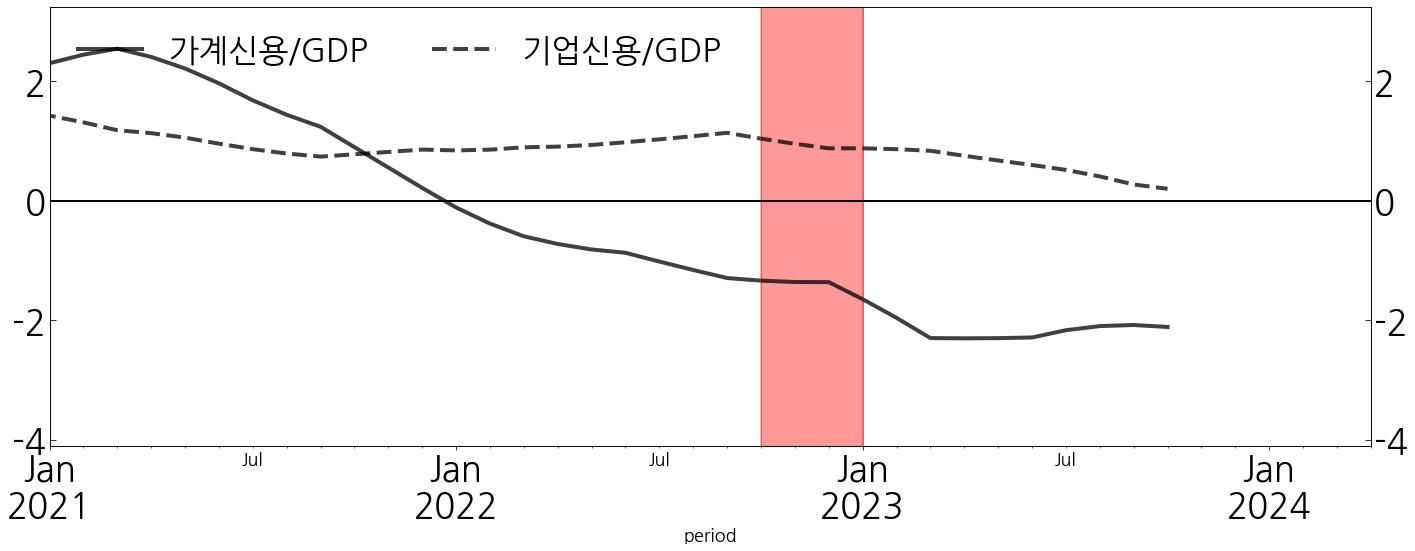

In [1161]:
compare_plots_issue({'title':'CD, CP, 국가 신용, 기간 프리미엄 스프레드', 'data':{'hc_gdp_diff': '가계신용/GDP','cc_gdp_diff': '기업신용/GDP'}})


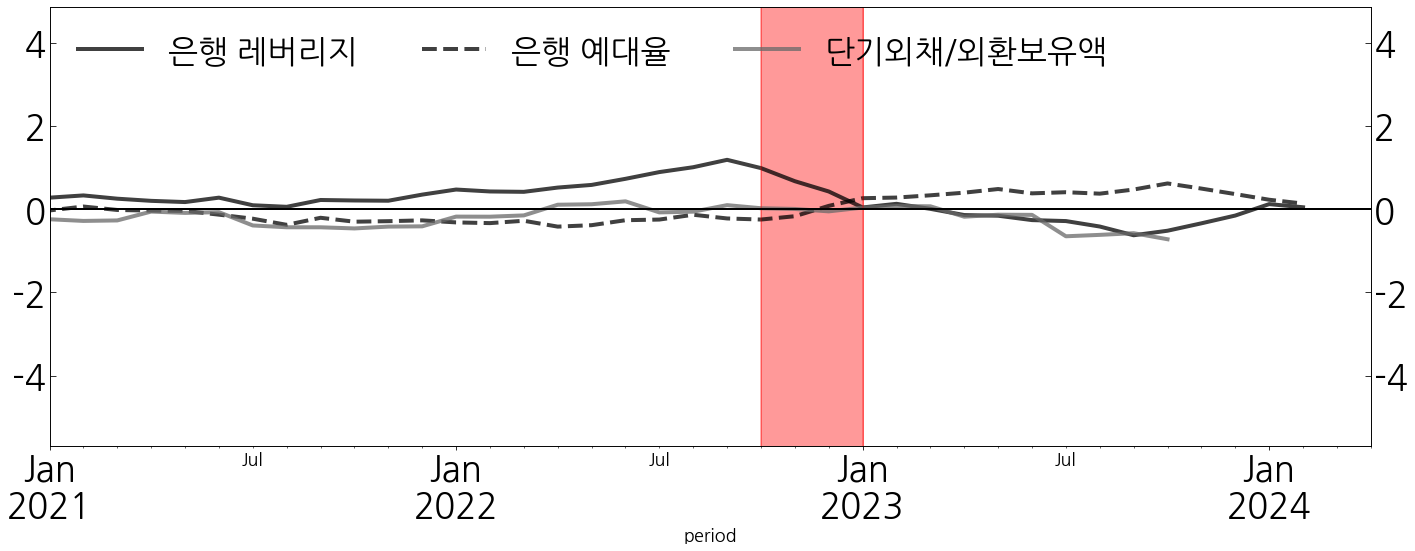

In [1163]:
compare_plots_issue({'title':'CD, CP, 국가 신용, 기간 프리미엄 스프레드', 'data':{'bank_lev_diff': '은행 레버리지','bank_ldr_diff': '은행 예대율','res_sdebt_neg':'단기외채/외환보유액' }})

In [944]:


mean_value = agg_pred['ET'].mean()
median_value = agg_pred['ET'].median()
perc70 = agg_pred['ET'].quantile(0.7)
perc90 = agg_pred['ET'].quantile(0.9)
perc95 = agg_pred['ET'].quantile(0.95)
perc99 = agg_pred['ET'].quantile(0.99)
print("Mean:", mean_value)
print("Median:", median_value)
print("70th Percentile:", perc70)
print("90th Percentile:", perc90)
print("70th Percentile:", perc70)
print("90th Percentile:", perc90)

Mean: 0.1120062695924765
Median: 0.029
70th Percentile: 0.14299999999999996
90th Percentile: 0.3144
70th Percentile: 0.14299999999999996
90th Percentile: 0.3144


In [1151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_plots_issue(*plot_list):
    _, axes = plt.subplots(1, len(plot_list), figsize=(24, 8))
    
    line_styles = ['-', '--']
    colors = ['black', 'black', 'dimgrey', 'dimgrey']
    
    for i, plot in enumerate(plot_list):
        ax = axes[i] if isinstance(axes, np.ndarray) else axes
        
        for j, (id, label) in enumerate(plot['agg_pred'].items()):
            linestyle = line_styles[j % len(line_styles)]
            color = colors[j % len(colors)]
            # agg_pred[id]를 직접 사용하여 플롯
            agg_pred[id].plot(ax=ax, lw=4, alpha=0.75, label=label, color=color, linestyle=linestyle)
        
        ax.tick_params(axis='x', labelsize=35)
        ax.tick_params(axis='y', labelsize=35, direction='in', length=6)
        ax_right = ax.twinx()
        ax_right.tick_params(axis='y', labelsize=35, direction='in', length=6)
        
        ymin, ymax = -0.1, 0.8  # y축 범위를 0에서 1로 고정
        ax.set_ylim(ymin, ymax)
        ax_right.set_ylim(ymin, ymax)
        
        combined_condition = np.logical_or(crises.term, crises.post_term)
        ax.fill_between(fsi.index, ymin, ymax, color='red', where=combined_condition, alpha=0.4)

        edges = np.diff(combined_condition.astype(int))
        starts = np.where(edges == 1)[0] + 1  
        ends = np.where(edges == -1)[0]  

        if len(ends) == 0 or (len(starts) > 0 and starts[0] > ends[0]):
            starts = np.insert(starts, 0, 0)
        if len(ends) > 0 and (len(starts) == 0 or ends[-1] < starts[-1]):
            ends = np.append(ends, len(combined_condition) - 1)

        ax.set_xlim(pd.Timestamp('1998-07-01'), pd.Timestamp('2024-01-01'))

        for start in starts:
            start_date = fsi.index[start]
            if isinstance(start_date, pd.Period):
                start_date = start_date.to_timestamp(how='start')
            ax.axvline(x=start_date, color='red', linewidth=2, alpha=0.3)

        for end in ends:
            end_date = fsi.index[min(end, len(fsi.index)-1)]
            if isinstance(end_date, pd.Period):
                end_date = end_date.to_timestamp(how='start')
            ax.axvline(x=end_date, color='red', linewidth=2, alpha=0.3)

        ax.axhline(0, color='black', lw=2)
        ax.axhline(perc70, color='dimgrey', linestyle='--', lw=1.5 )#, label='70th')
        ax.axhline(perc90, color='dimgrey',  linestyle=':',  lw=1.5 )#, label='90th')
        #ax.axhline(perc95, color='black',  linestyle=':',  lw=1.5 )#, label='90th')
        #ax.axhline(perc99, color='black',  linestyle=':',  lw=1.5 )#, label='90th')
        ax.set_xlim([pd.Timestamp('1999-01-01'), pd.Timestamp('2024-04-24')])
        ax.legend(ncol=3, loc=2, frameon=False, fontsize=32)
        render_gdp_drop(ax, freq='M')

    plt.tight_layout()
    plt.savefig('/home/work/modelhub/EWS/svg/부록3-2.svg', format='svg')
    plt.show()


In [838]:
ax

<AxesSubplot:title={'center':'(취약성) 단기외채 비율 & (트리거) KOSPI 변동성'}>

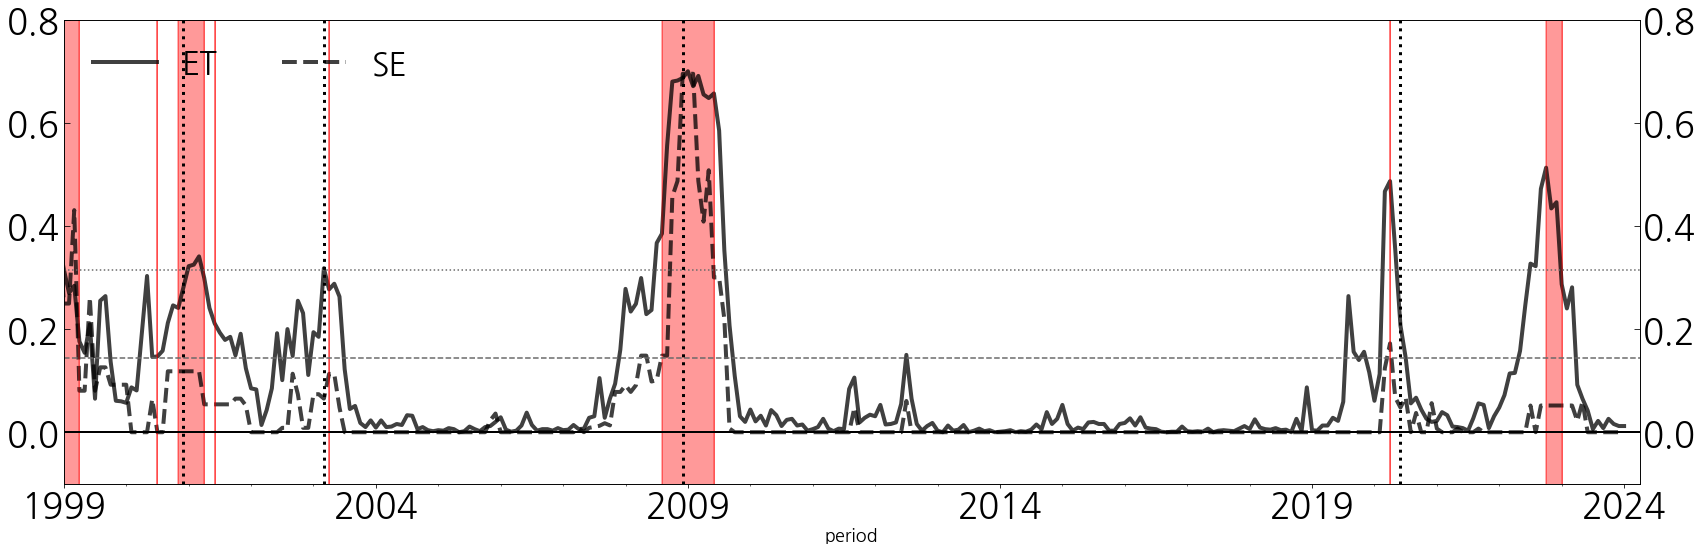

In [1152]:
compare_plots_issue({'title':'모델결과', 'agg_pred':{'ET': 'ET','SE': 'SE'}})

In [1184]:
type(agg_pred['ET'])

pandas.core.series.Series

In [1185]:
agg_pred['ET'].to_csv('/home/work/modelhub/EWS/svg/result.txt', index=False, header=True)

In [622]:
agg_pred

LR     Lasso     Ridge  ElasticNet       SVM        NN  \
period                                                                  
1997-07  0.020066  0.012400  0.116205    0.120175  0.050681  0.324086   
1997-08  0.024780  0.014272  0.130706    0.134409  0.061543  0.362807   
1997-09  0.026310  0.014855  0.135107    0.138714  0.062217  0.374222   
1997-10  0.222753  0.136231  0.433812    0.418101  0.740991  0.658866   
1997-11  0.191528  0.107401  0.500723    0.478244  0.835344  0.715548   
...           ...       ...       ...         ...       ...       ...   
2023-09  0.002374  0.001654  0.031441    0.034875  0.057935  0.111427   
2023-10  0.000618  0.000641  0.017029    0.018258  0.057192  0.062235   
2023-11  0.000451  0.000440  0.009780    0.011522  0.028894  0.103516   
2023-12  0.000284  0.000208  0.007264    0.008522  0.018698  0.255863   
2024-01  0.000789  0.000493  0.016906    0.018699  0.024359  0.169645   

               SE        RF       XGB     ET  
period                                        
1997-07  0.000000  0.117007  0.011148  0.047  
1997-08  0.000000  0.117161  0.011148  0.060  
1997-09  0.000000  0.114522  0.015407  0.068  
1997-10  0.169043  0.076643  0.006719  0.149  
1997-11  0.169043  0.145143  0.028310  0.228  
...           ...       ...       ...    ...  
2023-09  0.000000  0.004000  0.001969  0.008  
2023-10  0.000000  0.010000  0.001677  0.026  
2023-11  0.000000  0.019000  0.003195  0.016  
2023-12  0.000000  0.008000  0.002280  0.012  
2024-01  0.000000  0.012000  0.003857  0.012  

[319 rows x 10 columns]

In [621]:
data

ms91      ms1y       cd91      cp91       kb3y     kb10y  \
period                                                                  
1997-07       NaN       NaN  11.909545       NaN  11.650000       NaN   
1997-08       NaN       NaN  12.651500       NaN  11.650000       NaN   
1997-09       NaN       NaN  13.391053       NaN  11.650000       NaN   
1997-10       NaN       NaN  13.784091       NaN  11.650000       NaN   
1997-11       NaN       NaN  14.499500       NaN  12.430000       NaN   
...           ...       ...        ...       ...        ...       ...   
2023-09  3.606421  3.645526   3.763158  4.011579   3.841632  3.948526   
2023-10  3.635105  3.740842   3.821579  4.168421   4.031000  4.272000   
2023-11  3.608818  3.689773   3.832727  4.310000   3.771455  3.889545   
2023-12  3.517350  3.488250   3.834500  4.291000   3.349550  3.414700   
2024-01  3.409727  3.312364   3.737273  4.234091   3.265818  3.353091   

            ub10y    cbaa3y       call           er  ...   bank_lev  \
period                                               ...              
1997-07  6.217087       NaN  11.390000   890.500000  ...  14.786241   
1997-08  6.293190       NaN  12.368000   895.900000  ...  14.772182   
1997-09  6.209227       NaN  13.113478   909.526087  ...  14.681024   
1997-10  6.020087       NaN  13.523846   921.853846  ...  14.689145   
1997-11  5.866450       NaN  13.997200  1025.580000  ...  15.681498   
...           ...       ...        ...          ...  ...        ...   
2023-09  4.364719  4.599737   3.595316  1329.473684  ...  14.941946   
2023-10  4.797191  4.832947   3.516211  1350.694737  ...  14.830635   
2023-11  4.491327  4.573045   3.569136  1310.390909  ...  14.677963   
2023-12  4.008443  4.068750   3.645000  1304.747368  ...  14.622175   
2024-01  4.034491  4.006182   3.472636  1323.568182  ...  14.681799   

         bank_lev_diff    bank_ldr  bank_ldr_diff   bank_mv  gdp_growth_neg  \
period                                                                        
1997-07            NaN  108.183148            NaN       NaN            -0.8   
1997-08            NaN  107.095358            NaN       NaN            -0.8   
1997-09            NaN  105.749425            NaN       NaN            -0.8   
1997-10            NaN  107.203431            NaN       NaN             0.5   
1997-11            NaN  106.786791            NaN       NaN             0.5   
...                ...         ...            ...       ...             ...   
2023-09      -1.172305  113.245659       3.956883  0.026838            -0.6   
2023-10      -0.989448  114.807114       5.098048  0.027404            -0.6   
2023-11      -0.690530  114.408735       4.133803  0.027071             NaN   
2023-12      -0.377001  113.718270       3.103047  0.028100             NaN   
2024-01       0.084022  115.862353       2.043869  0.022973             NaN   

         tp_sp_neg_diff     sr_sp  sr_sp_diff  cd_sp_diff  
period                                                     
1997-07             NaN       NaN         NaN         NaN  
1997-08             NaN       NaN         NaN         NaN  
1997-09             NaN       NaN         NaN         NaN  
1997-10             NaN       NaN         NaN         NaN  
1997-11             NaN       NaN         NaN         NaN  
...                 ...       ...         ...         ...  
2023-09        0.303595 -0.416193   -0.807334   -0.142563  
2023-10        0.348526 -0.525191   -0.823528   -0.469105  
2023-11       -0.001455 -0.601782   -0.649373   -0.402000  
2023-12        0.046518 -0.593743   -0.515984   -0.250486  
2024-01       -0.037055 -0.681400   -0.549737   -0.017805  

[319 rows x 83 columns]

In [878]:


mean_value = agg_pred['ET'].mean()
median_value = agg_pred['ET'].median()
perc70 = agg_pred['ET'].quantile(0.7)
perc90 = agg_pred['ET'].quantile(0.9)

print("Mean:", mean_value)
print("Median:", median_value)
print("70th Percentile:", perc70)
print("90th Percentile:", perc90)

Mean: 0.1120062695924765
Median: 0.029
70th Percentile: 0.14299999999999996
90th Percentile: 0.3144


In [ ]:

""" # 일반 실선
def compare_plots_issue(*plot_list):
    _, axes = plt.subplots(1, len(plot_list), figsize=(20, 8))
    
    # 미리 정의된 색상 리스트
    colors = ['darkblue',  'darkred','darkgreen', 'purple', 'brown']
    
    for i, plot in enumerate(plot_list):
        ax = axes[i] if isinstance(axes, np.ndarray) else axes
        
        # 데이터 플로팅에 다른 색상 사용
        for j, (id, label) in enumerate(plot['data'].items()):
            color = colors[j % len(colors)]  # 색상 리스트에서 순차적으로 색상 선택
            data[id].transform(scale).resample('Q').mean().plot(ax=ax, lw=4, alpha=0.75, label=label, color=color)
            #data[id].transform(scale).resample('Q').mean().plot(ax=ax, lw=4, alpha=0.75, label=label, style='--', color=color)
        
        
        # y축 라벨 폰트 사이즈 조정
        ax.tick_params(axis='y', labelsize=14, direction='in', length=6)
        ax_right = ax.twinx()
        ax_right.tick_params(axis='y', labelsize=14, direction='in', length=6)

        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin * 0.95, ymax * 1.05)  # y축 범위 조정으로 위아래 공백 최소화
        ax_right.set_ylim(ymin * 0.95, ymax * 1.05)

        # 백그라운드로 crises6 사용하여 위기 시기 표시
        ax.fill_between(crises6.index, ymin, ymax, where=crises6['term'].values, facecolor='red', alpha=0.3)
        ax.fill_between(crises6.index, ymin, ymax, where=crises6['pre_term'].values, facecolor='red', alpha=0.2)
        ax.fill_between(crises6.index, ymin, ymax, where=crises6['post_term'].values, facecolor='yellow', alpha=0.1)
        ax.axhline(0, color='black', lw=1, linestyle='--')
        render_gdp_drop(ax)
        ax.set_xlim(['2003Q1', '2024Q1'])
        ax.legend(ncol=2, loc=2, frameon=False, fontsize=20)
        ax.set_title(plot['title'], fontsize=18)
###
        